In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD
from vis.utils import utils

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (InceptionV3 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = InceptionV3(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
print("Extracting features from InceptionV3 layers ...")
bnfeatures = base_model.predict(X)

Extracting features from InceptionV3 layers ...


In [8]:
print(bnfeatures)

[[ 1.02370095  0.07358773  0.11362752 ...,  0.28845212  0.08080276
   1.38181984]
 [ 0.72004354  0.28426707  0.27027884 ...,  0.48382932  0.2381126
   1.08933818]
 [ 1.42632687  0.47468451  0.19969146 ...,  0.61127937  0.03539086
   1.81213033]
 ..., 
 [ 1.05646431  0.50958735  0.7666868  ...,  1.06848764  0.6450752
   0.64537811]
 [ 1.03259182  0.60772502  0.41582578 ...,  0.36235273  0.75517714
   0.61016005]
 [ 1.38276649  0.48677182  0.75463331 ...,  0.52827692  0.4687168
   0.7556206 ]]


In [9]:
bnfeatures.shape

(10136, 2048)

In [10]:
# Adding a custom top layer to the model
predictions = Dense(num_classes, activation='softmax', name='predictions')(base_model.output)
model = Model(inputs=base_model.input, outputs=predictions)
#model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 111, 111, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 111, 111, 32)  96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 111, 111, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [11]:
# Creating the top model for pre-training
bottleneck_features = Input(shape=bnfeatures.shape[1:], name='bottleneck_features')
predictions = Dense(num_classes, activation='softmax', name='predictions')(bottleneck_features)
top_model = Model(inputs=bottleneck_features, outputs=predictions)
top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottleneck_features (InputLa (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 20)                40980     
Total params: 40,980
Trainable params: 40,980
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [13]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=100
history = []
tophistory = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='virussign-inceptionv3-pretrained-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()
init_top_weights = top_model.get_weights()

In [14]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    bnfeatures_train = bnfeatures[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    bnfeatures_test = bnfeatures[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
  
    print("[%d] Pre-training the top model ..." %(i))

    top_model.set_weights(init_top_weights)

    y_prob = top_model.predict(bnfeatures_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
    
    start = time.time()
    h = top_model.fit(bnfeatures_train, Y_train, validation_data=(bnfeatures_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    tophistory.append(h)
    
    pretrained_top_weights = top_model.get_weights()
          
    y_prob = top_model.predict(bnfeatures_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Pre-trained acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
   
    print("[%d] Fine-tuning the model ..." %(i))

    model.set_weights(init_weights)
    model.layers[-1].set_weights(init_top_weights)
    
    #y_prob = model.predict(X_test, verbose=0)  # Testing
    #y_pred = np.argmax(y_prob, axis=1)
    #print("[%d] Initial acurracy (model): %.4f" %(i,accuracy_score(y_test,y_pred)))
    
    model.layers[-1].set_weights(pretrained_top_weights)

    #y_prob = model.predict(X_test, verbose=0)  # Testing
    #y_pred = np.argmax(y_prob, axis=1)
    #print("[%d] Pre-trained acurracy (model): %.4f" %(i,accuracy_score(y_test,y_pred)))    
    
    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
        
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Pre-training the top model ...
[0] Initial acurracy (top_model): 0.0508
Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 0s - loss: 1.0850 - acc: 0.6862 - val_loss: 0.7652 - val_acc: 0.7793
Epoch 2/100
9112/9112 [==============================] - 0s - loss: 0.6470 - acc: 0.7964 - val_loss: 0.6533 - val_acc: 0.7979
Epoch 3/100
9112/9112 [==============================] - 0s - loss: 0.5535 - acc: 0.8273 - val_loss: 0.6038 - val_acc: 0.8115
Epoch 4/100
9112/9112 [==============================] - 0s - loss: 0.4938 - acc: 0.8432 - val_loss: 0.5711 - val_acc: 0.8203
Epoch 5/100
9112/9112 [==============================] - 0s - loss: 0.4545 - acc: 0.8577 - val_loss: 0.5475 - val_acc: 0.8271
Epoch 6/100
9112/9112 [==============================] - 0s - loss: 0.4183 - acc: 0.8697 - val_loss: 0.5355 - val_acc: 0.8242
Epoch 7/100
9112/9112 [==============================] - 0s - loss: 0.3873 - acc: 0.8786 - val_loss: 0.5484 - val_acc: 0

9112/9112 [==============================] - 0s - loss: 0.0752 - acc: 0.9828 - val_loss: 0.5919 - val_acc: 0.8643
Epoch 65/100
9112/9112 [==============================] - 0s - loss: 0.0705 - acc: 0.9858 - val_loss: 0.5818 - val_acc: 0.8613
Epoch 66/100
9112/9112 [==============================] - 0s - loss: 0.0694 - acc: 0.9853 - val_loss: 0.5697 - val_acc: 0.8594
Epoch 67/100
9112/9112 [==============================] - 0s - loss: 0.0675 - acc: 0.9874 - val_loss: 0.5813 - val_acc: 0.8672
Epoch 68/100
9112/9112 [==============================] - 0s - loss: 0.0652 - acc: 0.9881 - val_loss: 0.6028 - val_acc: 0.8682
Epoch 69/100
9112/9112 [==============================] - 0s - loss: 0.0678 - acc: 0.9861 - val_loss: 0.6150 - val_acc: 0.8535
Epoch 70/100
9112/9112 [==============================] - 0s - loss: 0.0672 - acc: 0.9869 - val_loss: 0.6160 - val_acc: 0.8477
Epoch 71/100
9112/9112 [==============================] - 0s - loss: 0.0632 - acc: 0.9881 - val_loss: 0.5902 - val_acc: 0.85

9112/9112 [==============================] - 71s - loss: 0.0134 - acc: 0.9984 - val_loss: 0.7787 - val_acc: 0.8486
Epoch 28/100
9112/9112 [==============================] - 71s - loss: 0.0137 - acc: 0.9979 - val_loss: 0.7752 - val_acc: 0.8574
Epoch 29/100
9112/9112 [==============================] - 71s - loss: 0.0163 - acc: 0.9971 - val_loss: 0.7902 - val_acc: 0.8555
Epoch 30/100
9112/9112 [==============================] - 71s - loss: 0.0120 - acc: 0.9984 - val_loss: 0.7956 - val_acc: 0.8525
Epoch 31/100
9112/9112 [==============================] - 71s - loss: 0.0115 - acc: 0.9987 - val_loss: 0.8037 - val_acc: 0.8555
Epoch 32/100
9112/9112 [==============================] - 71s - loss: 0.0110 - acc: 0.9984 - val_loss: 0.8002 - val_acc: 0.8555
Epoch 33/100
9112/9112 [==============================] - 71s - loss: 0.0122 - acc: 0.9980 - val_loss: 0.8011 - val_acc: 0.8564
Epoch 34/100
9112/9112 [==============================] - 71s - loss: 0.0153 - acc: 0.9973 - val_loss: 0.7942 - val_a

9112/9112 [==============================] - 71s - loss: 0.0061 - acc: 0.9996 - val_loss: 0.8102 - val_acc: 0.8623
Epoch 92/100
9112/9112 [==============================] - 71s - loss: 0.0099 - acc: 0.9990 - val_loss: 0.8278 - val_acc: 0.8613
Epoch 93/100
9112/9112 [==============================] - 71s - loss: 0.0062 - acc: 0.9995 - val_loss: 0.8341 - val_acc: 0.8594
Epoch 94/100
9112/9112 [==============================] - 71s - loss: 0.0058 - acc: 0.9993 - val_loss: 0.8301 - val_acc: 0.8604
Epoch 95/100
9112/9112 [==============================] - 71s - loss: 0.0057 - acc: 0.9993 - val_loss: 0.8329 - val_acc: 0.8604
Epoch 96/100
9112/9112 [==============================] - 71s - loss: 0.0062 - acc: 0.9993 - val_loss: 0.8280 - val_acc: 0.8682
Epoch 97/100
9112/9112 [==============================] - 71s - loss: 0.0056 - acc: 0.9993 - val_loss: 0.8313 - val_acc: 0.8633
Epoch 98/100
9112/9112 [==============================] - 71s - loss: 0.0061 - acc: 0.9993 - val_loss: 0.8326 - val_a

9114/9114 [==============================] - 0s - loss: 0.0783 - acc: 0.9837 - val_loss: 0.5262 - val_acc: 0.8581
Epoch 55/100
9114/9114 [==============================] - 0s - loss: 0.0790 - acc: 0.9823 - val_loss: 0.5370 - val_acc: 0.8601
Epoch 56/100
9114/9114 [==============================] - 0s - loss: 0.0767 - acc: 0.9823 - val_loss: 0.5651 - val_acc: 0.8669
Epoch 57/100
9114/9114 [==============================] - 0s - loss: 0.0782 - acc: 0.9821 - val_loss: 0.5715 - val_acc: 0.8620
Epoch 58/100
9114/9114 [==============================] - 0s - loss: 0.0755 - acc: 0.9837 - val_loss: 0.5437 - val_acc: 0.8630
Epoch 59/100
9114/9114 [==============================] - 0s - loss: 0.0767 - acc: 0.9821 - val_loss: 0.5623 - val_acc: 0.8591
Epoch 60/100
9114/9114 [==============================] - 0s - loss: 0.0713 - acc: 0.9858 - val_loss: 0.5503 - val_acc: 0.8718
Epoch 61/100
9114/9114 [==============================] - 0s - loss: 0.0688 - acc: 0.9864 - val_loss: 0.5337 - val_acc: 0.87

9114/9114 [==============================] - 72s - loss: 0.0299 - acc: 0.9956 - val_loss: 0.6188 - val_acc: 0.8640
Epoch 18/100
9114/9114 [==============================] - 72s - loss: 0.0316 - acc: 0.9955 - val_loss: 0.6565 - val_acc: 0.8659
Epoch 19/100
9114/9114 [==============================] - 71s - loss: 0.0277 - acc: 0.9964 - val_loss: 0.6477 - val_acc: 0.8591
Epoch 20/100
9114/9114 [==============================] - 72s - loss: 0.0281 - acc: 0.9959 - val_loss: 0.6423 - val_acc: 0.8650
Epoch 21/100
9114/9114 [==============================] - 72s - loss: 0.0267 - acc: 0.9963 - val_loss: 0.6488 - val_acc: 0.8650
Epoch 22/100
9114/9114 [==============================] - 72s - loss: 0.0253 - acc: 0.9966 - val_loss: 0.6443 - val_acc: 0.8669
Epoch 23/100
9114/9114 [==============================] - 72s - loss: 0.0287 - acc: 0.9956 - val_loss: 0.6667 - val_acc: 0.8669
Epoch 24/100
9114/9114 [==============================] - 72s - loss: 0.0243 - acc: 0.9971 - val_loss: 0.6504 - val_a

9114/9114 [==============================] - 72s - loss: 0.0107 - acc: 0.9988 - val_loss: 0.6873 - val_acc: 0.8787
Epoch 82/100
9114/9114 [==============================] - 71s - loss: 0.0104 - acc: 0.9987 - val_loss: 0.6747 - val_acc: 0.8777
Epoch 83/100
9114/9114 [==============================] - 72s - loss: 0.0127 - acc: 0.9985 - val_loss: 0.6792 - val_acc: 0.8738
Epoch 84/100
9114/9114 [==============================] - 72s - loss: 0.0103 - acc: 0.9990 - val_loss: 0.6807 - val_acc: 0.8767
Epoch 85/100
9114/9114 [==============================] - 72s - loss: 0.0097 - acc: 0.9991 - val_loss: 0.6761 - val_acc: 0.8816
Epoch 86/100
9114/9114 [==============================] - 72s - loss: 0.0099 - acc: 0.9990 - val_loss: 0.6849 - val_acc: 0.8796
Epoch 87/100
9114/9114 [==============================] - 71s - loss: 0.0102 - acc: 0.9990 - val_loss: 0.7067 - val_acc: 0.8777
Epoch 88/100
9114/9114 [==============================] - 72s - loss: 0.0103 - acc: 0.9989 - val_loss: 0.6849 - val_a

9116/9116 [==============================] - 0s - loss: 0.1184 - acc: 0.9755 - val_loss: 0.6155 - val_acc: 0.8461
Epoch 45/100
9116/9116 [==============================] - 0s - loss: 0.1164 - acc: 0.9747 - val_loss: 0.6095 - val_acc: 0.8402
Epoch 46/100
9116/9116 [==============================] - 0s - loss: 0.1125 - acc: 0.9784 - val_loss: 0.6222 - val_acc: 0.8431
Epoch 47/100
9116/9116 [==============================] - 0s - loss: 0.1128 - acc: 0.9786 - val_loss: 0.6199 - val_acc: 0.8441
Epoch 48/100
9116/9116 [==============================] - 0s - loss: 0.1076 - acc: 0.9800 - val_loss: 0.6355 - val_acc: 0.8461
Epoch 49/100
9116/9116 [==============================] - 0s - loss: 0.1060 - acc: 0.9803 - val_loss: 0.6253 - val_acc: 0.8461
Epoch 50/100
9116/9116 [==============================] - 0s - loss: 0.1076 - acc: 0.9786 - val_loss: 0.6316 - val_acc: 0.8422
Epoch 51/100
9116/9116 [==============================] - 0s - loss: 0.1056 - acc: 0.9800 - val_loss: 0.6117 - val_acc: 0.84

9116/9116 [==============================] - 71s - loss: 0.1451 - acc: 0.9589 - val_loss: 0.6766 - val_acc: 0.8412
Epoch 8/100
9116/9116 [==============================] - 71s - loss: 0.1052 - acc: 0.9746 - val_loss: 0.7350 - val_acc: 0.8441
Epoch 9/100
9116/9116 [==============================] - 71s - loss: 0.0867 - acc: 0.9767 - val_loss: 0.7485 - val_acc: 0.8382
Epoch 10/100
9116/9116 [==============================] - 71s - loss: 0.0780 - acc: 0.9835 - val_loss: 0.7541 - val_acc: 0.8490
Epoch 11/100
9116/9116 [==============================] - 71s - loss: 0.0602 - acc: 0.9866 - val_loss: 0.7534 - val_acc: 0.8373
Epoch 12/100
9116/9116 [==============================] - 71s - loss: 0.0561 - acc: 0.9911 - val_loss: 0.7579 - val_acc: 0.8412
Epoch 13/100
9116/9116 [==============================] - 71s - loss: 0.0452 - acc: 0.9913 - val_loss: 0.7983 - val_acc: 0.8441
Epoch 14/100
9116/9116 [==============================] - 71s - loss: 0.0424 - acc: 0.9920 - val_loss: 0.7996 - val_acc

9116/9116 [==============================] - 70s - loss: 0.0077 - acc: 0.9990 - val_loss: 0.8247 - val_acc: 0.8647
Epoch 72/100
9116/9116 [==============================] - 71s - loss: 0.0074 - acc: 0.9989 - val_loss: 0.8565 - val_acc: 0.8637
Epoch 73/100
9116/9116 [==============================] - 71s - loss: 0.0068 - acc: 0.9991 - val_loss: 0.8372 - val_acc: 0.8637
Epoch 74/100
9116/9116 [==============================] - 71s - loss: 0.0068 - acc: 0.9991 - val_loss: 0.8379 - val_acc: 0.8627
Epoch 75/100
9116/9116 [==============================] - 70s - loss: 0.0062 - acc: 0.9993 - val_loss: 0.8434 - val_acc: 0.8637
Epoch 76/100
9116/9116 [==============================] - 71s - loss: 0.0087 - acc: 0.9991 - val_loss: 0.8242 - val_acc: 0.8637
Epoch 77/100
9116/9116 [==============================] - 71s - loss: 0.0065 - acc: 0.9992 - val_loss: 0.8417 - val_acc: 0.8627
Epoch 78/100
9116/9116 [==============================] - 71s - loss: 0.0068 - acc: 0.9991 - val_loss: 0.8433 - val_a

9120/9120 [==============================] - 0s - loss: 0.1180 - acc: 0.9724 - val_loss: 0.6242 - val_acc: 0.8396
Epoch 35/100
9120/9120 [==============================] - 0s - loss: 0.1186 - acc: 0.9703 - val_loss: 0.6306 - val_acc: 0.8366
Epoch 36/100
9120/9120 [==============================] - 0s - loss: 0.1184 - acc: 0.9681 - val_loss: 0.6246 - val_acc: 0.8445
Epoch 37/100
9120/9120 [==============================] - 0s - loss: 0.1134 - acc: 0.9705 - val_loss: 0.6415 - val_acc: 0.8396
Epoch 38/100
9120/9120 [==============================] - 0s - loss: 0.1126 - acc: 0.9709 - val_loss: 0.6503 - val_acc: 0.8317
Epoch 39/100
9120/9120 [==============================] - 0s - loss: 0.1102 - acc: 0.9732 - val_loss: 0.6619 - val_acc: 0.8287
Epoch 40/100
9120/9120 [==============================] - 0s - loss: 0.1043 - acc: 0.9750 - val_loss: 0.6651 - val_acc: 0.8376
Epoch 41/100
9120/9120 [==============================] - 0s - loss: 0.1027 - acc: 0.9749 - val_loss: 0.6522 - val_acc: 0.83

9120/9120 [==============================] - 0s - loss: 0.0356 - acc: 0.9955 - val_loss: 0.8287 - val_acc: 0.8425
Epoch 99/100
9120/9120 [==============================] - 0s - loss: 0.0354 - acc: 0.9956 - val_loss: 0.8243 - val_acc: 0.8484
Epoch 100/100
9120/9120 [==============================] - 0s - loss: 0.0331 - acc: 0.9965 - val_loss: 0.8288 - val_acc: 0.8435
[3] Pre-trained acurracy (top_model): 0.8435
[3] Fine-tuning the model ...
Train on 9120 samples, validate on 1016 samples
Epoch 1/100
9120/9120 [==============================] - 71s - loss: 2.6189 - acc: 0.5439 - val_loss: 2.1262 - val_acc: 0.5541
Epoch 2/100
9120/9120 [==============================] - 72s - loss: 0.8083 - acc: 0.7807 - val_loss: 0.9201 - val_acc: 0.7707
Epoch 3/100
9120/9120 [==============================] - 72s - loss: 0.5308 - acc: 0.8524 - val_loss: 0.7451 - val_acc: 0.8110
Epoch 4/100
9120/9120 [==============================] - 72s - loss: 0.3696 - acc: 0.8940 - val_loss: 0.7037 - val_acc: 0.8100


9120/9120 [==============================] - 72s - loss: 0.0075 - acc: 0.9991 - val_loss: 0.8417 - val_acc: 0.8465
Epoch 62/100
9120/9120 [==============================] - 72s - loss: 0.0071 - acc: 0.9993 - val_loss: 0.8435 - val_acc: 0.8533
Epoch 63/100
9120/9120 [==============================] - 72s - loss: 0.0064 - acc: 0.9995 - val_loss: 0.8558 - val_acc: 0.8465
Epoch 64/100
9120/9120 [==============================] - 72s - loss: 0.0082 - acc: 0.9981 - val_loss: 0.8459 - val_acc: 0.8435
Epoch 65/100
9120/9120 [==============================] - 72s - loss: 0.0086 - acc: 0.9989 - val_loss: 0.8571 - val_acc: 0.8445
Epoch 66/100
9120/9120 [==============================] - 71s - loss: 0.0077 - acc: 0.9992 - val_loss: 0.8558 - val_acc: 0.8465
Epoch 67/100
9120/9120 [==============================] - 72s - loss: 0.0077 - acc: 0.9990 - val_loss: 0.8779 - val_acc: 0.8415
Epoch 68/100
9120/9120 [==============================] - 72s - loss: 0.0114 - acc: 0.9987 - val_loss: 0.8801 - val_a

9120/9120 [==============================] - 0s - loss: 0.1676 - acc: 0.9518 - val_loss: 0.5309 - val_acc: 0.8553
Epoch 25/100
9120/9120 [==============================] - 0s - loss: 0.1633 - acc: 0.9542 - val_loss: 0.4923 - val_acc: 0.8632
Epoch 26/100
9120/9120 [==============================] - 0s - loss: 0.1553 - acc: 0.9563 - val_loss: 0.5079 - val_acc: 0.8632
Epoch 27/100
9120/9120 [==============================] - 0s - loss: 0.1528 - acc: 0.9578 - val_loss: 0.4994 - val_acc: 0.8612
Epoch 28/100
9120/9120 [==============================] - 0s - loss: 0.1501 - acc: 0.9591 - val_loss: 0.5118 - val_acc: 0.8622
Epoch 29/100
9120/9120 [==============================] - 0s - loss: 0.1457 - acc: 0.9581 - val_loss: 0.5088 - val_acc: 0.8632
Epoch 30/100
9120/9120 [==============================] - 0s - loss: 0.1400 - acc: 0.9626 - val_loss: 0.5198 - val_acc: 0.8504
Epoch 31/100
9120/9120 [==============================] - 0s - loss: 0.1350 - acc: 0.9652 - val_loss: 0.5339 - val_acc: 0.85

9120/9120 [==============================] - 0s - loss: 0.0441 - acc: 0.9929 - val_loss: 0.6229 - val_acc: 0.8661
Epoch 89/100
9120/9120 [==============================] - 0s - loss: 0.0432 - acc: 0.9925 - val_loss: 0.6275 - val_acc: 0.8622
Epoch 90/100
9120/9120 [==============================] - 0s - loss: 0.0432 - acc: 0.9942 - val_loss: 0.6010 - val_acc: 0.8642
Epoch 91/100
9120/9120 [==============================] - 0s - loss: 0.0443 - acc: 0.9935 - val_loss: 0.6100 - val_acc: 0.8642
Epoch 92/100
9120/9120 [==============================] - 0s - loss: 0.0408 - acc: 0.9959 - val_loss: 0.6572 - val_acc: 0.8533
Epoch 93/100
9120/9120 [==============================] - 0s - loss: 0.0440 - acc: 0.9932 - val_loss: 0.6289 - val_acc: 0.8681
Epoch 94/100
9120/9120 [==============================] - 0s - loss: 0.0404 - acc: 0.9945 - val_loss: 0.6338 - val_acc: 0.8642
Epoch 95/100
9120/9120 [==============================] - 0s - loss: 0.0424 - acc: 0.9923 - val_loss: 0.6448 - val_acc: 0.86

9120/9120 [==============================] - 71s - loss: 0.0041 - acc: 0.9992 - val_loss: 0.7942 - val_acc: 0.8573
Epoch 52/100
9120/9120 [==============================] - 71s - loss: 0.0048 - acc: 0.9991 - val_loss: 0.7890 - val_acc: 0.8602
Epoch 53/100
9120/9120 [==============================] - 71s - loss: 0.0058 - acc: 0.9991 - val_loss: 0.7954 - val_acc: 0.8563
Epoch 54/100
9120/9120 [==============================] - 71s - loss: 0.0042 - acc: 0.9995 - val_loss: 0.7789 - val_acc: 0.8612
Epoch 55/100
9120/9120 [==============================] - 71s - loss: 0.0069 - acc: 0.9985 - val_loss: 0.7744 - val_acc: 0.8632
Epoch 56/100
9120/9120 [==============================] - 70s - loss: 0.0058 - acc: 0.9990 - val_loss: 0.7815 - val_acc: 0.8602
Epoch 57/100
9120/9120 [==============================] - 70s - loss: 0.0041 - acc: 0.9995 - val_loss: 0.7888 - val_acc: 0.8583
Epoch 58/100
9120/9120 [==============================] - 71s - loss: 0.0042 - acc: 0.9995 - val_loss: 0.8013 - val_a

9125/9125 [==============================] - 0s - loss: 0.2522 - acc: 0.9304 - val_loss: 0.5188 - val_acc: 0.8467
Epoch 14/100
9125/9125 [==============================] - 0s - loss: 0.2447 - acc: 0.9311 - val_loss: 0.5287 - val_acc: 0.8497
Epoch 15/100
9125/9125 [==============================] - 0s - loss: 0.2404 - acc: 0.9314 - val_loss: 0.5280 - val_acc: 0.8497
Epoch 16/100
9125/9125 [==============================] - 0s - loss: 0.2272 - acc: 0.9369 - val_loss: 0.5380 - val_acc: 0.8437
Epoch 17/100
9125/9125 [==============================] - 0s - loss: 0.2241 - acc: 0.9379 - val_loss: 0.5217 - val_acc: 0.8506
Epoch 18/100
9125/9125 [==============================] - 0s - loss: 0.2185 - acc: 0.9406 - val_loss: 0.5333 - val_acc: 0.8477
Epoch 19/100
9125/9125 [==============================] - 0s - loss: 0.2090 - acc: 0.9424 - val_loss: 0.5183 - val_acc: 0.8408
Epoch 20/100
9125/9125 [==============================] - 0s - loss: 0.2058 - acc: 0.9444 - val_loss: 0.5444 - val_acc: 0.85

9125/9125 [==============================] - 0s - loss: 0.0728 - acc: 0.9896 - val_loss: 0.6706 - val_acc: 0.8398
Epoch 78/100
9125/9125 [==============================] - 0s - loss: 0.0721 - acc: 0.9919 - val_loss: 0.6824 - val_acc: 0.8447
Epoch 79/100
9125/9125 [==============================] - 0s - loss: 0.0720 - acc: 0.9906 - val_loss: 0.6786 - val_acc: 0.8408
Epoch 80/100
9125/9125 [==============================] - 0s - loss: 0.0713 - acc: 0.9913 - val_loss: 0.6942 - val_acc: 0.8388
Epoch 81/100
9125/9125 [==============================] - 0s - loss: 0.0688 - acc: 0.9912 - val_loss: 0.6921 - val_acc: 0.8467
Epoch 82/100
9125/9125 [==============================] - 0s - loss: 0.0710 - acc: 0.9895 - val_loss: 0.6862 - val_acc: 0.8467
Epoch 83/100
9125/9125 [==============================] - 0s - loss: 0.0656 - acc: 0.9934 - val_loss: 0.6959 - val_acc: 0.8417
Epoch 84/100
9125/9125 [==============================] - 0s - loss: 0.0654 - acc: 0.9928 - val_loss: 0.6901 - val_acc: 0.83

9125/9125 [==============================] - 72s - loss: 0.0089 - acc: 0.9988 - val_loss: 0.6779 - val_acc: 0.8684
Epoch 41/100
9125/9125 [==============================] - 72s - loss: 0.0075 - acc: 0.9989 - val_loss: 0.6777 - val_acc: 0.8724
Epoch 42/100
9125/9125 [==============================] - 72s - loss: 0.0083 - acc: 0.9987 - val_loss: 0.6801 - val_acc: 0.8744
Epoch 43/100
9125/9125 [==============================] - 72s - loss: 0.0080 - acc: 0.9988 - val_loss: 0.6817 - val_acc: 0.8744
Epoch 44/100
9125/9125 [==============================] - 71s - loss: 0.0068 - acc: 0.9990 - val_loss: 0.6915 - val_acc: 0.8754
Epoch 45/100
9125/9125 [==============================] - 72s - loss: 0.0063 - acc: 0.9992 - val_loss: 0.6874 - val_acc: 0.8744
Epoch 46/100
9125/9125 [==============================] - 71s - loss: 0.0059 - acc: 0.9995 - val_loss: 0.6939 - val_acc: 0.8744
Epoch 47/100
9125/9125 [==============================] - 72s - loss: 0.0071 - acc: 0.9988 - val_loss: 0.6951 - val_a

9127/9127 [==============================] - 0s - loss: 0.5418 - acc: 0.8289 - val_loss: 0.5723 - val_acc: 0.8206
Epoch 3/100
9127/9127 [==============================] - 0s - loss: 0.4516 - acc: 0.8573 - val_loss: 0.5310 - val_acc: 0.8167
Epoch 4/100
9127/9127 [==============================] - 0s - loss: 0.4091 - acc: 0.8729 - val_loss: 0.5064 - val_acc: 0.8365
Epoch 5/100
9127/9127 [==============================] - 0s - loss: 0.3650 - acc: 0.8839 - val_loss: 0.5218 - val_acc: 0.8345
Epoch 6/100
9127/9127 [==============================] - 0s - loss: 0.3460 - acc: 0.8859 - val_loss: 0.5032 - val_acc: 0.8385
Epoch 7/100
9127/9127 [==============================] - 0s - loss: 0.3163 - acc: 0.9003 - val_loss: 0.4939 - val_acc: 0.8315
Epoch 8/100
9127/9127 [==============================] - 0s - loss: 0.2992 - acc: 0.9057 - val_loss: 0.4743 - val_acc: 0.8603
Epoch 9/100
9127/9127 [==============================] - 0s - loss: 0.2819 - acc: 0.9117 - val_loss: 0.4641 - val_acc: 0.8513
Epoc

9127/9127 [==============================] - 0s - loss: 0.0623 - acc: 0.9889 - val_loss: 0.5332 - val_acc: 0.8682
Epoch 67/100
9127/9127 [==============================] - 0s - loss: 0.0627 - acc: 0.9877 - val_loss: 0.5364 - val_acc: 0.8612
Epoch 68/100
9127/9127 [==============================] - 0s - loss: 0.0628 - acc: 0.9863 - val_loss: 0.5425 - val_acc: 0.8513
Epoch 69/100
9127/9127 [==============================] - 0s - loss: 0.0616 - acc: 0.9887 - val_loss: 0.5472 - val_acc: 0.8603
Epoch 70/100
9127/9127 [==============================] - 0s - loss: 0.0575 - acc: 0.9913 - val_loss: 0.5462 - val_acc: 0.8642
Epoch 71/100
9127/9127 [==============================] - 0s - loss: 0.0586 - acc: 0.9885 - val_loss: 0.5515 - val_acc: 0.8662
Epoch 72/100
9127/9127 [==============================] - 0s - loss: 0.0576 - acc: 0.9900 - val_loss: 0.5510 - val_acc: 0.8642
Epoch 73/100
9127/9127 [==============================] - 0s - loss: 0.0568 - acc: 0.9894 - val_loss: 0.5447 - val_acc: 0.86

9127/9127 [==============================] - 73s - loss: 0.0152 - acc: 0.9979 - val_loss: 0.5752 - val_acc: 0.8761
Epoch 30/100
9127/9127 [==============================] - 73s - loss: 0.0154 - acc: 0.9973 - val_loss: 0.5888 - val_acc: 0.8801
Epoch 31/100
9127/9127 [==============================] - 74s - loss: 0.0123 - acc: 0.9987 - val_loss: 0.5908 - val_acc: 0.8791
Epoch 32/100
9127/9127 [==============================] - 74s - loss: 0.0116 - acc: 0.9980 - val_loss: 0.5909 - val_acc: 0.8831
Epoch 33/100
9127/9127 [==============================] - 74s - loss: 0.0115 - acc: 0.9982 - val_loss: 0.5956 - val_acc: 0.8741
Epoch 34/100
9127/9127 [==============================] - 73s - loss: 0.0100 - acc: 0.9982 - val_loss: 0.5947 - val_acc: 0.8801
Epoch 35/100
9127/9127 [==============================] - 73s - loss: 0.0088 - acc: 0.9989 - val_loss: 0.6106 - val_acc: 0.8821
Epoch 36/100
9127/9127 [==============================] - 73s - loss: 0.0103 - acc: 0.9986 - val_loss: 0.5931 - val_a

9127/9127 [==============================] - 74s - loss: 0.0041 - acc: 0.9996 - val_loss: 0.6195 - val_acc: 0.8920
Epoch 94/100
9127/9127 [==============================] - 73s - loss: 0.0031 - acc: 0.9998 - val_loss: 0.6169 - val_acc: 0.8880
Epoch 95/100
9127/9127 [==============================] - 73s - loss: 0.0047 - acc: 0.9992 - val_loss: 0.6281 - val_acc: 0.8850
Epoch 96/100
9127/9127 [==============================] - 73s - loss: 0.0035 - acc: 0.9996 - val_loss: 0.6199 - val_acc: 0.8880
Epoch 97/100
9127/9127 [==============================] - 73s - loss: 0.0041 - acc: 0.9995 - val_loss: 0.6114 - val_acc: 0.8860
Epoch 98/100
9127/9127 [==============================] - 73s - loss: 0.0033 - acc: 0.9998 - val_loss: 0.6089 - val_acc: 0.8880
Epoch 99/100
9127/9127 [==============================] - 73s - loss: 0.0041 - acc: 0.9996 - val_loss: 0.6016 - val_acc: 0.8920
Epoch 100/100
9127/9127 [==============================] - 74s - loss: 0.0033 - acc: 0.9997 - val_loss: 0.6073 - val_

9128/9128 [==============================] - 0s - loss: 0.0762 - acc: 0.9835 - val_loss: 0.5931 - val_acc: 0.8611
Epoch 57/100
9128/9128 [==============================] - 0s - loss: 0.0733 - acc: 0.9848 - val_loss: 0.6032 - val_acc: 0.8611
Epoch 58/100
9128/9128 [==============================] - 0s - loss: 0.0736 - acc: 0.9844 - val_loss: 0.6125 - val_acc: 0.8690
Epoch 59/100
9128/9128 [==============================] - 0s - loss: 0.0718 - acc: 0.9846 - val_loss: 0.6055 - val_acc: 0.8641
Epoch 60/100
9128/9128 [==============================] - 0s - loss: 0.0695 - acc: 0.9861 - val_loss: 0.6226 - val_acc: 0.8581
Epoch 61/100
9128/9128 [==============================] - 0s - loss: 0.0696 - acc: 0.9862 - val_loss: 0.6207 - val_acc: 0.8591
Epoch 62/100
9128/9128 [==============================] - 0s - loss: 0.0660 - acc: 0.9873 - val_loss: 0.6114 - val_acc: 0.8681
Epoch 63/100
9128/9128 [==============================] - 0s - loss: 0.0646 - acc: 0.9889 - val_loss: 0.6113 - val_acc: 0.86

9128/9128 [==============================] - 92s - loss: 0.0203 - acc: 0.9963 - val_loss: 0.7072 - val_acc: 0.8591
Epoch 20/100
9128/9128 [==============================] - 88s - loss: 0.0200 - acc: 0.9965 - val_loss: 0.6932 - val_acc: 0.8571
Epoch 21/100
9128/9128 [==============================] - 89s - loss: 0.0203 - acc: 0.9970 - val_loss: 0.7010 - val_acc: 0.8571
Epoch 22/100
9128/9128 [==============================] - 87s - loss: 0.0159 - acc: 0.9972 - val_loss: 0.6987 - val_acc: 0.8591
Epoch 23/100
9128/9128 [==============================] - 84s - loss: 0.0135 - acc: 0.9978 - val_loss: 0.7155 - val_acc: 0.8571
Epoch 24/100
9128/9128 [==============================] - 87s - loss: 0.0139 - acc: 0.9977 - val_loss: 0.7115 - val_acc: 0.8631
Epoch 25/100
9128/9128 [==============================] - 88s - loss: 0.0165 - acc: 0.9974 - val_loss: 0.7115 - val_acc: 0.8641
Epoch 26/100
9128/9128 [==============================] - 90s - loss: 0.0163 - acc: 0.9969 - val_loss: 0.7097 - val_a

9128/9128 [==============================] - 71s - loss: 0.0039 - acc: 0.9997 - val_loss: 0.7449 - val_acc: 0.8710
Epoch 84/100
9128/9128 [==============================] - 71s - loss: 0.0040 - acc: 0.9996 - val_loss: 0.7437 - val_acc: 0.8661
Epoch 85/100
9128/9128 [==============================] - 71s - loss: 0.0038 - acc: 0.9996 - val_loss: 0.7515 - val_acc: 0.8641
Epoch 86/100
9128/9128 [==============================] - 71s - loss: 0.0043 - acc: 0.9996 - val_loss: 0.7405 - val_acc: 0.8681
Epoch 87/100
9128/9128 [==============================] - 72s - loss: 0.0046 - acc: 0.9991 - val_loss: 0.7373 - val_acc: 0.8641
Epoch 88/100
9128/9128 [==============================] - 71s - loss: 0.0048 - acc: 0.9993 - val_loss: 0.7407 - val_acc: 0.8700
Epoch 89/100
9128/9128 [==============================] - 72s - loss: 0.0055 - acc: 0.9991 - val_loss: 0.7476 - val_acc: 0.8671
Epoch 90/100
9128/9128 [==============================] - 71s - loss: 0.0057 - acc: 0.9996 - val_loss: 0.7592 - val_a

9130/9130 [==============================] - 0s - loss: 0.0899 - acc: 0.9791 - val_loss: 0.5726 - val_acc: 0.8588
Epoch 47/100
9130/9130 [==============================] - 0s - loss: 0.0878 - acc: 0.9807 - val_loss: 0.5778 - val_acc: 0.8579
Epoch 48/100
9130/9130 [==============================] - 0s - loss: 0.0895 - acc: 0.9779 - val_loss: 0.5766 - val_acc: 0.8598
Epoch 49/100
9130/9130 [==============================] - 0s - loss: 0.0862 - acc: 0.9803 - val_loss: 0.5793 - val_acc: 0.8529
Epoch 50/100
9130/9130 [==============================] - 0s - loss: 0.0830 - acc: 0.9813 - val_loss: 0.5866 - val_acc: 0.8579
Epoch 51/100
9130/9130 [==============================] - 0s - loss: 0.0808 - acc: 0.9832 - val_loss: 0.5861 - val_acc: 0.8658
Epoch 52/100
9130/9130 [==============================] - 0s - loss: 0.0786 - acc: 0.9858 - val_loss: 0.5861 - val_acc: 0.8539
Epoch 53/100
9130/9130 [==============================] - 0s - loss: 0.0776 - acc: 0.9829 - val_loss: 0.5916 - val_acc: 0.86

9130/9130 [==============================] - 73s - loss: 0.0811 - acc: 0.9796 - val_loss: 0.5485 - val_acc: 0.8519
Epoch 10/100
9130/9130 [==============================] - 74s - loss: 0.0659 - acc: 0.9841 - val_loss: 0.5575 - val_acc: 0.8529
Epoch 11/100
9130/9130 [==============================] - 73s - loss: 0.0569 - acc: 0.9888 - val_loss: 0.5625 - val_acc: 0.8638
Epoch 12/100
9130/9130 [==============================] - 74s - loss: 0.0481 - acc: 0.9907 - val_loss: 0.5682 - val_acc: 0.8579
Epoch 13/100
9130/9130 [==============================] - 73s - loss: 0.0418 - acc: 0.9923 - val_loss: 0.5624 - val_acc: 0.8648
Epoch 14/100
9130/9130 [==============================] - 74s - loss: 0.0428 - acc: 0.9928 - val_loss: 0.5859 - val_acc: 0.8648
Epoch 15/100
9130/9130 [==============================] - 74s - loss: 0.0298 - acc: 0.9949 - val_loss: 0.5820 - val_acc: 0.8598
Epoch 16/100
9130/9130 [==============================] - 74s - loss: 0.0259 - acc: 0.9968 - val_loss: 0.5969 - val_a

9130/9130 [==============================] - 73s - loss: 0.0068 - acc: 0.9990 - val_loss: 0.6478 - val_acc: 0.8718
Epoch 74/100
9130/9130 [==============================] - 73s - loss: 0.0082 - acc: 0.9986 - val_loss: 0.6351 - val_acc: 0.8698
Epoch 75/100
9130/9130 [==============================] - 73s - loss: 0.0072 - acc: 0.9990 - val_loss: 0.6321 - val_acc: 0.8718
Epoch 76/100
9130/9130 [==============================] - 74s - loss: 0.0064 - acc: 0.9990 - val_loss: 0.6418 - val_acc: 0.8678
Epoch 77/100
9130/9130 [==============================] - 74s - loss: 0.0056 - acc: 0.9996 - val_loss: 0.6386 - val_acc: 0.8688
Epoch 78/100
9130/9130 [==============================] - 73s - loss: 0.0063 - acc: 0.9995 - val_loss: 0.6470 - val_acc: 0.8698
Epoch 79/100
9130/9130 [==============================] - 73s - loss: 0.0073 - acc: 0.9991 - val_loss: 0.6399 - val_acc: 0.8648
Epoch 80/100
9130/9130 [==============================] - 74s - loss: 0.0065 - acc: 0.9992 - val_loss: 0.6381 - val_a

9132/9132 [==============================] - 0s - loss: 0.1164 - acc: 0.9714 - val_loss: 0.5266 - val_acc: 0.8556
Epoch 37/100
9132/9132 [==============================] - 0s - loss: 0.1154 - acc: 0.9707 - val_loss: 0.5156 - val_acc: 0.8655
Epoch 38/100
9132/9132 [==============================] - 0s - loss: 0.1135 - acc: 0.9723 - val_loss: 0.5108 - val_acc: 0.8655
Epoch 39/100
9132/9132 [==============================] - 0s - loss: 0.1113 - acc: 0.9711 - val_loss: 0.5098 - val_acc: 0.8675
Epoch 40/100
9132/9132 [==============================] - 0s - loss: 0.1111 - acc: 0.9692 - val_loss: 0.5163 - val_acc: 0.8625
Epoch 41/100
9132/9132 [==============================] - 0s - loss: 0.1058 - acc: 0.9734 - val_loss: 0.5255 - val_acc: 0.8556
Epoch 42/100
9132/9132 [==============================] - 0s - loss: 0.1038 - acc: 0.9744 - val_loss: 0.5440 - val_acc: 0.8396
Epoch 43/100
9132/9132 [==============================] - 0s - loss: 0.0986 - acc: 0.9763 - val_loss: 0.5249 - val_acc: 0.86

9132/9132 [==============================] - 0s - loss: 0.0351 - acc: 0.9964 - val_loss: 0.6379 - val_acc: 0.8576
[9] Pre-trained acurracy (top_model): 0.8576
[9] Fine-tuning the model ...
Train on 9132 samples, validate on 1004 samples
Epoch 1/100
9132/9132 [==============================] - 114s - loss: 2.7072 - acc: 0.5143 - val_loss: 2.0788 - val_acc: 0.4671
Epoch 2/100
9132/9132 [==============================] - 117s - loss: 1.0124 - acc: 0.7436 - val_loss: 1.1934 - val_acc: 0.6982
Epoch 3/100
9132/9132 [==============================] - 113s - loss: 0.6673 - acc: 0.8228 - val_loss: 0.9243 - val_acc: 0.7988
Epoch 4/100
9132/9132 [==============================] - 114s - loss: 0.5310 - acc: 0.8592 - val_loss: 0.8120 - val_acc: 0.8068
Epoch 5/100
9132/9132 [==============================] - 111s - loss: 0.3853 - acc: 0.8953 - val_loss: 0.6571 - val_acc: 0.8287
Epoch 6/100
9132/9132 [==============================] - 112s - loss: 0.3037 - acc: 0.9170 - val_loss: 0.6787 - val_acc: 0.

9132/9132 [==============================] - 72s - loss: 0.0074 - acc: 0.9991 - val_loss: 0.6496 - val_acc: 0.8745
Epoch 64/100
9132/9132 [==============================] - 72s - loss: 0.0079 - acc: 0.9990 - val_loss: 0.6435 - val_acc: 0.8765
Epoch 65/100
9132/9132 [==============================] - 72s - loss: 0.0108 - acc: 0.9985 - val_loss: 0.6625 - val_acc: 0.8725
Epoch 66/100
9132/9132 [==============================] - 72s - loss: 0.0090 - acc: 0.9988 - val_loss: 0.6689 - val_acc: 0.8745
Epoch 67/100
9132/9132 [==============================] - 72s - loss: 0.0078 - acc: 0.9992 - val_loss: 0.6530 - val_acc: 0.8755
Epoch 68/100
9132/9132 [==============================] - 72s - loss: 0.0073 - acc: 0.9991 - val_loss: 0.6569 - val_acc: 0.8735
Epoch 69/100
9132/9132 [==============================] - 72s - loss: 0.0066 - acc: 0.9996 - val_loss: 0.6525 - val_acc: 0.8735
Epoch 70/100
9132/9132 [==============================] - 72s - loss: 0.0073 - acc: 0.9991 - val_loss: 0.6497 - val_a

In [15]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.8687


In [16]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Accuracy.pdf', format='pdf')
    plt.show()

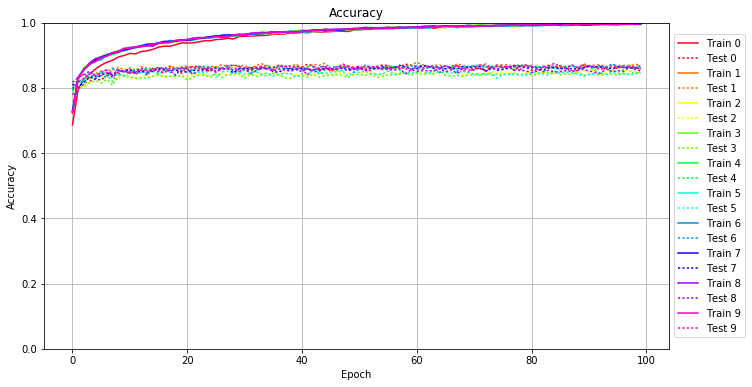

In [17]:
plot_acc(tophistory)

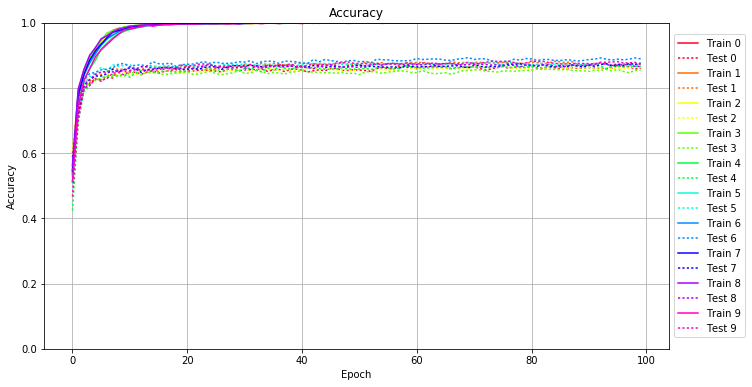

In [18]:
plot_acc(history)

In [19]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Loss.pdf', format='pdf')
    plt.show()

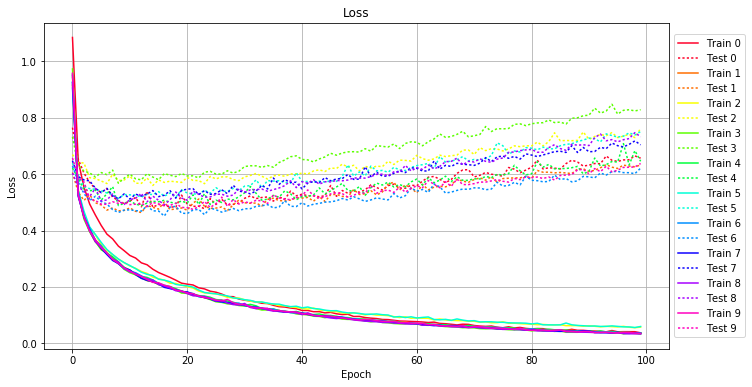

In [20]:
plot_loss(tophistory)

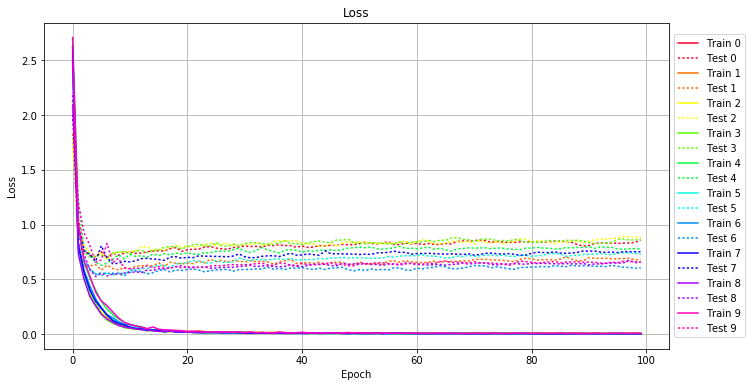

In [21]:
plot_loss(history)

Plotting the confusion matrix


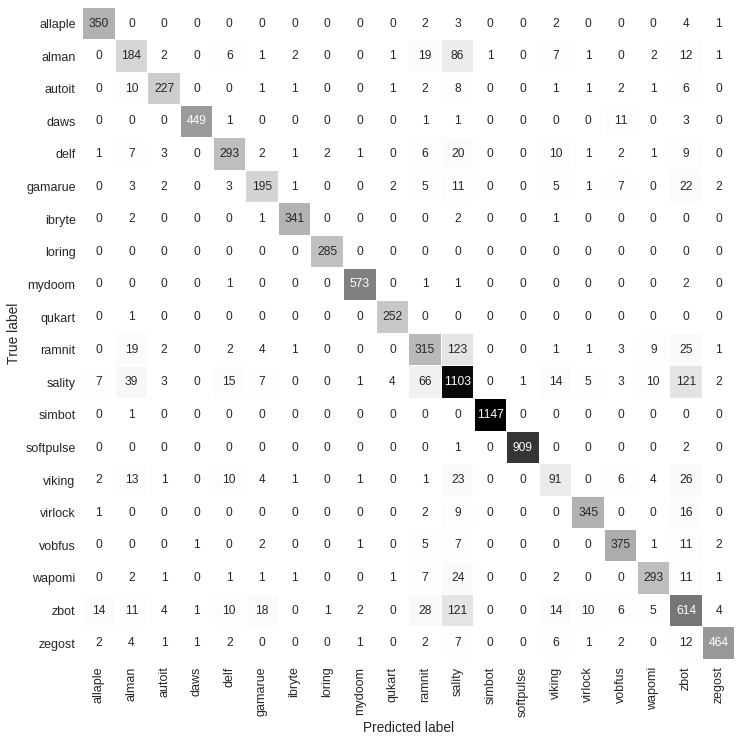

In [22]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 12}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


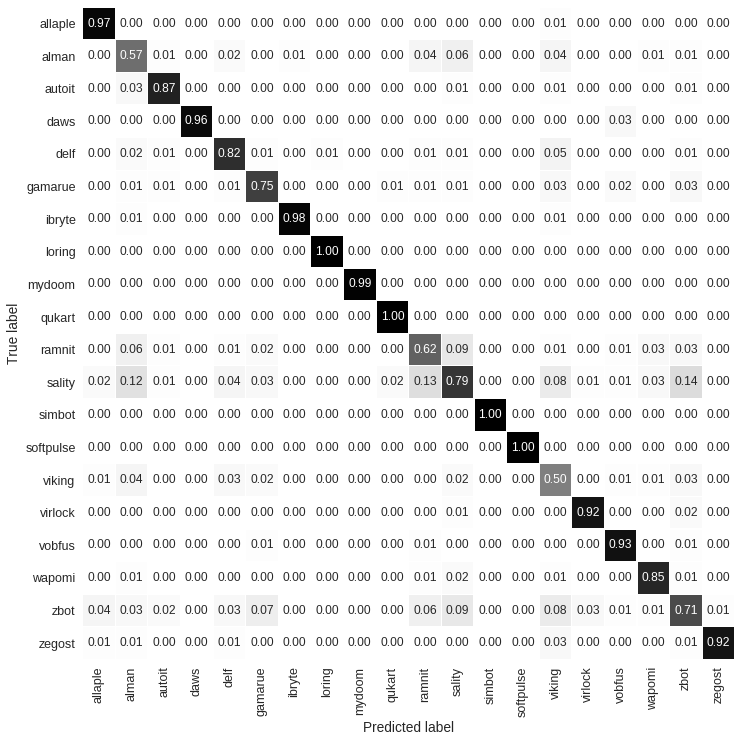

In [23]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 12}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [24]:
for h in tophistory:
    print(h.history)

{'acc': [0.68623792811168505, 0.79642230036805028, 0.82726075515294928, 0.84317383680351998, 0.85766022827041266, 0.86973222129903827, 0.87862159799754991, 0.88454784904267314, 0.89486391571553991, 0.89925373139561426, 0.90572870944653616, 0.90419227392449519, 0.91154521520562715, 0.91341088679508753, 0.91823968403793621, 0.92482440747955164, 0.92800702375733513, 0.92778753297594785, 0.93228709394205445, 0.93777436352906463, 0.93733538196629029, 0.93810359964881473, 0.94106672530220303, 0.94446883236137369, 0.94457857780439802, 0.9480904303065929, 0.94907813871817381, 0.95204126431923142, 0.94995610194838387, 0.95708955234346738, 0.95818700614574193, 0.95862598781317765, 0.9597234416154522, 0.96049165935030734, 0.961369622475856, 0.96422300273855077, 0.96488147503038157, 0.96521071115013168, 0.96872256375698795, 0.96784460063143929, 0.96992976294995614, 0.96894205448604442, 0.97146619841966642, 0.97080772607550481, 0.9717954346964085, 0.97245390693590872, 0.97420983329166755, 0.9736611

In [25]:
for h in history:
    print(h.history)

{'acc': [0.53511852502194912, 0.78391132577665024, 0.84339332758490715, 0.88805970154486802, 0.91933713784021076, 0.94271290605794555, 0.96016242317822653, 0.97574626865671643, 0.98244073754135619, 0.9850746268656716, 0.98770851629464851, 0.98935469710272173, 0.99308604038630377, 0.99440298512695757, 0.99319578577699741, 0.99615891132572432, 0.99550043898156282, 0.99440298507462688, 0.99506145741878838, 0.99593942059666785, 0.99780509218612823, 0.99593942064899854, 0.99758560140474095, 0.99857331002564464, 0.99670763838385368, 0.99780509218612823, 0.99835381913959609, 0.99791483757682176, 0.99714661994662801, 0.99835381913959609, 0.99868305531167689, 0.99835381919192678, 0.99802458296751539, 0.99725636533732154, 0.99835381913959609, 0.99802458296751539, 0.99813432835820892, 0.99824407374890256, 0.99879280080703181, 0.9990122914837577, 0.99780509229078951, 0.99879280075470123, 0.99912203687445122, 0.99857330992098337, 0.99912203687445122, 0.99912203687445122, 0.99868305531167689, 0.9992

In [26]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

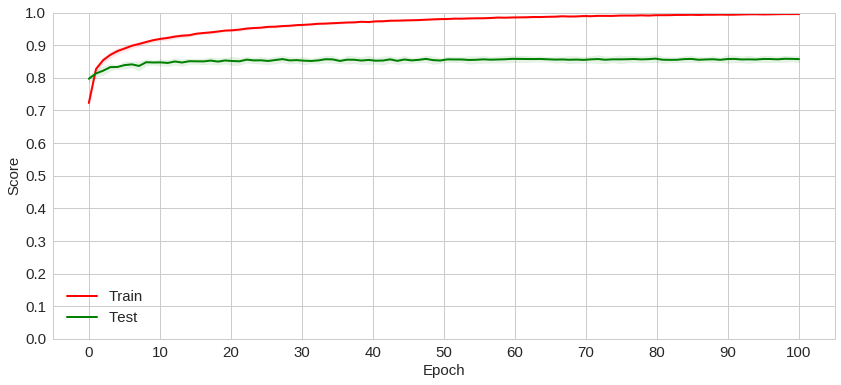

In [27]:
plot_mean_acc(tophistory)

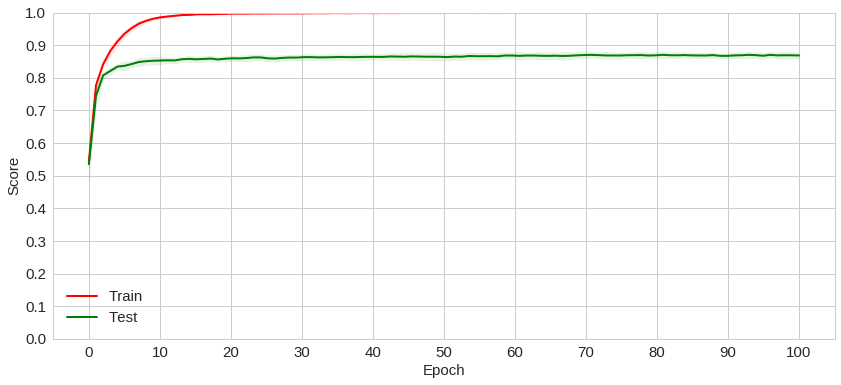

In [28]:
plot_mean_acc(history)

In [29]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

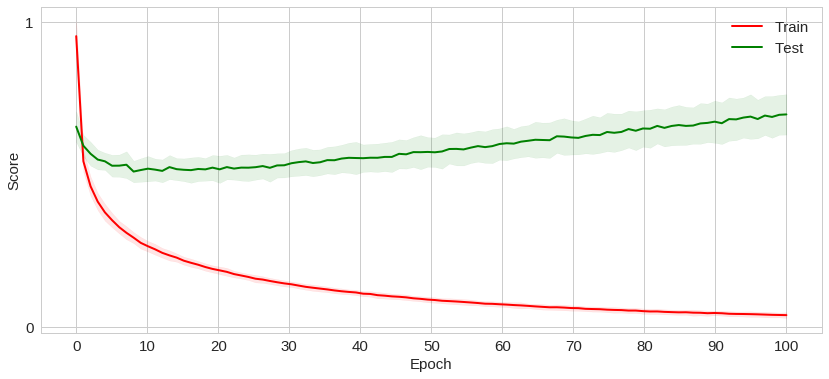

In [30]:
plot_mean_loss(tophistory)

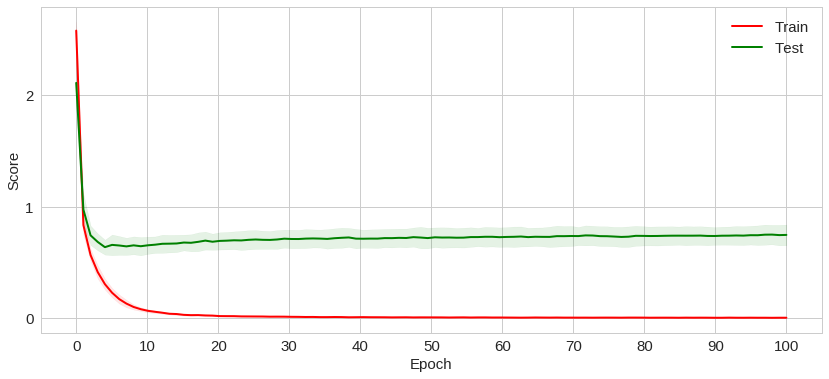

In [31]:
plot_mean_loss(history)

In [33]:
tophistory = [{'acc': [0.68623792811168505, 0.79642230036805028, 0.82726075515294928, 0.84317383680351998, 0.85766022827041266, 0.86973222129903827, 0.87862159799754991, 0.88454784904267314, 0.89486391571553991, 0.89925373139561426, 0.90572870944653616, 0.90419227392449519, 0.91154521520562715, 0.91341088679508753, 0.91823968403793621, 0.92482440747955164, 0.92800702375733513, 0.92778753297594785, 0.93228709394205445, 0.93777436352906463, 0.93733538196629029, 0.93810359964881473, 0.94106672530220303, 0.94446883236137369, 0.94457857780439802, 0.9480904303065929, 0.94907813871817381, 0.95204126431923142, 0.94995610194838387, 0.95708955234346738, 0.95818700614574193, 0.95862598781317765, 0.9597234416154522, 0.96049165935030734, 0.961369622475856, 0.96422300273855077, 0.96488147503038157, 0.96521071115013168, 0.96872256375698795, 0.96784460063143929, 0.96992976294995614, 0.96894205448604442, 0.97146619841966642, 0.97080772607550481, 0.9717954346964085, 0.97245390693590872, 0.97420983329166755, 0.97366110623353819, 0.97289288860334444, 0.9772827042310881, 0.97838015803336265, 0.97914837576821778, 0.97936786654960495, 0.98090430201931522, 0.98189201064021892, 0.98057506584723442, 0.98331870071923555, 0.98331870061457416, 0.98364793678665496, 0.98342844610992919, 0.98419666374012293, 0.98419666374012293, 0.98562335392380096, 0.98276997366110619, 0.98584284460052674, 0.98529411764705888, 0.98737928007023701, 0.98814749780509215, 0.98606233548657529, 0.98694029850746268, 0.98814749780509215, 0.98891571564460867, 0.98924495171202809, 0.98869622475856012, 0.990891132572432, 0.99154960502125489, 0.99001316944688322, 0.99111062335381916, 0.98880597025391515, 0.9918788410886743, 0.99122036874451269, 0.99111062345848056, 0.99165935030728714, 0.99297629499561013, 0.99363476733977174, 0.99231782265144863, 0.99330553127235233, 0.99143985963056125, 0.99319578577699741, 0.99330553116769094, 0.99363476733977174, 0.99374451273046527, 0.99484196663740121, 0.99528094820017554, 0.99198858647936783, 0.99407374890254607, 0.99495171202809485, 0.99484196663740121, 0.99473222124670768, 0.99615891132572432], 'loss': [1.08501629817894, 0.64704095987607979, 0.55354623735945307, 0.49381163551474583, 0.45454715379400146, 0.41829054331025917, 0.38734306333565316, 0.37027231133538868, 0.34474369904469565, 0.32860699293381085, 0.31159991329442627, 0.30244877070999648, 0.28549261986424362, 0.27856218377888675, 0.2628528115987987, 0.25102641835769507, 0.24244328079985566, 0.23371641258067263, 0.22398572398760111, 0.21334278499797524, 0.2097641918039615, 0.20688724509972664, 0.19682152348196852, 0.19298763333756846, 0.18484612537958414, 0.18124992941376197, 0.17474750341083839, 0.16580149756386367, 0.16544273766485404, 0.15690296317947025, 0.15294880206067904, 0.15007856053883198, 0.14656255303295795, 0.14202767958548951, 0.14101537879592393, 0.13480870014905302, 0.12999187050104349, 0.12864940474177788, 0.12515857916479053, 0.12281302807491216, 0.11649653405814551, 0.11645949403636804, 0.11210073058226058, 0.11222008246146764, 0.10782021570613867, 0.10969739820059189, 0.10470999794324518, 0.10201224145382198, 0.10293924100075613, 0.095125231476495722, 0.09537932934129939, 0.091348857400551292, 0.089237689017297742, 0.087702195878820111, 0.084592505000839119, 0.084117796579482165, 0.081577074924145385, 0.079049680823553431, 0.078452272528718711, 0.077559600524519282, 0.0768670898398566, 0.075578818560510061, 0.073760127110686399, 0.075150318993247325, 0.070533516796353196, 0.069421443005629649, 0.067469293514922382, 0.065249947325716526, 0.067780804539899014, 0.06718566027307217, 0.06315132225941314, 0.061077982148023111, 0.060068604040030747, 0.061266536660054154, 0.057157204287736643, 0.055143430515064075, 0.058582815074274368, 0.054510978535406415, 0.05633576807612594, 0.052873686525097427, 0.051084510036813677, 0.052446399063944715, 0.051900013614056717, 0.047801987743095097, 0.047668229674068432, 0.047455595722839014, 0.046235237561683053, 0.049570149024973011, 0.046070002977710946, 0.045989349578475357, 0.04424222710005174, 0.043315229641438788, 0.042151338691456049, 0.040732385067365692, 0.045245775990547896, 0.040787070047656519, 0.041288503881501355, 0.041247774811692152, 0.041161627800606969, 0.037150687233097619], 'val_acc': [0.779296875, 0.7978515625, 0.8115234375, 0.8203125, 0.8271484375, 0.82421875, 0.837890625, 0.8427734375, 0.8427734375, 0.8515625, 0.8583984375, 0.83984375, 0.857421875, 0.841796875, 0.859375, 0.8623046875, 0.859375, 0.8662109375, 0.85546875, 0.8447265625, 0.86328125, 0.865234375, 0.8662109375, 0.861328125, 0.849609375, 0.865234375, 0.8583984375, 0.8671875, 0.8701171875, 0.8662109375, 0.8583984375, 0.85546875, 0.859375, 0.8671875, 0.8671875, 0.86328125, 0.8701171875, 0.8662109375, 0.8583984375, 0.8681640625, 0.8642578125, 0.873046875, 0.865234375, 0.8603515625, 0.8681640625, 0.849609375, 0.8642578125, 0.8671875, 0.8662109375, 0.86328125, 0.8662109375, 0.8583984375, 0.8525390625, 0.865234375, 0.8701171875, 0.8681640625, 0.861328125, 0.8642578125, 0.873046875, 0.869140625, 0.8662109375, 0.857421875, 0.865234375, 0.8642578125, 0.861328125, 0.859375, 0.8671875, 0.8681640625, 0.853515625, 0.84765625, 0.859375, 0.8583984375, 0.853515625, 0.8642578125, 0.8701171875, 0.8671875, 0.8642578125, 0.853515625, 0.8662109375, 0.8701171875, 0.8544921875, 0.849609375, 0.8642578125, 0.8603515625, 0.8642578125, 0.8681640625, 0.8623046875, 0.8515625, 0.8525390625, 0.8701171875, 0.865234375, 0.865234375, 0.865234375, 0.8564453125, 0.8525390625, 0.86328125, 0.8623046875, 0.8642578125, 0.8603515625, 0.859375], 'val_loss': [0.76519172685220838, 0.65326221520081162, 0.6038339679944329, 0.57106681261211634, 0.54745047749020159, 0.53545539727201685, 0.54844205779954791, 0.51860964435036294, 0.50620824728684966, 0.49558174255071208, 0.50442328557255678, 0.51755155522550922, 0.48430947297310922, 0.5389844135788735, 0.48280421759409364, 0.4926337068900466, 0.48853534825320821, 0.48410067585791694, 0.48270915851753671, 0.52581484016263857, 0.49365859664249001, 0.48578437833566568, 0.48665250884369016, 0.47733042282561655, 0.51343932860982022, 0.49245169699497637, 0.51122351279263967, 0.49070859874700545, 0.49290926755202236, 0.49772210164155695, 0.51450427087911521, 0.52296754463895923, 0.51339028434267675, 0.51729270760915824, 0.51908105754046119, 0.5046006912834855, 0.51901181895664195, 0.51141591992745816, 0.53983997166506015, 0.52322046436893288, 0.52892689345208055, 0.52329681789888127, 0.52300632835704164, 0.51990853273218818, 0.5236699275810679, 0.56007477103139536, 0.52137435188160453, 0.5421533620747141, 0.53223344799152983, 0.54096481100532401, 0.53599872167433205, 0.54453924857853053, 0.56228743616065913, 0.55248350349665998, 0.54388275351857374, 0.55933953898193067, 0.56465187328831234, 0.55020040002909809, 0.55007361449133896, 0.56083761442368996, 0.55927432329713156, 0.57537011476370026, 0.5892568432977896, 0.59194255821762454, 0.58180082296030378, 0.56969332282687901, 0.58127790890785036, 0.60283626063687734, 0.6150191857768732, 0.61596404944384631, 0.59016065223113401, 0.5960453513257562, 0.60623310407231656, 0.59984435100443534, 0.59710699103004572, 0.59249571639770693, 0.62374437615403622, 0.61763069680375793, 0.60515553982520487, 0.61452462013039622, 0.62488296251615338, 0.6498605979701324, 0.61846753817064837, 0.62277883130707323, 0.6214402138857622, 0.61850661699662624, 0.63750196282705929, 0.64968254846871787, 0.64314908499670764, 0.62873234103824416, 0.63195102210579535, 0.63789496477278362, 0.63702132082642038, 0.66456650003135564, 0.64932573878525091, 0.64523638312721232, 0.65051212762341493, 0.65120912724967184, 0.66496036252857493, 0.65678845378215556]},
{'acc': [0.72536756651218925, 0.8323458417455486, 0.85703313601809639, 0.87305244696828288, 0.88709677429818679, 0.8928022824909595, 0.90125082309292626, 0.90476190494502196, 0.91156462603345734, 0.914856265204398, 0.92001316655694532, 0.92319508466852429, 0.92835198613878978, 0.9321922317314022, 0.93043669109311, 0.93647136273864384, 0.93778801852473836, 0.93943383805134961, 0.94162826431354774, 0.94283519877868449, 0.94952819855924186, 0.94656572324653609, 0.95249067378038899, 0.95249067387194752, 0.95600175572404322, 0.95797673917428849, 0.95600175563248468, 0.95995172262453365, 0.95951283739302173, 0.9642308536317753, 0.96302391933667597, 0.96324336204399053, 0.96719332903603961, 0.96576695212518437, 0.96949747640991879, 0.96434057504429171, 0.97037524696450128, 0.97224050910686854, 0.97224050921150695, 0.97388632881659698, 0.97728768936081467, 0.97608075488259816, 0.97608075497415681, 0.97739741057713403, 0.97443493526442837, 0.97608075497415681, 0.97772657459232659, 0.97915295151626169, 0.97871406627167001, 0.98167654158437567, 0.9794821155183745, 0.9803598858898398, 0.9822251481237656, 0.98365152523081789, 0.98233486943164361, 0.98233486943164361, 0.98211542681588759, 0.98365152512617948, 0.98211542690744624, 0.98584595137529785, 0.98639455782312924, 0.98551678736010528, 0.98793065622497966, 0.98628483651525123, 0.98551678745166393, 0.98880842659644508, 0.98891814790432297, 0.9884792627643697, 0.98869870528856707, 0.98825982005705504, 0.99045424630617351, 0.98891814799588162, 0.98990563967522494, 0.98913759061163764, 0.9911125740618828, 0.99166118060127273, 0.98968619705946892, 0.99023480359885885, 0.99089313153768543, 0.99078341013824889, 0.99100285275400479, 0.99330700021944263, 0.99341672152732063, 0.99363616414307654, 0.99363616414307654, 0.9939653281582691, 0.99264867237217469, 0.99341672161887917, 0.99484309852973452, 0.99319727900312327, 0.99352644283519864, 0.99352644283519864, 0.99495281983761241, 0.99451393460610049, 0.99572086899275836, 0.99506254114549042, 0.99506254114549042, 0.99583059030063636, 0.99583059030063636, 0.99473337722185651], 'loss': [0.91540867292962103, 0.52935258921547268, 0.45182319047591235, 0.396884535053254, 0.35989061716697918, 0.34015524890931886, 0.31836777496473923, 0.30153233596688434, 0.28408101275612291, 0.26883557838438266, 0.25864429616577561, 0.24441145824475694, 0.23391606287394329, 0.22258781317914947, 0.21868416220309417, 0.20920685507538603, 0.20367750471193383, 0.1965255912132553, 0.19083868912471239, 0.18611280536714395, 0.17665930597868984, 0.176073979086878, 0.1666488249311851, 0.16255314456859335, 0.15835424478617263, 0.1523115079255645, 0.15267127053842802, 0.14444420740436717, 0.13997254658973554, 0.13520822023806511, 0.13460316988546545, 0.13156028692597277, 0.12483982592559525, 0.12384652670261131, 0.11871530258501206, 0.12095757232623741, 0.11684104324283112, 0.11087165312587705, 0.11192820266474489, 0.10703081766620445, 0.1028398106776755, 0.10194807406780566, 0.099602209071802256, 0.097551697660347908, 0.098568570830168262, 0.096222083346085618, 0.092657701170167195, 0.088371557688566582, 0.090374369300952578, 0.086371045822058165, 0.08599534039078037, 0.084851625923370616, 0.080158146512313497, 0.078268484317709636, 0.078979758308276235, 0.076735163302485143, 0.078220028816077536, 0.07548284678604876, 0.076708938668949816, 0.071301145299644569, 0.068755670682181122, 0.069752087998486992, 0.066997831494812907, 0.067050999201734462, 0.066868611289948934, 0.061748015732946485, 0.061630146624959824, 0.062931455225439109, 0.060294076501963459, 0.061424010665218687, 0.058011599115590819, 0.056820556753582142, 0.058248544932196535, 0.056397338570903892, 0.053397338511207683, 0.05214883664380518, 0.0552116841117044, 0.052812672844117795, 0.04942838861861458, 0.049975224864003506, 0.048237863789924229, 0.047090284896669929, 0.047811314046901192, 0.045942214256921354, 0.045464727423050202, 0.044246206631884388, 0.044363592862298094, 0.046370022311979987, 0.043307503427437895, 0.043691095402098444, 0.041341194472201484, 0.041900572179603503, 0.041269018494012925, 0.039220745616815433, 0.037601662192731568, 0.038971946407775751, 0.038981618686679924, 0.035897855279652051, 0.035246615157280149, 0.035643756445207064], 'val_acc': [0.80626222753711407, 0.82681017635853093, 0.84246575179165362, 0.83072407161652928, 0.84344422630601201, 0.85225048760378663, 0.85322896118499991, 0.85420743383306819, 0.86301369699713304, 0.85518590741428147, 0.86105675076785149, 0.85420743383306819, 0.86497064229326937, 0.86007827532034797, 0.85909980173913469, 0.85714285364356291, 0.8493150677932918, 0.86790606397005443, 0.86105674890156125, 0.86497064229326937, 0.86692759132198627, 0.86301369606398792, 0.86301369606398792, 0.86301369513084281, 0.86594911774077299, 0.8639921696452012, 0.87084148471369438, 0.86692758945569603, 0.86888453661812259, 0.86594911774077299, 0.86888453848441283, 0.85909980080598958, 0.86888453755126771, 0.8737769045241891, 0.86790606303690931, 0.85616438099549474, 0.86888453755126771, 0.86790606490319955, 0.8639921696452012, 0.87377690545733433, 0.85420743383306819, 0.86497064229326937, 0.87279843187612094, 0.86888453661812259, 0.87573385168661577, 0.85909980080598958, 0.86497064229326937, 0.86497064322641448, 0.86692759038884115, 0.86105674983470637, 0.86399216871205609, 0.86007827532034797, 0.86399216871205609, 0.85812132722477619, 0.86007827438720286, 0.86692759132198627, 0.86203522154962942, 0.86301369513084281, 0.85909980360542493, 0.87181995829490766, 0.87769079884904233, 0.87084148471369438, 0.86692759038884115, 0.86888453661812259, 0.86986301019933587, 0.86497064229326937, 0.85812132722477619, 0.87475537810540249, 0.86790606397005443, 0.86497064229326937, 0.86888453661812259, 0.86888453848441283, 0.8737769045241891, 0.86301369606398792, 0.86692758945569603, 0.87084148471369438, 0.87084148471369438, 0.86203522154962942, 0.86497064322641448, 0.86986301019933587, 0.86497064322641448, 0.86594911774077299, 0.86203522248277464, 0.86986301019933587, 0.86692758945569603, 0.86399217057834632, 0.86203522154962942, 0.8698630111324811, 0.86105674796841614, 0.8737769045241891, 0.86888453755126771, 0.86986301019933587, 0.87084148471369438, 0.86497064229326937, 0.8698630111324811, 0.86888453661812259, 0.86888453755126771, 0.86888453661812259, 0.87084148378054926, 0.87279843094297582], 'val_loss': [0.60584522051820555, 0.53606066134723662, 0.50711889231829033, 0.52656700455541716, 0.49831258038281229, 0.49094378254184984, 0.47250521739255891, 0.48038240794799564, 0.47006751123793905, 0.47129954849670547, 0.48040664784333242, 0.46823417694251362, 0.46412118635123956, 0.48892363636898434, 0.48244205407739971, 0.47604673788490942, 0.50153821089656736, 0.47377614680961971, 0.47675630274372732, 0.48008227994603536, 0.47212437079187825, 0.49696243173987725, 0.51188649226220617, 0.48634178642777692, 0.47862420899250385, 0.47968210170679743, 0.48359312012849953, 0.47099115109935025, 0.49115749999312153, 0.50824229149129641, 0.49841824238718929, 0.49679105136900731, 0.49758039062583925, 0.48717351651334961, 0.51037012885548827, 0.51469993223746013, 0.50621349454963116, 0.50522642048556943, 0.50821610372477077, 0.51625275480653909, 0.51513721054481842, 0.51754946474108021, 0.50436362293740244, 0.52047532767790083, 0.50298417134186779, 0.52761815561240433, 0.52829691683445235, 0.52119731741256592, 0.51972805074445261, 0.5456301953193391, 0.52790938983188396, 0.53047634825067602, 0.54133941066554347, 0.52620703424987747, 0.53699143809597183, 0.56505781828622659, 0.5714932149412828, 0.54368148813841577, 0.56230952628476294, 0.55034891438443545, 0.53372609305082508, 0.56408809971484886, 0.54425546866563679, 0.55404756093714858, 0.55729273675064739, 0.55500946083600922, 0.56253496184011054, 0.58180681728587513, 0.57521025667039027, 0.57129296984016864, 0.58087197169246896, 0.58713704146059331, 0.57868076267129598, 0.59107156938921301, 0.57142766439698778, 0.58437079487127208, 0.5856404006383209, 0.58686650382129768, 0.58692521110977591, 0.59211055366713672, 0.58505646485832807, 0.61319618896613581, 0.60678621655760756, 0.60718441888434382, 0.60471983026356479, 0.60607282338896196, 0.60441302167227895, 0.60197663167690896, 0.61848261094107748, 0.61890823811272944, 0.60973295981210585, 0.61365242784675633, 0.62273261101630295, 0.63386270194398431, 0.62489879492169043, 0.62026201626379029, 0.63207496109508221, 0.62877790589930693, 0.62631306863255809, 0.63234025831284746]},
{'acc': [0.73332602013198367, 0.82678806514999437, 0.86167178592330373, 0.87483545430347864, 0.88064940779185075, 0.8963361125392002, 0.90302764380799416, 0.90752523041650257, 0.91641070650250522, 0.91684949549733152, 0.92288284335234749, 0.92244405446213662, 0.92759982464134616, 0.92990346648495359, 0.9360465117325224, 0.93516893374286969, 0.93703378695780482, 0.94218955687547579, 0.93988591492725282, 0.94405440993348777, 0.94383501540992065, 0.94668714353629191, 0.95239139978903431, 0.95524352786309785, 0.95458534444931986, 0.95513383067977586, 0.95645019750733185, 0.9598508118641591, 0.95864414221992511, 0.95974111457622169, 0.96358051792787536, 0.96467749012724879, 0.9652259763577048, 0.96456779294392681, 0.96621325147837178, 0.96763931548924964, 0.96928477402369462, 0.96884598508117592, 0.9721369022546813, 0.97158841602422519, 0.97279508561615147, 0.97553751645458531, 0.97158841597191747, 0.97553751650689302, 0.97465993862185574, 0.97838964463326428, 0.97860903905221586, 0.98003510316770925, 0.98025449763896855, 0.97860903915683128, 0.98003510316770925, 0.98069328658148713, 0.97915752523036415, 0.98036419482229042, 0.98124177286425096, 0.98069328652917942, 0.98365511189118038, 0.98541026776587037, 0.98354541465555068, 0.98661693725318123, 0.98508117595436595, 0.98551996489688465, 0.98475208424747696, 0.98683633177674823, 0.98453268982852538, 0.98606845112734065, 0.98760421247846364, 0.98749451513821851, 0.9878236068451075, 0.98979815713874919, 0.98837209302325579, 0.99012724879333036, 0.98903027643703378, 0.99155331290882376, 0.99045634055252707, 0.98935936814392278, 0.99210179903466433, 0.99056603778815677, 0.99056603773584906, 0.99254058797718292, 0.99199210185134234, 0.99330846867889833, 0.99254058797718292, 0.99144361562088634, 0.99254058802949074, 0.99275998244844232, 0.99451513821851689, 0.99308907415533132, 0.99199210179903463, 0.9938569548047389, 0.99243089074155333, 0.99473453268977619, 0.99594120228170246, 0.99484422992540589, 0.9941860465116279, 0.99473453268977619, 0.99363756033347961, 0.99528301886792447, 0.99550241333918388, 0.99363756033347961], 'loss': [0.94288430788266964, 0.54731720471497214, 0.45610984921219999, 0.41003218675036346, 0.3845446403741104, 0.35152473131676104, 0.33021921926341907, 0.31463494257426877, 0.29876542868793088, 0.28639624380605061, 0.27436751114166114, 0.26591670619076208, 0.25483789862169931, 0.24786723477372793, 0.23479031758017579, 0.22904952647864896, 0.22395158295256887, 0.2130581493726055, 0.21235888756357196, 0.20681327013866899, 0.20074148418585319, 0.19603958263005955, 0.18520649512408333, 0.17898385808649897, 0.17739780940615643, 0.17548192908702162, 0.17022643565556206, 0.16327483165468129, 0.16074098224255953, 0.16065325762891833, 0.15427007311370719, 0.14931338556035667, 0.14663217877441981, 0.14589076516344757, 0.14110349280863491, 0.13887925093283304, 0.13362931078949639, 0.13314164388383778, 0.12877866464939594, 0.12687469737055845, 0.12347560973217635, 0.12130204341347775, 0.12518140989772161, 0.11837430089751373, 0.11639529357109743, 0.11245631337322756, 0.11278317282536199, 0.10757298850605183, 0.10597967779155153, 0.10762897634019764, 0.10555144658000808, 0.10049466034229934, 0.10306883305997742, 0.099966312828504392, 0.099652754248313186, 0.098056386762305589, 0.094780066626382636, 0.091310006843004485, 0.093969965056925286, 0.088936643375017596, 0.089998688318322445, 0.088924796402637452, 0.088657347520567337, 0.083125930153627889, 0.086260819033657898, 0.083053120660802782, 0.081420440476889566, 0.080580219391041971, 0.080396545510665524, 0.078549330108465987, 0.078014705447825808, 0.074639192762318382, 0.07606078530676065, 0.072880351056964734, 0.073187432189346563, 0.076301823407346189, 0.070985072515103942, 0.07127104910804076, 0.069659286577903476, 0.068659577059374408, 0.067642700752572768, 0.065989948933377715, 0.06693127103552006, 0.065598848590912556, 0.065278522127576441, 0.065959532361456366, 0.062517268065822501, 0.062640371630658914, 0.062894107755101944, 0.060469275215389751, 0.0623663778483423, 0.060316906415642017, 0.058397209275875141, 0.06016315440694299, 0.059213468862984356, 0.058049720732847448, 0.060172848897925221, 0.056896043893157416, 0.055301981799536604, 0.057299423055619511], 'val_acc': [0.79215686695248477, 0.80392157283483767, 0.80000000327241183, 0.82647058963775633, 0.83431372782763313, 0.83529411998449588, 0.83333333730697634, 0.83137255299325086, 0.82843137582143145, 0.83823529902626481, 0.82745098436579989, 0.83235294351390765, 0.83137255042207003, 0.83431372782763313, 0.83529412162070182, 0.83823529552010934, 0.83725490429822136, 0.83725490780437695, 0.83725490593442731, 0.83921569024815279, 0.8323529451501136, 0.83921568767697208, 0.84313725794062899, 0.84019607983383482, 0.83627451377756457, 0.84313725794062899, 0.84117647362690351, 0.84019608076880958, 0.84117647362690351, 0.84019608240501553, 0.84019608333999041, 0.84117647549685315, 0.83823529715631517, 0.84705882493187401, 0.8421568641475603, 0.8480392187249427, 0.83627451377756457, 0.84803921965991746, 0.84117647456187827, 0.84019608240501553, 0.84117647362690351, 0.83823529809129005, 0.8421568641475603, 0.84607843441121722, 0.84019608240501553, 0.84313725887560376, 0.84411764846128579, 0.84607843441121722, 0.84607843628116686, 0.8421568641475603, 0.84607843534619198, 0.84803921965991746, 0.84901961088180544, 0.84019608240501553, 0.84313725630442304, 0.83627451214135862, 0.84705882750305472, 0.84313725887560376, 0.84607843534619198, 0.84901961181678021, 0.84803921965991746, 0.84607843441121722, 0.85000000397364295, 0.84803921965991746, 0.84901961181678021, 0.84509804061814853, 0.85098039519553093, 0.84705882493187401, 0.84117647199069756, 0.84411764846128579, 0.84509804225435448, 0.83823529809129005, 0.84509804318932924, 0.8480392187249427, 0.84901961181678021, 0.84705882750305472, 0.84803921965991746, 0.84607843534619198, 0.85196078828736843, 0.84901961181678021, 0.84509804061814853, 0.84607843277501127, 0.84803921965991746, 0.84901961088180544, 0.84313725630442304, 0.84803921965991746, 0.84803921965991746, 0.85000000397364295, 0.84705882750305472, 0.85098039613050569, 0.84901961181678021, 0.85392157260109391, 0.84313725794062899, 0.85000000303866818, 0.85392157166611915, 0.84901961181678021, 0.8539215700299132, 0.85098039613050569, 0.85000000397364295, 0.84411765009749173], 'val_loss': [0.66970993886683505, 0.64048828886748821, 0.6397638018882158, 0.5874822095682497, 0.58432413700045838, 0.575899733013163, 0.56663907725437013, 0.60025616619626387, 0.57738633431749897, 0.57926980129685068, 0.5937041530276046, 0.56800939920997506, 0.56731301441368664, 0.58677604135271966, 0.55995207715587803, 0.57959692728130474, 0.5707095987291313, 0.57514853637628993, 0.57305670135572329, 0.57087667465675618, 0.58838720616848006, 0.57805153837372714, 0.57719082483832318, 0.56630008790868003, 0.59204280460550107, 0.58314905662053063, 0.59032938457379469, 0.59047986612194125, 0.58074920852120748, 0.57721299476026755, 0.59048595831811646, 0.59536947705919907, 0.60266049020197787, 0.59263975147965964, 0.58269181644073775, 0.59390361677380465, 0.59702925148771568, 0.59235133915408011, 0.60068974444487444, 0.6013231767566336, 0.60325140585225789, 0.60069225800826265, 0.61137106858922041, 0.61554563493809122, 0.60948858682275064, 0.62215702872621759, 0.61993642577572783, 0.6355120196637204, 0.62526347567335883, 0.63156494840536737, 0.61167239017354313, 0.62789742807148929, 0.62187202289590937, 0.62859018407453893, 0.62676713909227943, 0.64588110628751827, 0.63450059360311217, 0.64996615996591145, 0.64885361135101827, 0.64661496087286574, 0.66694112384793702, 0.65513908057008508, 0.64945486148626153, 0.65438844121977746, 0.66739818947609431, 0.6625778931361328, 0.66556217537196494, 0.66760064212749592, 0.68546922493705476, 0.68572997402790115, 0.66976938848922285, 0.69398127689515499, 0.6835876711990625, 0.69053677190487517, 0.68938034750332433, 0.68236028524224113, 0.68958180467355612, 0.70050254504867726, 0.69756485410414149, 0.70077208595457174, 0.70046788686185946, 0.71380430063458622, 0.70021569064917333, 0.71581106446235432, 0.74674534406169146, 0.71851271356156166, 0.71965887230675718, 0.71878943801445228, 0.72006333316863214, 0.74981968871948346, 0.72338957156091199, 0.73383412765242784, 0.74071447998472717, 0.73665087084613257, 0.74741099072431882, 0.72974175538748198, 0.7348307484893738, 0.74120341011862811, 0.72971780101504602, 0.76262192628757974]},
{'acc': [0.7221491228070176, 0.83004385964912286, 0.86118421052631577, 0.87467105263157896, 0.88859649122807016, 0.89572368421052628, 0.90208333333333335, 0.90460526315789469, 0.91140350877192977, 0.91885964912280704, 0.92335526315789473, 0.92500000000000004, 0.93004385964912284, 0.93355263157894741, 0.93289473684210522, 0.93629385964912282, 0.93662280701754386, 0.93859649122807021, 0.94342105263157894, 0.94747807017543861, 0.94813596491228069, 0.95230263157894735, 0.94846491228070173, 0.95438596491228067, 0.95581140350877192, 0.96019736842105263, 0.95986842105263159, 0.96217105263157898, 0.96239035087719293, 0.96589912280701751, 0.96370614035087721, 0.96469298245614032, 0.96798245614035083, 0.97236842105263155, 0.97028508771929822, 0.96809210526315792, 0.97050438596491229, 0.9709429824561403, 0.97324561403508769, 0.97499999999999998, 0.974890350877193, 0.97554824561403508, 0.97861842105263153, 0.97741228070175434, 0.98070175438596496, 0.97675438596491226, 0.97850877192982455, 0.98157894736842111, 0.98070175438596496, 0.98015350877192986, 0.98070175438596496, 0.98399122807017547, 0.98530701754385963, 0.98442982456140349, 0.98497807017543859, 0.98541666666666672, 0.9866228070175439, 0.98739035087719296, 0.98629385964912286, 0.98563596491228067, 0.98574561403508776, 0.98837719298245619, 0.98793859649122806, 0.98651315789473681, 0.98925438596491233, 0.98969298245614035, 0.99035087719298243, 0.99035087719298243, 0.99046052631578951, 0.9916666666666667, 0.9916666666666667, 0.99396929824561409, 0.9916666666666667, 0.99111842105263159, 0.99298245614035086, 0.9922149122807018, 0.99276315789473679, 0.993859649122807, 0.99177631578947367, 0.99276315789473679, 0.99418859649122804, 0.99243421052631575, 0.99364035087719293, 0.9933114035087719, 0.99528508771929824, 0.99342105263157898, 0.99528508771929824, 0.99616228070175439, 0.99649122807017543, 0.99232456140350878, 0.99353070175438596, 0.99320175438596492, 0.99495614035087721, 0.99429824561403513, 0.99649122807017543, 0.99429824561403513, 0.99703947368421053, 0.99550438596491231, 0.99561403508771928, 0.99649122807017543], 'loss': [0.97324176859437372, 0.5296110174112153, 0.4406056709456862, 0.39556832658617119, 0.36042665996049578, 0.33182545591864671, 0.31959202561462136, 0.29854131173669246, 0.2839951331155342, 0.26225759810522981, 0.25038604935010272, 0.24273729196243118, 0.23151243114680575, 0.22307280343875549, 0.21919841850013064, 0.20818663453846648, 0.20297368822390574, 0.20030204465514737, 0.18964519532103288, 0.1783160268214711, 0.17702856565776623, 0.16962224671192336, 0.1697505551210621, 0.16175588392897655, 0.15500904018418832, 0.1471848980115171, 0.14513415160932039, 0.13987023655259817, 0.13958752050734402, 0.13391710334179693, 0.13215173286826987, 0.13087159546843746, 0.12341517968135968, 0.11802050403335639, 0.1185570218061146, 0.11837413274405295, 0.1134073093533516, 0.11257213296597464, 0.11024733630188724, 0.10427771255112531, 0.10270364336800157, 0.10149253656466801, 0.09598232442349719, 0.095374412782359544, 0.090858184167167594, 0.094784002319762584, 0.09039616158656906, 0.085685707654869353, 0.084707611851524894, 0.084850571709766717, 0.082990177969137824, 0.078851585168587535, 0.076172746417292381, 0.078392395984969637, 0.073683362362677585, 0.072610240246643101, 0.070095472625995942, 0.069027650330150334, 0.068953212429034086, 0.070508609084706561, 0.068112954268591444, 0.064429216635854616, 0.063726522838860225, 0.065834314166976701, 0.061438536552483575, 0.059012344427276077, 0.058496801411373575, 0.057641337223743136, 0.055230324375524859, 0.055646205052994842, 0.054668201074788446, 0.052039117843174096, 0.051334338412995922, 0.052957250779135184, 0.050076756142733388, 0.050093536572367474, 0.04811720172302765, 0.047931047045347987, 0.048527259948222261, 0.047047308976190132, 0.044051585405280716, 0.046148215704842614, 0.042956475795883881, 0.044775544551380893, 0.042092137512538513, 0.043479741887565246, 0.039105582361419998, 0.039134320688613673, 0.039054785289785315, 0.043766883528676997, 0.041734937630724486, 0.040653907961882001, 0.038299049123337398, 0.040737482598214816, 0.035632225498557088, 0.037774438241071871, 0.033771288479890742, 0.035624697941698528, 0.035424398879210152, 0.033069237524218725], 'val_acc': [0.78838582677165359, 0.79921260030250851, 0.80905511811023623, 0.81594488188976377, 0.82185039417011529, 0.81496063555319476, 0.82578740251345895, 0.80807086942702766, 0.83661417651364178, 0.83956693194982579, 0.83464567492327357, 0.82874015748031493, 0.83070866470261817, 0.82972441273411424, 0.83562992407580994, 0.84055118438765763, 0.83267716582365858, 0.83562992407580994, 0.83562992125984248, 0.83759842801281781, 0.82381890045376271, 0.83267716817029813, 0.83956692960318613, 0.83858267716535428, 0.83366141826149043, 0.84350393982384153, 0.83169291385515465, 0.84055118391832973, 0.84055118391832973, 0.8454724437608494, 0.82874016311224985, 0.84251968550869794, 0.83464567022999436, 0.83956693194982579, 0.83661417604431387, 0.84448819226167338, 0.83956692960318613, 0.83169291385515465, 0.82874016029628239, 0.83759842566617826, 0.83661417604431387, 0.83366142060812998, 0.84153543635616157, 0.83366141732283461, 0.83759842801281781, 0.83858268045064976, 0.84055118391832973, 0.83858267998132185, 0.83169291667112211, 0.84055118438765763, 0.84153543588683366, 0.83858267763468219, 0.84251968832466551, 0.83169291667112211, 0.83562992454513785, 0.84055118438765763, 0.83858268045064976, 0.84153543635616157, 0.84547244423017731, 0.83858267763468219, 0.84547244423017731, 0.8395669324191537, 0.84448818944570592, 0.84251968550869794, 0.85039370407269699, 0.83858268045064976, 0.83661417651364178, 0.83858267763468219, 0.83562992172917039, 0.8395669324191537, 0.84055118438765763, 0.83858267763468219, 0.84547244423017731, 0.83759842801281781, 0.84350394029316944, 0.84055118438765763, 0.84350394029316944, 0.84055118157169006, 0.8395669324191537, 0.84448818944570592, 0.8395669324191537, 0.84055118157169006, 0.84744094535121772, 0.84547244141420985, 0.84645669619868125, 0.84055118157169006, 0.84251968832466551, 0.84153543635616157, 0.84940945210419305, 0.83759842848214583, 0.84153543635616157, 0.84251968550869794, 0.83956692960318613, 0.841535433540194, 0.841535433540194, 0.83956692960318613, 0.84350394029316944, 0.84251968832466551, 0.84842520013568912, 0.84350394029316944], 'val_loss': [0.73255460780007609, 0.63048639364804571, 0.61110403701135019, 0.60459030889649323, 0.58986601314881415, 0.60581151860047455, 0.59817269092469705, 0.61439444691925416, 0.56772567039606803, 0.58567635770740467, 0.59988676734803992, 0.58342083400724032, 0.57993449904317929, 0.60199263381705748, 0.58976215737556492, 0.58026004771107997, 0.60216422652547053, 0.59628869199989676, 0.5914564572227019, 0.60260248344435585, 0.5938157673148754, 0.59408959070968581, 0.5867192033920291, 0.60707708428646845, 0.6101317274481366, 0.60034981605277848, 0.60006353840429894, 0.61203657731498173, 0.60373320675172704, 0.61074987521663671, 0.62711959076893153, 0.62976115410203315, 0.62956973924975312, 0.62417615210366117, 0.63064381763761623, 0.62462381089122698, 0.64145114135930281, 0.65034043845123846, 0.66187726612469566, 0.66512050080446772, 0.65223277299747418, 0.65071146056655516, 0.64366261176210393, 0.65391461092643677, 0.66122336592891906, 0.67399920381932876, 0.6672637577562347, 0.675010027803433, 0.67914232465208924, 0.67974989142224895, 0.67841686852350569, 0.69034855924379424, 0.68161717995872451, 0.70148415657219065, 0.69869390436664491, 0.69627412422030788, 0.70728745105377067, 0.6910251120665577, 0.709081288040744, 0.71486684646850795, 0.71307111488092378, 0.70078401357229059, 0.7152304310159342, 0.72497304797425888, 0.74267020088406899, 0.73079976144123693, 0.73347173343762284, 0.74125243387884909, 0.75223876158138514, 0.73244105271426341, 0.73642180798841461, 0.74099743646894334, 0.76918633422702254, 0.75132805190478968, 0.76171657573674356, 0.76061002952796064, 0.76227821923426442, 0.77675754789032103, 0.77845116815182347, 0.77215574043446855, 0.77879885033503593, 0.78180787379553629, 0.78264306315925458, 0.79233497444675871, 0.78301573283798764, 0.78474650761495646, 0.77796488168597555, 0.79847975223675871, 0.80005551457180968, 0.80728977382402556, 0.80943632548734434, 0.83422294996147339, 0.81659813601589937, 0.82401582922454153, 0.84802706935041228, 0.8131345891158599, 0.82656624216274144, 0.82866365967677091, 0.82433868633411544, 0.82880401801727621]},
{'acc': [0.72719298245614039, 0.83157894736842108, 0.85438596491228069, 0.87236842105263157, 0.88662280701754381, 0.89122807017543859, 0.90021929824561409, 0.90175438596491231, 0.90855263157894739, 0.91436403508771935, 0.918530701754386, 0.92565789473684212, 0.92686403508771931, 0.92982456140350878, 0.92960526315789471, 0.93640350877192979, 0.93991228070175437, 0.93991228070175437, 0.943640350877193, 0.94692982456140351, 0.94660087719298247, 0.95120614035087714, 0.95383771929824557, 0.95175438596491224, 0.95416666666666672, 0.95625000000000004, 0.95778508771929827, 0.95910087719298243, 0.95811403508771931, 0.962609649122807, 0.96524122807017543, 0.9604166666666667, 0.96381578947368418, 0.96798245614035083, 0.96809210526315792, 0.9692982456140351, 0.97028508771929822, 0.9709429824561403, 0.97225877192982457, 0.96973684210526312, 0.97423245614035092, 0.97401315789473686, 0.97642543859649122, 0.97258771929824561, 0.97521929824561404, 0.97445175438596487, 0.9754385964912281, 0.97817982456140351, 0.97982456140350882, 0.97872807017543861, 0.97960526315789476, 0.98026315789473684, 0.97949561403508767, 0.98245614035087714, 0.98059210526315788, 0.98333333333333328, 0.98179824561403506, 0.98508771929824557, 0.98552631578947369, 0.98497807017543859, 0.98596491228070171, 0.98585526315789473, 0.98706140350877192, 0.98717105263157889, 0.98673245614035088, 0.98432017543859651, 0.9888157894736842, 0.98914473684210524, 0.98804824561403504, 0.98585526315789473, 0.98903508771929827, 0.99046052631578951, 0.99035087719298243, 0.98870614035087723, 0.99002192982456139, 0.99199561403508774, 0.98892543859649118, 0.99002192982456139, 0.99243421052631575, 0.9922149122807018, 0.99232456140350878, 0.99111842105263159, 0.99133771929824566, 0.99188596491228065, 0.99199561403508774, 0.9933114035087719, 0.99177631578947367, 0.99287280701754388, 0.99254385964912284, 0.99418859649122804, 0.99353070175438596, 0.99594298245614032, 0.99320175438596492, 0.99451754385964908, 0.99232456140350878, 0.99495614035087721, 0.99462719298245617, 0.99528508771929824, 0.99561403508771928, 0.99517543859649127], 'loss': [0.95482438070732245, 0.52705318906850984, 0.45242937719612791, 0.40014954559635696, 0.36537445595389917, 0.34446146289507545, 0.31981408575124909, 0.30683055567113976, 0.28917877768215378, 0.26980476107513696, 0.25906008973456268, 0.24701699002792959, 0.23749424114561918, 0.23367904069130882, 0.22469017416761633, 0.21260435931515276, 0.20573324770258183, 0.20127680855884886, 0.19364220264710877, 0.18491848471917605, 0.17872322128530135, 0.17288938405220969, 0.16904709007133517, 0.16764622978996813, 0.16328283035964297, 0.15528930085792877, 0.15280033153922934, 0.15009191844024156, 0.1456527724339251, 0.13997337786774885, 0.13497082609356495, 0.13806963748576348, 0.13281627679080293, 0.12277650801759017, 0.12068153933474893, 0.12152968624181915, 0.11586101036845592, 0.11401737144118861, 0.1106506978079938, 0.1129863145320039, 0.10768454595093141, 0.10403954535722733, 0.1019398438564518, 0.10395713210628743, 0.099280967419607596, 0.098754777916167907, 0.095862202686175971, 0.091886430403642486, 0.091242251257624543, 0.086962766435585523, 0.08633914596417494, 0.085263140068242427, 0.084278092311139696, 0.080531397854026993, 0.081329143217258287, 0.077826149794354774, 0.078477374333561514, 0.074401149898767477, 0.072760014928746647, 0.072468905046320795, 0.06981805816554186, 0.070034037112143996, 0.069783118850829315, 0.065898295622645764, 0.066064484103729851, 0.066050809079356357, 0.062759590096641005, 0.06183740496635437, 0.060400680831649844, 0.063026354814830585, 0.060866400155059078, 0.057210928476170493, 0.05670834041216917, 0.057094413983194453, 0.056077694853669716, 0.053396851517129362, 0.05538166714668797, 0.05345083937179624, 0.050062144916962113, 0.049697883348715929, 0.047708007523365188, 0.051618064312558422, 0.048847806577881174, 0.050149401826293842, 0.047940647072697941, 0.045988580022464719, 0.046821715597782219, 0.044146265893390303, 0.043152284073202235, 0.04316470909275507, 0.044341523657765308, 0.040789987571668206, 0.043997617556076299, 0.040428297182447032, 0.04243047951083434, 0.038445119932293895, 0.038796030442442814, 0.038424267842058553, 0.036852842896131048, 0.037307259048286238], 'val_acc': [0.79625984345834089, 0.81594488658304287, 0.82480315336092247, 0.82972440944881887, 0.83366142201611371, 0.84940945257352096, 0.83956692913385822, 0.8188976387339314, 0.85728346456692917, 0.85039370172605744, 0.84547244469950522, 0.85826771747408892, 0.85433070960007318, 0.86023622422706425, 0.85531496344588875, 0.84547244188353776, 0.85531496156857711, 0.85728346550558499, 0.86122047244094491, 0.8572834664442408, 0.86023622047244097, 0.84940945257352096, 0.86417323116242417, 0.85531496156857711, 0.86318897637795278, 0.86318897637795278, 0.86122047244094491, 0.86220472440944884, 0.86318897919392024, 0.85039370266471326, 0.85334645669291342, 0.85137795651052883, 0.8533464604475367, 0.85826771747408892, 0.86811023997509573, 0.85137795651052883, 0.86122047244094491, 0.85728346926020826, 0.85925196756528122, 0.86417322834645671, 0.85925197225856031, 0.86614173228346458, 0.86614173228346458, 0.84055118391832973, 0.85531496062992129, 0.86023622422706425, 0.85334645950888088, 0.85334645763156924, 0.85531496062992129, 0.85531496438454457, 0.86122047713422401, 0.86515748031496065, 0.85925197225856031, 0.86220472628676048, 0.85728346456692917, 0.86811023622047245, 0.86417323210107999, 0.85334645669291342, 0.86614173228346458, 0.87007874015748032, 0.85531496438454457, 0.86122047619556819, 0.86023622141109679, 0.86515748031496065, 0.85826772029005638, 0.86023622047244097, 0.8671259880065918, 0.85826771747408892, 0.86712598425196852, 0.86417322834645671, 0.86811023622047245, 0.86909448818897639, 0.86417323210107999, 0.86122047619556819, 0.86614173228346458, 0.86023622328840843, 0.85629921635304851, 0.86122047619556819, 0.86417323210107999, 0.86909448818897639, 0.86220472816407212, 0.86515748406958393, 0.85826772029005638, 0.86318898013257606, 0.86122047244094491, 0.85629921635304851, 0.86417322834645671, 0.86614173603808786, 0.86220472440944884, 0.86417323210107999, 0.86417322834645671, 0.85334645763156924, 0.86811023715912827, 0.86417322834645671, 0.86909449194359967, 0.86614173603808786, 0.8533464604475367, 0.86909448818897639, 0.86515748406958393, 0.8700787439121036], 'val_loss': [0.62201016513650453, 0.58483216642286617, 0.54406068914874239, 0.54146089512872231, 0.54329406474735298, 0.50760626009166765, 0.53076270293979722, 0.55594022794971321, 0.48881809808832671, 0.49660626467588675, 0.50472042484458268, 0.49383227634527832, 0.48850091746077856, 0.4973073573771582, 0.50376456536950298, 0.50206647563645956, 0.50744795325069181, 0.50057173789067255, 0.49649317655987363, 0.504735507478701, 0.49766909922395219, 0.52653702327593843, 0.49263936390469626, 0.53092259938008701, 0.49229799508411387, 0.5079153738723422, 0.49942796863455097, 0.51183641567807026, 0.50878712810050264, 0.51979978114201997, 0.53391596792675056, 0.55631810316982577, 0.53204582746015305, 0.50749838601900488, 0.51161829157778027, 0.52468230944953209, 0.51837005755548071, 0.54115593032618092, 0.53031168475159418, 0.50918120938254074, 0.52054887929313454, 0.52142318027629908, 0.526228724331261, 0.55124360675804707, 0.53003384737688275, 0.54080475321607657, 0.55466366097922637, 0.56723104898554189, 0.54174338375323861, 0.54060288994171102, 0.55614972361199333, 0.5246382737619627, 0.55213200348055214, 0.56846047820718515, 0.56148517237682061, 0.57193548209012424, 0.55461033961778516, 0.56334122575464685, 0.55507305411221008, 0.57260770790710347, 0.58277338461646033, 0.56140584762651569, 0.58794462088313082, 0.56963394488417451, 0.57893401390241717, 0.59279684927793908, 0.57354480978559386, 0.59111059105086006, 0.57828872645006957, 0.57804594939857556, 0.58367071699692352, 0.58289402605987917, 0.59186616187967978, 0.58785732565672699, 0.59939071178230263, 0.59692138556659291, 0.60225521655769532, 0.63161709781475894, 0.61199883107596231, 0.59745862810163675, 0.60142822117792083, 0.64470833011971729, 0.62496531889664442, 0.63475193570216504, 0.61895819706476718, 0.61984009635974024, 0.62005874186050947, 0.62292739238561923, 0.6274908917743417, 0.60097781592233468, 0.60999709297353422, 0.65715449667117998, 0.62889363863102277, 0.6338165336119892, 0.64481949671283756, 0.64295021380026685, 0.70840920196978396, 0.63263693287616818, 0.68354312400883843, 0.645712550641516]},
{'acc': [0.73282191784741124, 0.83178082219868488, 0.85501369882609746, 0.8729863013894591, 0.88175342461181017, 0.88821917853943289, 0.9029041096086371, 0.90706849328132522, 0.91309589056119522, 0.91627397273338007, 0.92131506881975145, 0.92526027423388335, 0.93041095896942971, 0.93106849321600504, 0.9313972604699331, 0.93687671239408732, 0.93786301369863012, 0.94060273968030328, 0.94235616438356162, 0.94443835611865945, 0.94476712317662692, 0.9448767125247276, 0.9511232876255088, 0.95408219191146226, 0.95386301382927041, 0.95430136988260972, 0.95627397266805991, 0.95616438362696399, 0.96252054783416119, 0.9607671234183115, 0.96273972602739721, 0.9637260274625804, 0.96624657540778591, 0.96569863020230651, 0.96602739726027398, 0.96810958917173617, 0.96931506868911121, 0.96810958917173617, 0.97227397260273973, 0.9687671234836317, 0.97172602739726033, 0.97052054801052567, 0.97293150684931506, 0.97260273979134759, 0.97600000013064037, 0.97676712328767124, 0.97534246575342465, 0.9786301370516215, 0.97928767123287674, 0.97939726033929275, 0.97808219184614209, 0.97961643835616441, 0.9806027397913476, 0.97895890417490916, 0.981150684996827, 0.97972602746258042, 0.98367123294203251, 0.98345205479452058, 0.98487671239408725, 0.98290410958904106, 0.98586301369863016, 0.98279452054794525, 0.98213698636669, 0.98739726027397257, 0.9880547945205479, 0.98520547945205483, 0.98904109577936672, 0.98378082191780825, 0.98728767123287675, 0.98969863013698633, 0.98586301376395025, 0.99013698636669001, 0.98893150684931508, 0.98849315081557187, 0.99035616438356167, 0.98991780828449827, 0.9895890411612106, 0.99189041102422426, 0.9905753425310736, 0.99134246575342466, 0.99123287671232874, 0.98947945205479448, 0.99342465759956677, 0.99276712341831153, 0.99298630143518318, 0.9915616439009366, 0.990027397260274, 0.9925479452054794, 0.99298630136986299, 0.99298630136986299, 0.99495890410958909, 0.99386301369863017, 0.99397260273972599, 0.99386301369863017, 0.99364383550539404, 0.99441095890410958, 0.99473972602739724, 0.99484931506849317, 0.99517808219178083, 0.99463013698630132], 'loss': [0.92733392144555915, 0.54088949535317621, 0.46849600423198856, 0.41276141712763537, 0.38566878472288996, 0.35812228940284413, 0.33277919904826436, 0.31520201203921072, 0.2989984982242323, 0.28610410294794059, 0.27580429942313939, 0.2648009819592515, 0.25219402416601572, 0.24471085303450285, 0.24037709356170811, 0.22716643100242093, 0.22413542900673331, 0.21851119069203939, 0.20899775848813254, 0.2058217951238972, 0.20410828338257253, 0.19938259327085051, 0.18892991437324105, 0.18038056058099824, 0.17745248572630426, 0.17555530013450205, 0.17172441524675447, 0.16802187830291382, 0.16112900314918935, 0.15836891601183642, 0.15471177043163614, 0.15228364835046743, 0.14643462592118406, 0.14648090611092032, 0.14239024291014019, 0.13941475550115925, 0.13883994900853666, 0.13368639909731198, 0.1300759468948188, 0.13151850027417483, 0.12577585509541916, 0.1286622685806392, 0.12329650499641079, 0.12175463746998408, 0.11761630058615175, 0.11538130223996018, 0.11579339814675997, 0.11078742859624836, 0.10789948657440812, 0.10794432798068818, 0.10568381925641673, 0.10307014944945296, 0.10302907623166907, 0.10416802142172643, 0.10146661527026189, 0.10040319776535034, 0.093125301974276972, 0.094868242606520659, 0.091336504606351454, 0.094032507444081245, 0.089764981755246859, 0.091865992416665973, 0.093370646319160727, 0.08455287624385259, 0.083168733662938421, 0.085056283091437326, 0.081418735442096241, 0.086398884600972475, 0.082238655188720519, 0.07928513935575747, 0.080323808318948087, 0.075785619411566488, 0.076347321728320969, 0.076292276274668031, 0.074846301956536021, 0.074444106322445275, 0.072779929318656664, 0.072109316348213034, 0.072041454806719737, 0.07133151825486797, 0.068791666034966295, 0.071020562549976449, 0.065573771397953159, 0.06541616171026883, 0.065200723016098749, 0.065373250217062154, 0.071861028798026583, 0.065661871864779356, 0.063352566972987287, 0.0623073085750619, 0.060968861219001143, 0.061439619624247287, 0.059895302055633232, 0.060086120174355703, 0.061786331060814534, 0.060071121210717178, 0.058191185619733105, 0.058131371602211913, 0.056021622502232249, 0.059578955438447323], 'val_acc': [0.78931751066098466, 0.81800198136404167, 0.82789317819885877, 0.84075173414307702, 0.83580613590253683, 0.84767557186849274, 0.84569733250152934, 0.83580613560775618, 0.84272997339212807, 0.83481701592427449, 0.84965381123545614, 0.84569733244257317, 0.84668645212605498, 0.84965381117650007, 0.84965381117650007, 0.84371909307560977, 0.85064293097789401, 0.84767557180953668, 0.84075173402516468, 0.85361028996938293, 0.84668645212605498, 0.84668645218501104, 0.84767557192744891, 0.84569733250152934, 0.85361028996938293, 0.83184965687382939, 0.84866469155197444, 0.85064293085998177, 0.84470821281804764, 0.84767557186849274, 0.84272997351004042, 0.84668645212605498, 0.84866469149301837, 0.84174085376760255, 0.84569733244257317, 0.83580613566671236, 0.84272997345108425, 0.84470821275909147, 0.84371909313456595, 0.83283877661626726, 0.84371909307560977, 0.84272997345108425, 0.85459940965286463, 0.84668645212605498, 0.84470821275909147, 0.84866469149301837, 0.84965381123545614, 0.85262117028590123, 0.83679525535019406, 0.84767557186849274, 0.84767557186849274, 0.85163205060241953, 0.84371909313456595, 0.84075173408412085, 0.84174085376760255, 0.85163205054346347, 0.84174085376760255, 0.84371909313456595, 0.84767557186849274, 0.84569733244257317, 0.84767557180953668, 0.85064293091893783, 0.84371909307560977, 0.85064293085998177, 0.84965381117650007, 0.84767557186849274, 0.84569733244257317, 0.84569733244257317, 0.85064293085998177, 0.84767557180953668, 0.84174085376760255, 0.84272997339212807, 0.83976261440063915, 0.84569733250152934, 0.8288822978233843, 0.84075173402516468, 0.83976261445959532, 0.84470821275909147, 0.84075173408412085, 0.83877349471715745, 0.84668645212605498, 0.84668645218501104, 0.84174085370864637, 0.83877349465820128, 0.85064293085998177, 0.84470821281804764, 0.84866469155197444, 0.84668645212605498, 0.84272997339212807, 0.83580613560775618, 0.84075173408412085, 0.84272997345108425, 0.84668645212605498, 0.84174085370864637, 0.84668645212605498, 0.84470821275909147, 0.84371909307560977, 0.83976261434168298, 0.84272997339212807, 0.84767557180953668], 'val_loss': [0.63961632119394507, 0.59604617938875226, 0.55587527025781169, 0.54858142080229477, 0.54619053361935566, 0.54052018473531893, 0.53335830908265003, 0.52738526023364263, 0.51378526906349298, 0.52789449514996201, 0.52664331592707858, 0.52610339493233749, 0.51880923091340903, 0.52866377803228948, 0.52796252837550162, 0.53798772732687616, 0.52170950687434214, 0.53334298610510389, 0.51825621308718317, 0.54438150745404756, 0.53320850864970282, 0.53034328161181499, 0.52859193085288425, 0.54321863450953767, 0.53239718869855424, 0.55204549943429482, 0.53951147986109838, 0.53893775887221729, 0.54992085740405006, 0.54201465923040659, 0.55770603355764603, 0.55925820484682809, 0.57999496134716566, 0.55229899551743378, 0.5773063450853656, 0.57545811133680291, 0.57675343170867077, 0.57066981128461169, 0.56806720754511209, 0.60493806977231246, 0.57427155400320529, 0.57400480492692718, 0.5723635809610963, 0.57538231005525986, 0.57197006301158482, 0.57684465956657249, 0.574348165731141, 0.59211093179628704, 0.63324868600043116, 0.59296348797015541, 0.60795661883369279, 0.5939715844975153, 0.6288143742944019, 0.61172473054235521, 0.6132442664392348, 0.60681934884785504, 0.62418321785473285, 0.61518652583566857, 0.61273351689601641, 0.62364994481926883, 0.63050185390400337, 0.63365405843819222, 0.63829098085335778, 0.62024556554647337, 0.66277872385006009, 0.64293435935203247, 0.64643889799979271, 0.651854104592265, 0.66233572928058992, 0.64728389365171823, 0.6522711345518416, 0.65040827475693841, 0.65507610330654542, 0.66610346258349407, 0.71115787830682209, 0.70080639420293223, 0.67057673012712027, 0.6824386111294467, 0.67860092992142895, 0.69422510984123653, 0.692081381678747, 0.68623818618311749, 0.69585970804559261, 0.69012301994673497, 0.68986241804081416, 0.70086209141672129, 0.70602944353100239, 0.70771616422465877, 0.71567991113973572, 0.72099788243895224, 0.72793179085232862, 0.72619658297556344, 0.71429027075709772, 0.74289465696501189, 0.73700976335362323, 0.73157947199671547, 0.73495113014054814, 0.74642942210961338, 0.7391131050102806, 0.75122663249053778]},
{'acc': [0.72795003840000405, 0.82885942810321278, 0.85734633508250502, 0.87290456888121115, 0.88386107155902371, 0.88594280708211004, 0.90029582559859955, 0.90566451192698894, 0.9116905883707247, 0.91859318508798327, 0.91990796543622677, 0.9227566561080337, 0.92856360251767434, 0.93075490304801245, 0.93272707352466355, 0.93710967460493144, 0.93919141011495666, 0.94543661663850165, 0.94357401119522444, 0.94620357183293624, 0.94795661226896177, 0.94872356746992692, 0.95442094885272422, 0.95332529857775927, 0.95529746908053281, 0.95737920455790515, 0.96110441547058179, 0.96241919580576418, 0.96066615536973865, 0.95935137504108692, 0.96504875643694532, 0.96417223623525905, 0.96581571162484936, 0.96789744714793569, 0.96844527227562227, 0.96899309740983941, 0.97107483292639518, 0.97052700777911693, 0.97414265367801134, 0.97184178810776867, 0.97184178810776867, 0.97436178373169813, 0.97688177933603593, 0.97710090940278393, 0.97666264928234903, 0.97885394982574825, 0.97688177933603593, 0.97534786897328907, 0.98170264051714695, 0.98082612030239946, 0.98148351046346005, 0.98334611591979837, 0.98246959570505099, 0.9815930754903035, 0.98203133559767719, 0.98411307111423296, 0.98268872575873778, 0.98564698149004104, 0.98411307110770241, 0.98466089624191955, 0.98575654651035394, 0.98674263175194477, 0.98718089186584912, 0.98685219678531877, 0.98718089185931845, 0.98893393228881343, 0.9877287169935357, 0.98630437165110163, 0.98871480223512653, 0.99134436287936889, 0.98849567218143963, 0.99002958256377827, 0.98937219239618712, 0.98948175742303057, 0.99035827764430862, 0.99024871261746517, 0.9910156678053692, 0.99200175304696003, 0.99024871261746517, 0.99134436290549122, 0.99123479785252544, 0.99189218802011669, 0.99298783828202042, 0.9938643584967678, 0.9938643584967678, 0.99364522844308101, 0.99419305357729815, 0.99342609840245533, 0.9939739235301418, 0.99276870822833352, 0.99375479346992435, 0.99342609838939411, 0.99474087871151529, 0.99496000876520219, 0.99485044373835874, 0.99550783389941933, 0.99528870384573243, 0.99594609400679301, 0.99452174865782839, 0.99561739892626278], 'loss': [0.90535164000210344, 0.54177146463022186, 0.45164963159266497, 0.40913434425097273, 0.36496007604269598, 0.34599521295765973, 0.31633892305006761, 0.29915450047895475, 0.28190131758930415, 0.26462420270661607, 0.2561300037671797, 0.25030783012426083, 0.23926287777154537, 0.22634666858209737, 0.22427825315426772, 0.21089309167598103, 0.20247579276744593, 0.19523563699506388, 0.19006717283741151, 0.18522731791983771, 0.18012397694923379, 0.17656666460990175, 0.16506549787179159, 0.16329441926585658, 0.1589160282313791, 0.15177254857324204, 0.14665706926154531, 0.14406586957027476, 0.14206717551485973, 0.142558438069747, 0.13295825292700494, 0.13062445099707487, 0.12829334817567972, 0.12495777063243972, 0.12132251639316256, 0.12090414270254141, 0.1149282375950796, 0.11346414692473787, 0.10830299032339198, 0.10792845660328565, 0.10768696338336674, 0.10509894280675548, 0.097908106728550687, 0.096498417159781413, 0.095906120879363163, 0.092365633088565158, 0.09438552018457036, 0.093300403873023394, 0.088196863308165258, 0.087166342822669746, 0.085318114807709053, 0.080045953882776327, 0.082240991629892776, 0.081120381002993264, 0.079876600480101201, 0.07624060836926444, 0.075671134322515987, 0.071991379762467778, 0.072550478196146059, 0.071546972043248197, 0.069662338523336031, 0.067776157398977244, 0.064825119243546378, 0.066999742084726574, 0.064017247011487297, 0.062320922123733753, 0.062654225326526772, 0.062802368271542855, 0.061641880623417487, 0.0574575981929926, 0.058554348784508159, 0.057554353833838542, 0.056834851810081091, 0.056231828519309794, 0.055821336191537362, 0.054403109306787316, 0.052160553255392816, 0.049233424197586494, 0.052704044614141084, 0.049148592396295515, 0.051471164755150144, 0.048081152439868449, 0.045306891781495606, 0.044882406584385443, 0.043971858513770598, 0.044030701378924675, 0.042547775191039916, 0.042569657999720539, 0.043057008342654364, 0.043956323867512519, 0.042015161957512995, 0.041153083294483112, 0.039743262888208376, 0.040030528746044909, 0.03911995861715642, 0.038607367493275077, 0.037325342001816496, 0.035294731713809382, 0.037733119637650796, 0.036380540460374249], 'val_acc': [0.79385529838066748, 0.82061446587323439, 0.81665014476322439, 0.83647175031327403, 0.83448959218026153, 0.83845391134086289, 0.83151634892576154, 0.86025767697333344, 0.85133795447581118, 0.85034687419830868, 0.85034687419830868, 0.85332011503081606, 0.8513379564252197, 0.83746283301276891, 0.86025767697333344, 0.85232903475331367, 0.86323091975524946, 0.85332011503081606, 0.85827551836773708, 0.86223983947774696, 0.85629335781273208, 0.8543111972577272, 0.86620416058775696, 0.86521308031025446, 0.86323092022783343, 0.84737363578779379, 0.86124875920024457, 0.86818632114276184, 0.85034687662030117, 0.85728443809023458, 0.86223983947774696, 0.86323091975524946, 0.85530227753522969, 0.86223983752833844, 0.85926659864523958, 0.86223983947774696, 0.86818632114276184, 0.86025767939532594, 0.85926659911782344, 0.85827551884032094, 0.86223983947774696, 0.85728443614082606, 0.8543111972577272, 0.86323091975524946, 0.86521308031025446, 0.86223983947774696, 0.86620416058775696, 0.86323091975524946, 0.86323091975524946, 0.84737363531520982, 0.85728443809023458, 0.86917740142026434, 0.86323091780584082, 0.86620416058775696, 0.85827551836773708, 0.86124875920024457, 0.86521307788826196, 0.86223983947774696, 0.86719524086525934, 0.86719523844326685, 0.86620415816576446, 0.86917740142026434, 0.86521308031025446, 0.86323091975524946, 0.84638255503770732, 0.86818632114276184, 0.86124875920024457, 0.8513379540032272, 0.86025767892274208, 0.86422200003275196, 0.86620416058775696, 0.86422200003275196, 0.86422200003275196, 0.86521308031025446, 0.86620416058775696, 0.86223983947774696, 0.86521308031025446, 0.86719524086525934, 0.87016848169776684, 0.86818632114276184, 0.86818632114276184, 0.86223983947774696, 0.86620416058775696, 0.86719524086525934, 0.86223983947774696, 0.85926659864523958, 0.86620416058775696, 0.86620416058775696, 0.86323091975524946, 0.86025767892274208, 0.86719524086525934, 0.86223983947774696, 0.86917740142026434, 0.86025767892274208, 0.87413280280777672, 0.86521308031025446, 0.86719524086525934, 0.86124875920024457, 0.86124875920024457, 0.86719524086525934], 'val_loss': [0.62864242693477623, 0.57228918998281597, 0.53101994587538615, 0.50643092745359397, 0.52177469038041779, 0.50322985719996471, 0.49389141957516475, 0.47427422688430315, 0.46413617956980957, 0.47254581700704024, 0.4735080653245905, 0.4705955664100212, 0.46901998743488721, 0.4881059719975096, 0.46984468647108085, 0.46936897632210883, 0.45120974242450934, 0.48348087287988845, 0.48581027339246746, 0.46183067501122937, 0.46028786843385994, 0.47266048643409436, 0.4752811581871082, 0.45632944639303286, 0.47982734472770522, 0.47402403694166773, 0.46534791535617576, 0.4714421976221092, 0.47830445789782805, 0.47047305585977106, 0.47732139999052459, 0.4777303543846364, 0.48590916570929515, 0.48779586121454704, 0.49193059238794418, 0.48023690703455119, 0.48366973187305529, 0.50582382758586442, 0.48619576129320236, 0.48515163845317094, 0.49881308154379295, 0.4870754653371952, 0.49341599063576747, 0.49641146814326936, 0.50076915595100824, 0.50192845585443102, 0.50554205969758736, 0.51357758342038295, 0.50824113263276927, 0.51993344194736657, 0.51234719610234913, 0.5033198112346845, 0.50864406119814243, 0.51611018249888718, 0.51189080052395286, 0.50867983042396336, 0.53159113035595451, 0.51559046283179688, 0.52355105397397628, 0.55130805769783875, 0.53964831043917194, 0.54586270449791985, 0.53528728656382163, 0.5655012885007058, 0.55498712476272771, 0.53321116568282523, 0.53635989678368279, 0.5424796970214093, 0.54719712726432157, 0.54617171011296561, 0.55153236051188825, 0.55096155042207184, 0.54469753430955059, 0.54733068014774744, 0.57143296480845251, 0.55758513164742529, 0.56007552527563187, 0.57105807019157628, 0.5620651560723855, 0.59261034179628413, 0.57851140307930804, 0.57694888052856408, 0.57294638921636853, 0.57407924923187392, 0.59679699210658654, 0.58095018533672271, 0.58463915018595536, 0.57254318993495235, 0.57618868234463505, 0.59225097620200706, 0.59051292572203729, 0.58697992095325002, 0.6041752337870383, 0.59674673003529455, 0.60908569304994331, 0.60988832217603328, 0.60549564564132619, 0.60528029656873938, 0.60174115368823189, 0.62152047790873088]},
{'acc': [0.72776073619631898, 0.83095968485296456, 0.8573619631901841, 0.87171340934233532, 0.8867221737931843, 0.89537686250588022, 0.90063540753724802, 0.90753724808028458, 0.91170026297949569, 0.91597283079789249, 0.91980718678283024, 0.92561349698475426, 0.92857142841471174, 0.93382997375951327, 0.93459684492515749, 0.93788343553058318, 0.94259421539139476, 0.94193689730165298, 0.94379929886064851, 0.94631901845714694, 0.94566170021068829, 0.94829097293532805, 0.95234443454968098, 0.95354951801893484, 0.95727432061453643, 0.95924627514495653, 0.96088957060438618, 0.96132778259456209, 0.96220420683610863, 0.96351884312007008, 0.96308063086869944, 0.96669588075407131, 0.96614811553127611, 0.96724364587238854, 0.96833917610902309, 0.97129710780017531, 0.97129710774793632, 0.9722830850653853, 0.97228308485642956, 0.9717353198425901, 0.97283084997474678, 0.97480280460964475, 0.97677475898334798, 0.9784180541815829, 0.97469325148150343, 0.97808939526730942, 0.97633654694093308, 0.97830850141911418, 0.97995179666958809, 0.98148553894863744, 0.9818141979151499, 0.98280017528483787, 0.98323838748396963, 0.98389570536475557, 0.98323838722277479, 0.98345749342681854, 0.98477212971077999, 0.98444347063978965, 0.9845530236634531, 0.98608676583802457, 0.98619631901840488, 0.98729184925503943, 0.98893514460999121, 0.98992112182296232, 0.98773006134969321, 0.99068799309308442, 0.98970201577563544, 0.98838737949167399, 0.99014022787028921, 0.9903593339176161, 0.99003067495110364, 0.99057843980822613, 0.99112620508326033, 0.99024978089395266, 0.99178352306852413, 0.99068799298860644, 0.99222173531989488, 0.99298860648553899, 0.99189307624890444, 0.99298860648553899, 0.99255039423416835, 0.99441279574092489, 0.99287905346187555, 0.99331726539981247, 0.99397458369851011, 0.99463190168377391, 0.99452234881682733, 0.99353637160385622, 0.99474145486415422, 0.99265994741454866, 0.99309815950920244, 0.995398773006135, 0.99616564417177911, 0.996384750219106, 0.99561787905346188, 0.99397458354179324, 0.996384750219106, 0.99627519719544255, 0.99463190184049077, 0.99627519719544255], 'loss': [0.9249876454198287, 0.52180290146421493, 0.44791288858020023, 0.40135714799609756, 0.36304526225607403, 0.33669365199379081, 0.31500780861906374, 0.29382933964863039, 0.28296169602066462, 0.26699852465433993, 0.26016149334903355, 0.24393774395340059, 0.23039641435683347, 0.22317867395023208, 0.21859711893131398, 0.21082847310094641, 0.19846882649569214, 0.19405670023272686, 0.18992401078983318, 0.18352170635951809, 0.18240646475976649, 0.17418967128635812, 0.16732379754941573, 0.16235568877848275, 0.15679698555642946, 0.14948921920331709, 0.14740889398650472, 0.14459133538679528, 0.14076016248447867, 0.13680438863849764, 0.13551172642176032, 0.12842565961671856, 0.12796200248988232, 0.12279924788201305, 0.12338257705716059, 0.11591165162799236, 0.11274408275468845, 0.11080977699403487, 0.11112439382974773, 0.11002490947008342, 0.10687774297023007, 0.10193057449683091, 0.099463971010119528, 0.096431579130663359, 0.097716843665273015, 0.094663604454028827, 0.093637968394758408, 0.091151786976274324, 0.087373985769349585, 0.085026006835474455, 0.082825860571798582, 0.082470882850504051, 0.079664488825016547, 0.078837754634208154, 0.078415675188343734, 0.076204418483060463, 0.073323196487453918, 0.073565542162457226, 0.071798802062046307, 0.069511804674196195, 0.069580557593695427, 0.066042991657067979, 0.064624118253810689, 0.062514955625199209, 0.063534606039184524, 0.060964777935084077, 0.060784655519476281, 0.061790210827466795, 0.058336956669738899, 0.05717152042688245, 0.056943584034361408, 0.055768209033687316, 0.054360491939470186, 0.054538397185380366, 0.051564629961010869, 0.051569943788880114, 0.049919506001117248, 0.049129683508045523, 0.048865105003431948, 0.046924183130473238, 0.047662938965401247, 0.046203931527478356, 0.045879562170710826, 0.044403547628421101, 0.042873567143270681, 0.042178346981979274, 0.043086417772750858, 0.043417815794869537, 0.041509485794565953, 0.044576087098088732, 0.043730267286823048, 0.03810377351410759, 0.037686142004458245, 0.037348320921532008, 0.036456883175659344, 0.038886446384982412, 0.035100585347617751, 0.035294122239746199, 0.036098290561297604, 0.034993839415082481], 'val_acc': [0.81150793840014745, 0.80357143046363955, 0.81746031935252839, 0.83333333333333337, 0.82837301587301593, 0.8392857142857143, 0.84424603174603174, 0.8392857142857143, 0.85515873015873012, 0.84920634920634919, 0.85615079365079361, 0.84623016062236966, 0.85119047808268711, 0.84821428760649664, 0.85119047619047616, 0.8611111130033221, 0.85515873205094106, 0.85218253968253965, 0.85416666666666663, 0.85119047808268711, 0.8482142857142857, 0.85416666855887757, 0.85317460317460314, 0.85813492252713153, 0.85615079554300455, 0.86011904761904767, 0.8571428571428571, 0.86011904761904767, 0.84523809713030618, 0.85813492063492058, 0.85912698601919513, 0.86111111111111116, 0.86309523809523814, 0.85714285903506804, 0.86210317649538559, 0.84920635109856013, 0.84821428760649664, 0.85912698412698407, 0.85813492252713153, 0.85515873015873012, 0.86011904951125862, 0.85615079365079361, 0.85615079554300455, 0.85615079554300455, 0.85912698601919513, 0.85813492063492058, 0.85714285903506804, 0.86210317460317465, 0.85912698412698407, 0.85813492252713153, 0.8611111130033221, 0.85317460317460314, 0.86011904761904767, 0.85813492252713153, 0.86408730347951257, 0.8611111130033221, 0.8611111130033221, 0.86904762093983001, 0.86408730158730163, 0.85813492252713153, 0.85912698412698407, 0.86805555744776652, 0.86607143046363955, 0.85912698412698407, 0.86607143046363955, 0.85813492252713153, 0.86309523998744908, 0.85813492252713153, 0.86507936697157606, 0.86309523809523814, 0.86408730158730163, 0.86507936697157606, 0.85019841459062362, 0.86309523998744908, 0.85416666855887757, 0.85615079554300455, 0.86210317649538559, 0.86805555744776652, 0.86607143046363955, 0.86011904951125862, 0.86210317649538559, 0.86011904951125862, 0.85317460506681408, 0.8611111130033221, 0.86210317649538559, 0.86011904951125862, 0.85912698601919513, 0.85813492252713153, 0.85813492252713153, 0.8611111130033221, 0.86607143046363955, 0.86408730347951257, 0.86408730347951257, 0.86210317649538559, 0.85912698601919513, 0.86309523998744908, 0.86309523998744908, 0.8611111130033221, 0.8611111130033221, 0.8611111130033221], 'val_loss': [0.64778014932138228, 0.59093662274083014, 0.5796680983353687, 0.57595962432207581, 0.55016947890140322, 0.53438144991227932, 0.5498041082044236, 0.5227330194791735, 0.51244374441855134, 0.53013217607642416, 0.51180675437688705, 0.52917506508732448, 0.52246923949975999, 0.52924123335637097, 0.54184590459344839, 0.52033825107436216, 0.52521517579508425, 0.54139875426578021, 0.51501297637023813, 0.54240807122319923, 0.54673001941871857, 0.54871114206293392, 0.52726919152383556, 0.54160883955912487, 0.52867690061767847, 0.53122759562705013, 0.5448777080395274, 0.5305241515034429, 0.56068371711375042, 0.53972034158054849, 0.5371618357981095, 0.53017120491627823, 0.54052439582024125, 0.56033124759980835, 0.54762111197955421, 0.58638094183042422, 0.5635982982585408, 0.58039594700090269, 0.57073953866711236, 0.57143540544971727, 0.54763321487680228, 0.56833800478543994, 0.5737580270895648, 0.56958771278778653, 0.58809438531297642, 0.57636002327234603, 0.58322814923269017, 0.5842718979039192, 0.59915543749899836, 0.58142999214390922, 0.58255114227687865, 0.62661844749344175, 0.59128682209038308, 0.60686715917347012, 0.5932339828121489, 0.59306219788130776, 0.60323437274068026, 0.61253529654065153, 0.60553192456781191, 0.62262763035691715, 0.6207452373335054, 0.61143297514449624, 0.61126572641743471, 0.64705093527302215, 0.61786657620704655, 0.63134414687909968, 0.62743189718066639, 0.63852457285294428, 0.63530410305854335, 0.63365201893030743, 0.63115103962659957, 0.63916416141014887, 0.65870187863244234, 0.6446390517558751, 0.66172749668907094, 0.66412007835299935, 0.65632586475365118, 0.66315182842437925, 0.65358794777702967, 0.6720813135838315, 0.66775174523223502, 0.66245672828152613, 0.66817940511404705, 0.67389910946793397, 0.68011342638014649, 0.68136342316276766, 0.67701262358340253, 0.70099721049960606, 0.67686450898294681, 0.69473904418570476, 0.67958286376524701, 0.68060981671489462, 0.69528099413346067, 0.69050682189744739, 0.71054558145503477, 0.70100982221110431, 0.6967427228828762, 0.70569657370271077, 0.71813323759731662, 0.70406295077336489]},
{'acc': [0.72508214679500749, 0.8325301206386102, 0.85607886122455989, 0.87710843404830485, 0.88959474292015583, 0.89353778753980484, 0.89693318758188434, 0.90722891572793496, 0.90865279329045057, 0.91949616678442647, 0.92398685654309076, 0.92508214692557633, 0.92606790816535822, 0.92880613395183265, 0.92771084353017652, 0.93702081054090014, 0.93877327507453578, 0.94063526848973733, 0.94446878438450288, 0.94731653902642954, 0.9477546554013907, 0.95290251931120507, 0.95410733858831354, 0.95410733873193909, 0.95410733847080165, 0.95947426067907993, 0.95454545483270581, 0.96056955093099672, 0.96308871892822534, 0.96308871879765656, 0.95870755765942073, 0.96692223467936522, 0.96966046043972587, 0.96604600233420612, 0.97009857654049259, 0.97261774385876354, 0.96976998904709744, 0.97130339554340661, 0.9715224534501643, 0.97261774370208109, 0.97382256339700957, 0.97196056996875102, 0.9754654985137472, 0.97535596974969307, 0.97973713048316557, 0.97907995618838994, 0.98072289198408513, 0.97787513732910158, 0.9802847754654983, 0.98127053697947475, 0.98324205914567364, 0.98576122672508215, 0.98291347221372427, 0.98411829176502708, 0.98433734981541043, 0.98608981408790852, 0.98422782037239864, 0.98630887185104055, 0.98543263964950711, 0.98543264006732723, 0.98521358159912376, 0.98871851040525738, 0.98871851082307749, 0.98521358159912376, 0.98970427191923382, 0.98893756887346085, 0.9904709749519498, 0.98915662650602409, 0.98970427163198249, 0.99178532311062428, 0.99036144578313257, 0.98948521358159913, 0.99014238815056921, 0.99123767798466589, 0.991237678402486, 0.99266155531215772, 0.99244249754902569, 0.992223439211391, 0.99178532311062428, 0.99266155531215772, 0.99244249726177436, 0.99408543263964955, 0.9946330779092335, 0.99375684556407451, 0.99364731653888283, 0.99090909090909096, 0.9953997813597697, 0.99441402013304458, 0.99507119386637455, 0.99572836801752462, 0.99463307776560783, 0.99485213581599119, 0.99485213581599119, 0.99572836801752462, 0.9958378970427163, 0.99561883899233294, 0.99616648411829134, 0.99671412924424974, 0.99682365868726153, 0.99748083242059149], 'loss': [0.95028610397273061, 0.52307284728981973, 0.44951572181883415, 0.39798894892125375, 0.36003227134654453, 0.34147635184856784, 0.31900873691463782, 0.29853843107150391, 0.28861926438905061, 0.26531125719680454, 0.25293779707425001, 0.24783557894652933, 0.23674688396030816, 0.22930466450448889, 0.22349316195094179, 0.20842809600741291, 0.20349834992877755, 0.19629452612418335, 0.18639481839645339, 0.18389747076854518, 0.17655976512933483, 0.16884863888447021, 0.167246000246764, 0.16599469468209727, 0.15897822424132879, 0.15017732482358634, 0.15272943787154336, 0.14258894982369288, 0.13729642117467403, 0.13605356539261954, 0.14135427582694823, 0.12701019405143546, 0.12279590369086929, 0.12480292094693909, 0.1182632111494408, 0.11412349334160052, 0.11636959320221908, 0.11040244391687859, 0.11210542252982955, 0.10752052380524878, 0.10194160608413577, 0.10806439224006312, 0.09940110217832919, 0.097760912694387858, 0.092945479684043167, 0.089887170802071481, 0.087781907983638371, 0.089526493610714242, 0.086195047909693803, 0.083019529790632832, 0.080764861127437138, 0.078645974529044135, 0.07758757472038269, 0.076258629049620261, 0.07417043256864099, 0.073593249352320395, 0.072546876789053319, 0.070689549461121368, 0.068938177828100661, 0.068392195610527395, 0.070111113262790181, 0.064013642705936166, 0.065807176620453628, 0.064873909031378615, 0.061023074290577448, 0.061233958127007687, 0.058700931708757877, 0.057956751115285553, 0.058089545400158336, 0.055249921918356017, 0.057065044783325081, 0.055409491546084821, 0.053161383201526261, 0.052050338201592029, 0.051677704952567453, 0.0492834923027934, 0.04981696193411473, 0.049615098013739464, 0.048879403608717509, 0.046985851424090314, 0.046760253450728193, 0.043966097545454039, 0.044207366644879162, 0.043135626849933627, 0.043643671715670844, 0.047226738730223129, 0.040596362088295875, 0.040593287617229294, 0.039870684956652309, 0.03935416741470061, 0.038936488729415041, 0.038035257930611334, 0.038073968037407993, 0.038135314552441874, 0.036380969996585515, 0.037393159547418779, 0.034683489068314387, 0.03384223781558731, 0.033654983206228777, 0.033179593602601372], 'val_acc': [0.81709741444047357, 0.832007950982801, 0.84095427281339885, 0.85089463042928493, 0.83598409590142864, 0.84791252307342013, 0.85487077582190574, 0.83101391697498728, 0.84990059689546438, 0.85288270425132917, 0.84493041796902302, 0.85089463268075261, 0.85984095249687942, 0.8538767400366174, 0.85188866846604094, 0.85586481160719396, 0.85785288317777053, 0.85089463268075261, 0.83896620325729343, 0.86182902631892366, 0.85884691896305876, 0.84095427482786989, 0.85487077582190574, 0.85089463268075261, 0.8568588473924823, 0.85188866846604094, 0.85785288317777053, 0.8598409547483471, 0.85586481160719396, 0.84890656111017615, 0.85884691896305876, 0.84393638218373479, 0.85188866846604094, 0.86381709788950012, 0.85586481160719396, 0.85288270425132917, 0.8568588473924823, 0.85487077582190574, 0.85089463268075261, 0.85785288317777053, 0.84890656111017615, 0.8598409547483471, 0.84890656111017615, 0.85188866846604094, 0.8568588473924823, 0.85884691896305876, 0.85785288317777053, 0.8598409547483471, 0.85288270425132917, 0.85785288317777053, 0.86580516946007668, 0.8538767400366174, 0.86381709788950012, 0.86182902631892366, 0.8568588473924823, 0.8568588473924823, 0.8538767400366174, 0.85884691896305876, 0.84294234639844645, 0.85586481160719396, 0.85089463268075261, 0.85487077582190574, 0.85188866846604094, 0.85288270425132917, 0.8598409547483471, 0.84890656111017615, 0.85586481160719396, 0.84393638218373479, 0.8598409547483471, 0.85487077582190574, 0.85487077582190574, 0.86182902631892366, 0.85089463268075261, 0.85884691896305876, 0.85785288317777053, 0.86282305961574757, 0.86481113118632413, 0.85387673754815319, 0.85487077582190574, 0.85188866846604094, 0.84691848953959958, 0.85785288317777053, 0.84990059689546438, 0.8538767400366174, 0.84890656111017615, 0.84990059689546438, 0.85288270425132917, 0.85089463268075261, 0.8538767400366174, 0.8568588473924823, 0.85188866846604094, 0.84791252283642349, 0.84493041796902302, 0.85884691647459455, 0.84890656111017615, 0.85288270425132917, 0.84990059689546438, 0.86282305961574757, 0.85685884490401798, 0.85188866597757662], 'val_loss': [0.6042548830715373, 0.55538031050035541, 0.53944877797282242, 0.52106530556296027, 0.55007001770952824, 0.50512826583805548, 0.50857127008674519, 0.52983243314634498, 0.50468355834217482, 0.49269942665994759, 0.50946487600046764, 0.51439963414835532, 0.53207178351286033, 0.50184859230625578, 0.52207577276315764, 0.50719289099482845, 0.49148378902435241, 0.5089075243356036, 0.5366718839691067, 0.51548579655713578, 0.50769469548187129, 0.54012326222046414, 0.52852543294207599, 0.51824482685236439, 0.51933252704598265, 0.52880215180286061, 0.52892940189452398, 0.52183203400801459, 0.52576544084752841, 0.54793569010869414, 0.53611601596451908, 0.54432585179272508, 0.5453931991405282, 0.54719773799280047, 0.53934419585278937, 0.54505372473879332, 0.55103979931374047, 0.55934789430379694, 0.57642531596683333, 0.55235218337161196, 0.57354198160736825, 0.56781152114559108, 0.58019821416257067, 0.56442453891175903, 0.57323886124670842, 0.57259803344740923, 0.57778197287389299, 0.57660060527662249, 0.57928214595554983, 0.58663847850599538, 0.58613019437801317, 0.58608102088768188, 0.59156292612955097, 0.59949825422548564, 0.59987438048796626, 0.59446529067532483, 0.60848968852474306, 0.60642217150479683, 0.63120121508859894, 0.61148167458440639, 0.62331821801461218, 0.61694751608937193, 0.63247934850934928, 0.61861001328605913, 0.62756647934285914, 0.64438918945782264, 0.64538599534673524, 0.65702047795037621, 0.63288797672560704, 0.64580966290775621, 0.64316956373793721, 0.65444908762687659, 0.64551356793302583, 0.64223389253968044, 0.65330108124226982, 0.65751220611710737, 0.67730245927890187, 0.67897737158642812, 0.68353394973851489, 0.6861405842726338, 0.68768834660445832, 0.67783736260455374, 0.67793857403476554, 0.69430495961705219, 0.70470958799704397, 0.69087342589533352, 0.68477191643499069, 0.70604085378769121, 0.70271191633233598, 0.70449380143849483, 0.7015296231463215, 0.72969503012307535, 0.74237574992729072, 0.71839779051260921, 0.72269821502531006, 0.71456629452939591, 0.72229554649582683, 0.72618038768160398, 0.74744134371939441, 0.73260543652507892]},
{'acc': [0.7225142357331642, 0.82884362675461709, 0.85534384568636745, 0.87286465172176553, 0.88031099420130587, 0.8923565485056586, 0.89826982025509072, 0.90856329412038417, 0.91250547546072591, 0.92192290858432902, 0.92082785810757983, 0.92575558486133092, 0.92761717023318968, 0.93002628131336773, 0.93407796761261697, 0.93626806843557542, 0.93845816928464176, 0.93878668421358069, 0.94634253196532503, 0.94634253170424476, 0.94776609744933737, 0.95028471294015426, 0.95170827858081475, 0.95477441983216693, 0.95389837906436858, 0.9568550154351374, 0.95816907577748578, 0.95466491469050307, 0.96112571209603848, 0.96134472159612505, 0.96331581263180843, 0.96714848903935047, 0.96758650871833274, 0.96649145871152808, 0.96780551907998447, 0.97141918528252302, 0.9706526502307653, 0.97229522558037673, 0.97109067017082784, 0.9692290845378887, 0.97339027616155815, 0.97437582128777922, 0.97634691216681435, 0.9772229522558038, 0.97809899276252177, 0.9760183967940389, 0.97875602298591202, 0.98039859833552345, 0.98072711347332664, 0.98247919404292594, 0.98193166896119954, 0.98061760861885117, 0.98017958836549213, 0.98313622426631631, 0.9852168199998268, 0.9822601839684626, 0.98291721419185285, 0.98455978985476067, 0.9851073150409192, 0.98664038556216316, 0.98455978985476067, 0.98357424451967523, 0.9859833553387729, 0.9860928602715725, 0.9885019711951023, 0.98883048630679748, 0.98926850635129215, 0.98992553678354667, 0.98718791064388967, 0.99080157687253612, 0.98883048620236536, 0.98861147623233403, 0.9905825669025049, 0.99091108190976784, 0.99025405168637759, 0.99102058694699957, 0.99178712231205368, 0.99299167761717044, 0.99145860709592637, 0.99299167761717044, 0.99375821287779242, 0.99222514235654835, 0.99288217257993872, 0.99299167772160257, 0.99299167761717044, 0.9915681121331581, 0.99474375821287775, 0.99419623302671922, 0.99408672809391962, 0.99474375821287775, 0.99386771791502404, 0.99561979851073146, 0.99507227332457293, 0.99561979851073146, 0.99529128339903639, 0.99518177836180466, 0.99463425317564613, 0.99507227332457293, 0.99583880858519491, 0.99638633377135344], 'loss': [0.95794832236506777, 0.52961618146821177, 0.44778758919244266, 0.39877198523614577, 0.36725741530843226, 0.34031746779624383, 0.32045117220333463, 0.29769257113069908, 0.28355938474232828, 0.2673882878223533, 0.25646580453510093, 0.24505447902101934, 0.23716090158757233, 0.2265462157525778, 0.21610992671730117, 0.21481511814000051, 0.20599083434031609, 0.20128078816806963, 0.18907552154712703, 0.18526245846176065, 0.17911459807758523, 0.17577103263993457, 0.167916875951028, 0.16172425933198556, 0.15905505910261231, 0.15368294755696102, 0.15022661936058582, 0.15561793088599668, 0.14405429467682873, 0.1385955702002718, 0.13618055084884245, 0.12907985705218189, 0.12635547399155361, 0.12492411701148193, 0.12336440463364777, 0.11635132083376405, 0.11536219361655502, 0.11350995779324664, 0.11128845472138439, 0.11107758544891276, 0.10583022141529706, 0.10378456617649637, 0.098589316591378942, 0.096833546581077193, 0.096598890251461692, 0.096268675669838447, 0.093402126837445101, 0.090324377829549191, 0.08780990894745172, 0.084635133799157325, 0.083190772671006094, 0.084614460758352508, 0.083361568958206858, 0.080446628422080238, 0.078072278353659361, 0.077928205001552633, 0.078101952386056439, 0.073362061193362166, 0.073906154386891743, 0.071494965185421477, 0.071531118803049354, 0.070926358305697795, 0.066346121477913661, 0.066589258564697301, 0.062529830434214798, 0.061584281413259077, 0.060995533284039755, 0.060380432860818914, 0.062324281969563355, 0.056533710576636302, 0.059994133888526389, 0.059250108522382994, 0.055900592136633696, 0.053979326109718034, 0.054379487251091881, 0.052938767183005837, 0.051672816609427741, 0.049119397619289629, 0.052628827032046105, 0.048024699754402711, 0.04594145058782749, 0.047730727104100541, 0.046712347125594571, 0.046011229863604904, 0.046868284376916577, 0.0475779223862417, 0.043000320227187659, 0.042666633541202578, 0.040637176700892598, 0.042228467452437322, 0.042041070052747709, 0.038186921824163063, 0.038840062899961315, 0.039208972117603741, 0.038026177424299472, 0.036674170289392592, 0.038957072908170534, 0.038397752988693537, 0.036380863043165915, 0.035078326405804772], 'val_acc': [0.79880478111396269, 0.8177290839028073, 0.82968127680014803, 0.84462151418169185, 0.83964143283813597, 0.84262948230918189, 0.84760956127805065, 0.84362549753303073, 0.8525896400094507, 0.84960159220068576, 0.84661354439192082, 0.84860557626443078, 0.85458167520652251, 0.85557768948049662, 0.85358565760798666, 0.85059760908681559, 0.84462151346928571, 0.86155378438562036, 0.85657370470434546, 0.86055776844936538, 0.86055776916177151, 0.86254980103428147, 0.86055776844936538, 0.8575697196907256, 0.86055776916177151, 0.8476095603281758, 0.8595617525131104, 0.85956175322551653, 0.85557768781821564, 0.86454183290679143, 0.85358565594570568, 0.85358565760798666, 0.86254980032187534, 0.86155378343574551, 0.86155378509802649, 0.85557768876809048, 0.86553784718076543, 0.86553784718076543, 0.86752988071555637, 0.86254979937200049, 0.85557768948049662, 0.83964143450041695, 0.86553784718076543, 0.85458167354424164, 0.86055776916177151, 0.85756972064060044, 0.85458167354424164, 0.87450199226934122, 0.86553784718076543, 0.85856573562698058, 0.85657370375447062, 0.86653386477930139, 0.86553784718076543, 0.86454183290679143, 0.86752987905327539, 0.85756972135300658, 0.86254980103428147, 0.86454183124451045, 0.85856573728926155, 0.8575697196907256, 0.86454183124451045, 0.86055776749949053, 0.86354581530825547, 0.86553784718076543, 0.85856573562698058, 0.86952191258806633, 0.85856573562698058, 0.86952191092578535, 0.85956175156323555, 0.86055776749949053, 0.85956175156323555, 0.87051792686204033, 0.86852589498953037, 0.86155378343574551, 0.86553784718076543, 0.86354581530825547, 0.86354581530825547, 0.86952191092578535, 0.85557768781821564, 0.86752988071555637, 0.86553784718076543, 0.8575697196907256, 0.86354581697053645, 0.86653386311702041, 0.87549800986787707, 0.86354581625813032, 0.85856573728926155, 0.87051792686204033, 0.86254979937200049, 0.86653386311702041, 0.86653386311702041, 0.86254979937200049, 0.8565737054167516, 0.86254979937200049, 0.86354581697053645, 0.86553784884304641, 0.86254979937200049, 0.86454183124451045, 0.86553784718076543, 0.8575697196907256], 'val_loss': [0.65752271001884766, 0.58714690837968309, 0.57263828119758398, 0.51124192642389366, 0.50660683273011264, 0.49369504520079616, 0.4930681304141612, 0.50210189934730887, 0.49649231490007495, 0.49978715594138107, 0.49188937450688613, 0.49363813793984246, 0.49696605603221761, 0.48573345007964847, 0.49982133347437202, 0.49439295611911976, 0.48834427893792548, 0.48936827982863063, 0.49693945964865122, 0.48208722286691624, 0.48120737552459153, 0.47517015833492982, 0.48449921364217913, 0.50352928767062399, 0.48176571224914472, 0.49555968890936891, 0.5183363890208571, 0.48607985405399801, 0.5101811867378897, 0.49368145760469717, 0.50172940962201173, 0.4977079448257703, 0.50750003170047653, 0.50521446205026277, 0.49621996683529135, 0.52657152629254267, 0.51561892433780754, 0.51082231541951761, 0.5097967206648425, 0.51630349259357899, 0.52554014446467778, 0.54401486346127548, 0.52487418073019854, 0.51440409208781024, 0.51981112813246366, 0.53003341069065157, 0.53416043709247207, 0.53127516724623325, 0.5180926965149556, 0.52507950717421426, 0.53374915523848787, 0.53225587495598958, 0.56075203284552599, 0.5326617516800769, 0.54092146631728433, 0.54364315535105812, 0.53532740432491699, 0.55427818650662586, 0.5360525380268687, 0.54965905055686171, 0.55879339411125062, 0.55207041123877532, 0.57751042902926719, 0.56397535373966157, 0.55189986308182981, 0.57312082418261945, 0.55697051719251034, 0.58266431030062948, 0.56310646023632716, 0.56310642151170953, 0.56645427232587209, 0.57200261166257682, 0.57195903006575544, 0.57618418679438366, 0.58098950381807013, 0.5747919657399061, 0.57188744820765181, 0.58484672262153958, 0.58065592160345114, 0.59075081498564808, 0.58781814751940209, 0.58978527722078666, 0.58466546028440025, 0.59009830352532666, 0.57903210787463533, 0.59554981950870667, 0.59676903806933146, 0.59861147855596764, 0.61493068307821253, 0.6173375471876007, 0.60127648457657701, 0.61984945461593155, 0.60868134083198289, 0.62826828201659335, 0.60807657279458427, 0.61394364767727938, 0.62405413029084444, 0.62457185113906966, 0.62548988232734282, 0.63789842002293817]}]

In [34]:
history = [{'acc': [0.53511852502194912, 0.78391132577665024, 0.84339332758490715, 0.88805970154486802, 0.91933713784021076, 0.94271290605794555, 0.96016242317822653, 0.97574626865671643, 0.98244073754135619, 0.9850746268656716, 0.98770851629464851, 0.98935469710272173, 0.99308604038630377, 0.99440298512695757, 0.99319578577699741, 0.99615891132572432, 0.99550043898156282, 0.99440298507462688, 0.99506145741878838, 0.99593942059666785, 0.99780509218612823, 0.99593942064899854, 0.99758560140474095, 0.99857331002564464, 0.99670763838385368, 0.99780509218612823, 0.99835381913959609, 0.99791483757682176, 0.99714661994662801, 0.99835381913959609, 0.99868305531167689, 0.99835381919192678, 0.99802458296751539, 0.99725636533732154, 0.99835381913959609, 0.99802458296751539, 0.99813432835820892, 0.99824407374890256, 0.99879280080703181, 0.9990122914837577, 0.99780509229078951, 0.99879280075470123, 0.99912203687445122, 0.99857330992098337, 0.99912203687445122, 0.99912203687445122, 0.99868305531167689, 0.99923178226514486, 0.99956101843722567, 0.99868305531167689, 0.99912203687445122, 0.99879280080703181, 0.99868305541633828, 0.9990122914837577, 0.99868305531167689, 0.99879280070237053, 0.99846356453028973, 0.99868305531167689, 0.99846356458262042, 0.99857330997331395, 0.99923178226514486, 0.99835381924425748, 0.99956101843722567, 0.99956101843722567, 0.99879280080703181, 0.9993415276558385, 0.99934152770816909, 0.99890254609306406, 0.99879280070237053, 0.99890254609306406, 0.9990122914837577, 0.99923178236980625, 0.99846356453028973, 0.99868305536400759, 0.99824407374890256, 0.9993415276558385, 0.9993415276558385, 0.99879280070237053, 0.99879280070237053, 0.9996707638279192, 0.9993415276558385, 0.99868305531167689, 0.99945127304653203, 0.99945127304653203, 0.9996707638279192, 0.99945127304653203, 0.99956101843722567, 0.9990122914837577, 0.99923178231747556, 0.99956101843722567, 0.99956101843722567, 0.9990122914837577, 0.99945127304653203, 0.9993415276558385, 0.9993415276558385, 0.9993415276558385, 0.9993415276558385, 0.9993415276558385, 0.99945127315119342, 0.99945127304653203], 'loss': [2.5153976136702418, 0.78331898146286882, 0.55151017545293146, 0.37980329749665837, 0.27110947737890551, 0.19973679432437752, 0.14290152724318803, 0.10152064225880905, 0.080485791896810863, 0.067156246139670375, 0.057043205331798394, 0.052251188936492034, 0.041137041453733265, 0.031703726454745056, 0.037027437125411969, 0.02757969262737444, 0.024961837918168101, 0.029415604924166588, 0.023975662154466882, 0.023916207266197954, 0.016907585284380772, 0.021153497256999273, 0.017440166798623851, 0.01489883553256347, 0.016579102960687469, 0.015492636321195916, 0.013422184079211726, 0.013741766744889352, 0.016344276912628138, 0.011969655024867319, 0.01145696306161262, 0.010952790309875365, 0.012181113343244326, 0.015341072051382777, 0.011224697921073508, 0.010906013779512249, 0.011680530662598502, 0.012522045816879481, 0.009275417923322234, 0.010022015947377583, 0.014067177966775092, 0.013348699607244505, 0.0089381245728189663, 0.010294337081538939, 0.0087112116077923008, 0.008585448828390926, 0.010921403053286137, 0.0075813693274875502, 0.0068744614836248824, 0.0086969459146061696, 0.0096086744698217503, 0.0087113531745473104, 0.0085673346603248358, 0.0082023566884346002, 0.009101292304858186, 0.0083335586754021366, 0.010854367524691259, 0.0091819301248823246, 0.0098722114572563167, 0.0092007321817841291, 0.0085183166923521441, 0.0085769407293751921, 0.0076004843852262782, 0.0067314044726747594, 0.010114542059387759, 0.0075030981469408819, 0.007537949453349224, 0.007344409268017436, 0.0087261183066350834, 0.0087017729537867336, 0.0076141414810846951, 0.0067790397118876796, 0.0077697522100142946, 0.0095134039646173202, 0.0098018430072875137, 0.0071272517106176093, 0.0074000420104843078, 0.0090885002832840137, 0.0082688408405920677, 0.0055842411065968019, 0.0059141830096689331, 0.0071494359073034528, 0.0068751074359872846, 0.0063744367056757642, 0.0055825180257874996, 0.0059970567323111281, 0.0054976689384774327, 0.0071425362939527707, 0.0064966915159169799, 0.0054061095768101744, 0.0060925616744657955, 0.0099224282222774608, 0.0062417644000415141, 0.0057595753459169109, 0.0057356366782925069, 0.0061785254140545578, 0.0055991116674764928, 0.0060615629866687358, 0.005655750019904684, 0.0063401516584174165], 'val_acc': [0.5244140625, 0.71875, 0.796875, 0.814453125, 0.8291015625, 0.8203125, 0.8330078125, 0.830078125, 0.85546875, 0.8505859375, 0.8486328125, 0.84765625, 0.841796875, 0.8486328125, 0.8525390625, 0.8447265625, 0.8505859375, 0.853515625, 0.8564453125, 0.849609375, 0.8515625, 0.8515625, 0.8544921875, 0.8544921875, 0.8525390625, 0.8515625, 0.8486328125, 0.857421875, 0.85546875, 0.8525390625, 0.85546875, 0.85546875, 0.8564453125, 0.857421875, 0.8505859375, 0.85546875, 0.8564453125, 0.849609375, 0.857421875, 0.857421875, 0.8544921875, 0.8486328125, 0.8525390625, 0.85546875, 0.8525390625, 0.859375, 0.8603515625, 0.853515625, 0.853515625, 0.85546875, 0.8544921875, 0.853515625, 0.8505859375, 0.859375, 0.8623046875, 0.859375, 0.8583984375, 0.8662109375, 0.8623046875, 0.8642578125, 0.8583984375, 0.86328125, 0.86328125, 0.8642578125, 0.8642578125, 0.861328125, 0.8583984375, 0.861328125, 0.86328125, 0.86328125, 0.8642578125, 0.859375, 0.8544921875, 0.8583984375, 0.8623046875, 0.8642578125, 0.8603515625, 0.86328125, 0.8623046875, 0.861328125, 0.8662109375, 0.859375, 0.859375, 0.86328125, 0.861328125, 0.859375, 0.859375, 0.8623046875, 0.859375, 0.861328125, 0.8623046875, 0.861328125, 0.859375, 0.8603515625, 0.8603515625, 0.8681640625, 0.86328125, 0.865234375, 0.857421875, 0.8603515625], 'val_loss': [2.137177568860352, 1.0582377254031599, 0.7648183552082628, 0.71990765444934368, 0.70722560095600784, 0.75223335227929056, 0.6961953598074615, 0.74066215450875461, 0.72005957970395684, 0.74031774408649653, 0.75139461038634181, 0.73718908673617989, 0.7407605464104563, 0.75320359831675887, 0.75773921352811158, 0.76067953731399029, 0.75930947065353394, 0.77970020822249353, 0.79076719010481611, 0.7566539256949909, 0.7701263225171715, 0.77493828471051529, 0.77521439915290102, 0.79491513496031985, 0.79914477642159909, 0.78568123560398817, 0.77870149665977806, 0.77518779007368721, 0.79022177099250257, 0.79556270356988534, 0.8036589243565686, 0.80020402238005772, 0.80111331568332389, 0.79416041309013963, 0.81255545109161176, 0.80756782309617847, 0.81672563962638378, 0.80902015068568289, 0.80859659760608338, 0.79161102711805142, 0.80491433048155159, 0.7916174422862241, 0.79568482941249385, 0.80825521709630266, 0.80522892352018971, 0.81084674948942848, 0.80945816921303049, 0.81921290881291497, 0.8158963189489441, 0.81791064755816478, 0.82564954715053318, 0.84141169907525182, 0.82827652561536524, 0.82211492436181288, 0.83479465819254983, 0.84228774790244643, 0.81719962338684127, 0.81865762828965671, 0.83105556991358753, 0.82466879389539827, 0.8289413710590452, 0.8179790603753645, 0.82760226065875031, 0.81920961668947712, 0.81840687786461785, 0.82778652291744947, 0.82308898601331748, 0.84647896102978848, 0.85092001484008506, 0.84814690038911067, 0.85321431665215641, 0.85941970485146157, 0.85308079066453502, 0.83640787898912095, 0.84724236381589435, 0.84123660091427155, 0.83724304285715334, 0.83835201236070134, 0.84259685836150311, 0.84279624858754687, 0.84207067250099499, 0.83765639795456082, 0.8416446584451478, 0.83773436908086296, 0.84875457111047581, 0.85131572186946869, 0.83813734285649844, 0.8373952477122657, 0.81620475124509539, 0.80450775018107379, 0.81015940928773489, 0.8277755854287534, 0.83408027488621883, 0.83006776748516131, 0.83287813291826751, 0.82802360186178703, 0.83134992307896027, 0.83257544470689027, 0.83722689560454455, 0.8614106796667329]},
{'acc': [0.56363835862155331, 0.79306561347290905, 0.85582620168375767, 0.89444810187369295, 0.92165898637131216, 0.94415185451245975, 0.95764757525065447, 0.97103357500796628, 0.97981127944200841, 0.98562650875954194, 0.98990563976678347, 0.99056396761405141, 0.99001536108774135, 0.992868115092569, 0.99363616432619373, 0.9938556068503912, 0.99561114768488035, 0.9955014265731994, 0.99637919684002629, 0.99594031181779119, 0.99626947562370693, 0.99659863945578231, 0.99561114778951876, 0.99714724599517224, 0.99692780337941633, 0.99758613122668427, 0.99725696740768865, 0.99692780337941633, 0.99780557384244017, 0.99780557384244017, 0.99780557384244017, 0.99703752468729423, 0.9981347377660742, 0.99813473785763274, 0.9983541803818301, 0.99824445907395221, 0.99813473785763274, 0.9981347377660742, 0.9983541803818301, 0.99879306561334213, 0.99868334439702267, 0.99912222953697605, 0.9981347377660742, 0.99890278692122014, 0.9983541803818301, 0.99879306561334213, 0.99868334430546413, 0.99857362318070331, 0.99846390168970811, 0.99813473787071261, 0.99890278692122014, 0.99846390168970811, 0.99868334441010254, 0.99846390168970811, 0.99824445907395221, 0.99868334439702267, 0.99868334430546413, 0.99868334448858131, 0.99879306561334213, 0.99868334430546413, 0.99879306561334213, 0.99901250822909804, 0.99835418047338875, 0.99890278692122014, 0.99868334439702267, 0.99813473787071261, 0.99901250822909804, 0.99901250822909804, 0.99868334430546413, 0.99879306570490067, 0.99890278692122014, 0.99846390180742628, 0.99890278692122014, 0.9983541803818301, 0.99923195084485406, 0.99901250822909804, 0.99912222953697605, 0.99813473787071261, 0.99890278692122014, 0.99890278692122014, 0.99879306579645932, 0.99868334430546413, 0.99846390179434652, 0.99901250822909804, 0.99912222953697605, 0.99901250832065669, 0.99901250822909804, 0.99890278692122014, 0.99824445907395221, 0.99923195084485406, 0.99912222953697605, 0.99868334448858131, 0.99934167215273206, 0.99923195084485406, 0.99901250822909804, 0.99945139346061007, 0.99934167215273206, 0.9991222296285347, 0.99879306561334213, 0.99934167215273206], 'loss': [2.5787933542327135, 0.77949578068301895, 0.5354707135373572, 0.37485223034115145, 0.27238059279320664, 0.19775279899268186, 0.15246804304452014, 0.11288972469388013, 0.085801316502456842, 0.072457424879388013, 0.056634304344013175, 0.053312839853127902, 0.053000937610217187, 0.040781958671628003, 0.035846742665869694, 0.035154701265125703, 0.029884255105598497, 0.031614676153866483, 0.027652290135308108, 0.028131770698031966, 0.026668346543596688, 0.025275392814267356, 0.028685761777905223, 0.024289323118573968, 0.021974068553167945, 0.022119734596705486, 0.020537705451498592, 0.020484800244701361, 0.020128371088140386, 0.019218410957808608, 0.016891108797599485, 0.017002253405895312, 0.014527688382815963, 0.016193562376094029, 0.013749133354976253, 0.016775629960780396, 0.015445166411128043, 0.014505265149397628, 0.014065694884046184, 0.012396582948063971, 0.012155071660976008, 0.012222072724739344, 0.013094669490985594, 0.011456220690855855, 0.013463214882121179, 0.011789564528360077, 0.011789251867640254, 0.01132725556445424, 0.014733254192987632, 0.01338044964700826, 0.011887117303619299, 0.011898955899530468, 0.011837927723805782, 0.012604233399152082, 0.013056949819835663, 0.012033837448069015, 0.011346866128181834, 0.012017600778886786, 0.01180072372159186, 0.010635903261739672, 0.011612804053117891, 0.011988591666255512, 0.011501910287779768, 0.011041120712328371, 0.012437140834672077, 0.013209654927737676, 0.011226992911295603, 0.011158299176416848, 0.010717650790941415, 0.01079970494859756, 0.010696690213523801, 0.012000648726234841, 0.011209122743907174, 0.011742670479816517, 0.0096749320888059199, 0.010267181614945633, 0.010379687261694928, 0.013414208978350772, 0.010685016490320397, 0.010322682769380106, 0.010685929395005006, 0.01040739875097978, 0.012715510465501055, 0.010341271514621548, 0.0096978910778998013, 0.0099109789616754693, 0.010186963022656089, 0.010342279613982262, 0.012517914882296399, 0.0081002548097765456, 0.0086065638995454913, 0.01011243743510005, 0.0077333920267924575, 0.0080873449735113737, 0.0081213761278605325, 0.0074323018206459614, 0.0076415192985542189, 0.0077106995989728146, 0.0082544167582268568, 0.0089845467742637949], 'val_acc': [0.59980430306753763, 0.77495107562108045, 0.82093933207181569, 0.81898238677567936, 0.83953033011486855, 0.84148727727729511, 0.84931506499385645, 0.85812132629163107, 0.85714285271041779, 0.85714285364356291, 0.85420743383306819, 0.85714285457670802, 0.85420743289992296, 0.86790606397005443, 0.86692758852255092, 0.86301369513084281, 0.86399216777891097, 0.86594911587448264, 0.85909979987284446, 0.86497064136012425, 0.86497064136012425, 0.86692758852255092, 0.86692758852255092, 0.8620352206164843, 0.85714285271041779, 0.85909979987284446, 0.86399216777891097, 0.86497064229326937, 0.86301369419769769, 0.86007827345405774, 0.87279843000983071, 0.86888453568497748, 0.86692758852255092, 0.87573385075347066, 0.87084148378054926, 0.87475537717225738, 0.87084148284740415, 0.87181995642861743, 0.86986300926619076, 0.87671232433468393, 0.87475537717225738, 0.87573385075347066, 0.87181995642861743, 0.87181995642861743, 0.87181995642861743, 0.87279843000983071, 0.87279843000983071, 0.87671232433468393, 0.87279843000983071, 0.87181995642861743, 0.86888453568497748, 0.8786692714971106, 0.87769079791589721, 0.87475537717225738, 0.87769079791589721, 0.87181995642861743, 0.87279843094297582, 0.86790606303690931, 0.87671232526782905, 0.87769079884904233, 0.87769079791589721, 0.87769079884904233, 0.87573385075347066, 0.87084148284740415, 0.87377690359104399, 0.87377690359104399, 0.88062621959268228, 0.87671232526782905, 0.87769079791589721, 0.87671232433468393, 0.87769079791589721, 0.8786692714971106, 0.87671232433468393, 0.87573385168661577, 0.87671232526782905, 0.87769079884904233, 0.87866927243025572, 0.87573385168661577, 0.87573385168661577, 0.87475537810540249, 0.8786692714971106, 0.87769079884904233, 0.8737769045241891, 0.87671232433468393, 0.88160469224075044, 0.879647746011469, 0.87769079978218756, 0.88062621959268228, 0.87181995736176254, 0.86986301019933587, 0.87084148284740415, 0.87573385075347066, 0.87377690359104399, 0.87475537717225738, 0.87084148284740415, 0.87377690359104399, 0.87279843000983071, 0.87475537717225738, 0.87181995642861743, 0.86986301019933587], 'val_loss': [1.827851612273961, 0.82325114295207358, 0.61202347109462418, 0.6231784953748527, 0.63479645682932584, 0.58471381756314855, 0.62974801714716155, 0.60002539161576318, 0.58628606790614746, 0.60727126499544104, 0.59996496548296596, 0.62040175119216268, 0.62313524449796376, 0.62838314368012282, 0.62394408773792154, 0.65125644175333941, 0.61878501436362821, 0.65653766461473995, 0.6477242737524157, 0.64225128838776957, 0.64879286492919119, 0.64428279940965005, 0.66673083412640954, 0.65043699136601874, 0.68357504428106441, 0.66246008430852521, 0.67593395115134225, 0.65607859711244765, 0.67186531320477627, 0.66430402214756445, 0.66024599433853792, 0.67073106884326672, 0.66203242559376663, 0.66566167368748141, 0.65936850650619205, 0.64106093410827647, 0.65787961116856153, 0.67118266998772436, 0.68475229894384015, 0.64604026162753125, 0.65222354745526512, 0.65133926407659581, 0.64768232650079338, 0.6564625063096059, 0.63916832648710675, 0.65113230233038311, 0.65897435110168068, 0.65485973291371546, 0.6373769553597386, 0.63639498098498004, 0.65904774595332904, 0.64123591574686012, 0.63983340171945358, 0.64801515901389251, 0.63723050317168417, 0.66564803980462894, 0.66772639574966008, 0.65632071739618314, 0.66954275215922399, 0.65951928654352998, 0.65613401138065142, 0.65219501009020264, 0.65649767039716089, 0.66611870945791929, 0.65469499130355935, 0.6632171312592301, 0.6633261583319231, 0.66634754148097075, 0.66921469335760486, 0.66599872823448769, 0.68153408927180703, 0.68359995397545803, 0.68390277884784378, 0.67796880832906092, 0.67485356035316768, 0.67421196271217043, 0.66758819359170485, 0.66178937577668695, 0.68160397571450282, 0.6942470743781759, 0.68726581642144491, 0.67474185146775034, 0.67918642016009578, 0.68070563032988274, 0.67609493296200218, 0.68486004014047375, 0.70667685230899102, 0.6848962836919481, 0.67004209486908894, 0.67170373403722738, 0.69927978429071003, 0.69086816165629961, 0.69367613199787992, 0.69254772843965151, 0.68889766355699433, 0.68701631490635751, 0.69063092810264692, 0.69210832772870801, 0.67855015633650095, 0.6783981077939043]},
{'acc': [0.55781044330760121, 0.78652917962160063, 0.84565598946906539, 0.88920579227557983, 0.9245283019914079, 0.94229925411110549, 0.95886353674349212, 0.97455024143853386, 0.97674418615112701, 0.98354541468170453, 0.98661693725318123, 0.99111452391399735, 0.99133391843756435, 0.99199210185134234, 0.99330846867889833, 0.99605089951733217, 0.99484423003002131, 0.99594120249093332, 0.99594120228170246, 0.99627029398859146, 0.99747696373744088, 0.99714787187362874, 0.99681878021904746, 0.99714787192593646, 0.99594120233401018, 0.99714787187362874, 0.99791575252303644, 0.99824484422992543, 0.99692847740236945, 0.99824484428223315, 0.99791575252303644, 0.99780605528740673, 0.99791575252303644, 0.99813514699429573, 0.99813514704660344, 0.99791575252303644, 0.99802544975866603, 0.99846423875349244, 0.99857393593681443, 0.99835454146555502, 0.99813514704660344, 0.99824484422992543, 0.99857393593681443, 0.99868363322475173, 0.99890302769601114, 0.99879333040807372, 0.99813514699429573, 0.99912242216727043, 0.99846423870118473, 0.99846423870118473, 0.99901272487933301, 0.99923211935059242, 0.99890302774831885, 0.99879333040807372, 0.99868363317244402, 0.99901272487933301, 0.99824484443915629, 0.99868363317244402, 0.99912242211496272, 0.99846423870118473, 0.99879333040807372, 0.99923211935059242, 0.99912242216727043, 0.99901272487933301, 0.99879333040807372, 0.99923211935059242, 0.99923211935059242, 0.99923211935059242, 0.99890302777447271, 0.99890302764370342, 0.99901272487933301, 0.99890302764370342, 0.99912242211496272, 0.99912242211496272, 0.99934181658622201, 0.99912242221957814, 0.99923211935059242, 0.99912242216727043, 0.99890302764370342, 0.99901272487933301, 0.99923211935059242, 0.99934181658622201, 0.99879333040807372, 0.99879333046038143, 0.99945151387415943, 0.99923211935059242, 0.99912242211496272, 0.99934181663852972, 0.99934181658622201, 0.99912242216727043, 0.99923211940290013, 0.99945151382185171, 0.99923211935059242, 0.99879333051268915, 0.99923211935059242, 0.99923211935059242, 0.99923211935059242, 0.99945151382185171, 0.99934181658622201, 0.9995612110574813], 'loss': [2.4854559230406905, 0.79791355561979926, 0.52334997778453551, 0.37572630191121303, 0.25724018234048512, 0.20399948282428038, 0.14510877263708144, 0.10517015304545553, 0.08674141792756207, 0.077991222657881165, 0.06020241609303352, 0.056123640504308098, 0.045175291198996818, 0.042425456119700451, 0.036282816222619987, 0.025249808848544976, 0.025857406973629576, 0.026823203279234275, 0.027402969695931728, 0.021845644728957742, 0.020155282057707329, 0.021086915757812758, 0.019840918804595296, 0.019845867801675049, 0.024671337547654409, 0.018300495836221765, 0.01658993777412367, 0.014467831471376693, 0.019408730304538026, 0.01475684605530672, 0.015804287482227945, 0.015935668055280329, 0.017567302246249888, 0.014226158892575646, 0.015033101835854093, 0.01455456711790766, 0.012104022093305218, 0.013489857531786487, 0.012421680320529966, 0.013054851626469776, 0.012944069168946823, 0.013276898048146591, 0.011996278333440488, 0.011670274779318247, 0.011483298232325301, 0.011651908933152757, 0.011243454568061901, 0.0092399480552202116, 0.011377044544598564, 0.010596841758120349, 0.0096174565098113979, 0.0096762634314410314, 0.0092127759512448497, 0.0097370183217114874, 0.011137981561840907, 0.0088310601760213606, 0.013453773412274826, 0.010553215873961391, 0.0074997621563583214, 0.008838284725518248, 0.0081340270662989215, 0.0081013610559246343, 0.0067264457427769469, 0.0070989890102961745, 0.0086465250977983982, 0.0066140006939353797, 0.0067575123107339492, 0.0072665003606679343, 0.0086741567005580288, 0.0077668954110011691, 0.0077360108704806786, 0.0073942916006313249, 0.0067956933847531679, 0.0068375617581897365, 0.0061900635578266269, 0.0086547772208218077, 0.0064965781738173288, 0.0068285460643120483, 0.0064157631182135914, 0.0075878089595168823, 0.0068227679523042341, 0.0063205099171280907, 0.0076837641240239387, 0.0068848322329739496, 0.0062510207086084752, 0.0076009402360203999, 0.0071153930083841591, 0.0058404230214871983, 0.0064028578602184569, 0.0064621616170029332, 0.0057946248121750459, 0.0056079429799428078, 0.0078203021952234289, 0.007228630035359636, 0.0061189049864886639, 0.0058346621398154049, 0.0056260073602039358, 0.0054944334955237878, 0.0058285051310282103, 0.0051188893155850708], 'val_acc': [0.60392156769247618, 0.77156863352831673, 0.81666666993907855, 0.82647059150770597, 0.82941176891326907, 0.82549019841586846, 0.84117647456187827, 0.8441176510324665, 0.83823529809129005, 0.84901961181678021, 0.83725490593442731, 0.84117647456187827, 0.8441176510324665, 0.84607843534619198, 0.84901961181678021, 0.85294118044423117, 0.85098039613050569, 0.85098039613050569, 0.8441176510324665, 0.84901961181678021, 0.84607843534619198, 0.85098039613050569, 0.84803921965991746, 0.85490196475795666, 0.85490196475795666, 0.85098039613050569, 0.85000000397364295, 0.85196078828736843, 0.85392157260109391, 0.85490196475795666, 0.85784314122854499, 0.85392157260109391, 0.85490196475795666, 0.85980392554227048, 0.85686274907168225, 0.85882353338540773, 0.85294118044423117, 0.85980392554227048, 0.85098039613050569, 0.85490196475795666, 0.85392157260109391, 0.86176470985599596, 0.85980392554227048, 0.85588235691481951, 0.85784314122854499, 0.85980392554227048, 0.85294118044423117, 0.85490196475795666, 0.85588235691481951, 0.85196078571618772, 0.85784314122854499, 0.85784314122854499, 0.85784314122854499, 0.85490196475795666, 0.85686274907168225, 0.85294118044423117, 0.85392157260109391, 0.85000000397364295, 0.85588235691481951, 0.85882353595658845, 0.85882353338540773, 0.86078431769913322, 0.8627451020128587, 0.85882353595658845, 0.85980392554227048, 0.85980392554227048, 0.85686274907168225, 0.85882353338540773, 0.85980392554227048, 0.85980392554227048, 0.86470588632658418, 0.86372549416972144, 0.86372549416972144, 0.8627451020128587, 0.86372549416972144, 0.86372549416972144, 0.8627451020128587, 0.85882353338540773, 0.86078432027031393, 0.85980392554227048, 0.86176470985599596, 0.86470588632658418, 0.85490196218677594, 0.86372549416972144, 0.8627451020128587, 0.86176470985599596, 0.85882353338540773, 0.86176470985599596, 0.86176470985599596, 0.86078431769913322, 0.8627451020128587, 0.86078431769913322, 0.86078431769913322, 0.86176470985599596, 0.85882353595658845, 0.86078432027031393, 0.86078432027031393, 0.85980392811345119, 0.8647058888977649, 0.86372549674090215], 'val_loss': [1.7726204002604764, 0.90459585517060526, 0.81204076047037166, 0.74596402858402211, 0.70899149811297069, 0.74433694606939071, 0.67664106998081297, 0.73499482918311565, 0.74852320955810592, 0.75411816626038475, 0.75340328005772528, 0.75791273816493243, 0.7983335213333953, 0.79962162889366717, 0.76439421720615608, 0.7799280449188789, 0.76371078398763481, 0.79677614023014176, 0.80911276524649089, 0.79443987874478539, 0.80239919852168651, 0.79691845099076486, 0.8019329008904249, 0.81316028461111345, 0.82975635176105655, 0.81187064370218043, 0.82304973443490725, 0.82690426447895571, 0.80801790378709304, 0.81335474528473861, 0.82200145975557637, 0.81985499854062627, 0.83372805107472803, 0.81321923651883155, 0.81289725685269598, 0.84483454205762298, 0.85460278634706688, 0.84821350900245163, 0.85155928786364654, 0.85077343706815389, 0.8273134142883446, 0.82284343795127268, 0.82107296265127006, 0.80351620122962109, 0.80663027784432739, 0.82373546940421771, 0.80069861450816349, 0.83044059389378122, 0.84631263669038093, 0.8319007717914122, 0.84251473652085918, 0.84100227129971494, 0.83620102508886662, 0.82608061565346469, 0.83492349216537021, 0.83125754821367615, 0.82634224592769112, 0.84154676484767521, 0.84952659897606675, 0.82834417540950966, 0.84253951396505511, 0.86376829347573225, 0.8455040204232015, 0.82573182651180743, 0.82490552545185014, 0.83339043333390317, 0.84567857190834494, 0.84755975368331982, 0.84244621077794402, 0.84565124387826307, 0.82469224482075676, 0.85651462188168304, 0.83717524342866068, 0.83792882289965154, 0.84344021149296955, 0.82417519763699854, 0.84168414292251004, 0.84332503699303796, 0.87191478836854608, 0.86811108295567496, 0.84315941945861395, 0.85347437161062589, 0.849556132675378, 0.83916138300023613, 0.82483516979509486, 0.84479693221613106, 0.83614373724515589, 0.84933983289611559, 0.84506197191655574, 0.83520241344042867, 0.85063164673206926, 0.85896232498221337, 0.86782140207394742, 0.8667406901220851, 0.87424207301059964, 0.87565070144654089, 0.89061359639352877, 0.88861988864416219, 0.88441339482362991, 0.87915571352493194]},
{'acc': [0.54385964912280704, 0.7807017543859649, 0.85241228070175434, 0.893969298245614, 0.92203947368421058, 0.94550438596491226, 0.96798245614035083, 0.97532894736842102, 0.98092105263157892, 0.98728070175438598, 0.98892543859649118, 0.99210526315789471, 0.99111842105263159, 0.99353070175438596, 0.99407894736842106, 0.99528508771929824, 0.99682017543859647, 0.99539473684210522, 0.99550438596491231, 0.99539473684210522, 0.99671052631578949, 0.99879385964912282, 0.99791666666666667, 0.99747807017543855, 0.99769736842105261, 0.99682017543859647, 0.99736842105263157, 0.99857456140350875, 0.99813596491228074, 0.99813596491228074, 0.99791666666666667, 0.99813596491228074, 0.99901315789473688, 0.99769736842105261, 0.99912280701754386, 0.99879385964912282, 0.99912280701754386, 0.99890350877192979, 0.99857456140350875, 0.99802631578947365, 0.99857456140350875, 0.99890350877192979, 0.99901315789473688, 0.99901315789473688, 0.99890350877192979, 0.99802631578947365, 0.99912280701754386, 0.99923245614035083, 0.99901315789473688, 0.99912280701754386, 0.9978070175438597, 0.99857456140350875, 0.99912280701754386, 0.99934210526315792, 0.99791666666666667, 0.99934210526315792, 0.99934210526315792, 0.99846491228070178, 0.99879385964912282, 0.99923245614035083, 0.99912280701754386, 0.99934210526315792, 0.9994517543859649, 0.99813596491228074, 0.99890350877192979, 0.99923245614035083, 0.99901315789473688, 0.99868421052631584, 0.99901315789473688, 0.99901315789473688, 0.99912280701754386, 0.99890350877192979, 0.99890350877192979, 0.99912280701754386, 0.99857456140350875, 0.99890350877192979, 0.99879385964912282, 0.99934210526315792, 0.99934210526315792, 0.99846491228070178, 0.99923245614035083, 0.99901315789473688, 0.99934210526315792, 0.99912280701754386, 0.99912280701754386, 0.9994517543859649, 0.99923245614035083, 0.99934210526315792, 0.99923245614035083, 0.99912280701754386, 0.99923245614035083, 0.99868421052631584, 0.99912280701754386, 0.99934210526315792, 0.99912280701754386, 0.99890350877192979, 0.99923245614035083, 0.9994517543859649, 0.99912280701754386, 0.99868421052631584], 'loss': [2.6188560347808036, 0.80828832597063294, 0.53078913720030529, 0.36959093202624405, 0.2787380013026689, 0.18757093818041315, 0.12715750158878794, 0.099931530615216813, 0.083272045687363863, 0.058820514348253868, 0.052612110109705672, 0.044187526460410208, 0.043222260200663616, 0.035833476869422093, 0.031028722631826735, 0.026937009835321653, 0.021143547015820156, 0.024939609546083631, 0.025476187541917491, 0.025872089372326931, 0.021488631302654219, 0.0148339246685633, 0.014570831145535697, 0.014759193052815502, 0.014733556855731366, 0.016341502240270769, 0.018694921447323602, 0.01269312076956818, 0.013029839523675802, 0.012143423630480181, 0.014614634023440119, 0.013517331538656563, 0.01146787951512491, 0.011757424750095724, 0.0091279605027745694, 0.0094257506243721166, 0.0092583453154044329, 0.010876979526201785, 0.009181373844356194, 0.011601115654737346, 0.010832376111494867, 0.0087347310894217937, 0.0090954330391373097, 0.0076890822779795706, 0.008148414944400684, 0.010985521534294412, 0.0088066786985125465, 0.0073421367570725184, 0.008539889888478475, 0.0082302296170638049, 0.014032463284450371, 0.0096036246722449731, 0.0071050314424690184, 0.0088507355462449297, 0.014162077104546162, 0.0072284908416852551, 0.0068039186068569527, 0.0099151529308424829, 0.0080570789848519661, 0.0068132811079920971, 0.0074657112032199572, 0.0070828016689598655, 0.0064360134260679942, 0.0082138948498922809, 0.0086206112706445556, 0.0076878289032417035, 0.0076856080407946645, 0.011386319709402558, 0.0068730921336457853, 0.0076599879760148098, 0.0065317665696758859, 0.0078617814647466786, 0.0061474479320806274, 0.0063661370960497211, 0.0074388540479591479, 0.0097730342729687031, 0.0083620991241268559, 0.0065573521406724726, 0.0064400381791576942, 0.0090322809490444664, 0.0064558458693219313, 0.006394774758710379, 0.0058814327070170914, 0.0069767158081256702, 0.0072207124396778738, 0.0059590976058276728, 0.0062575180318386273, 0.0069857915303273652, 0.0063405829977566837, 0.0077721840575370087, 0.0065513638373343843, 0.007635075300870659, 0.0062641768811246088, 0.0078290731915713931, 0.0067321461147481672, 0.0088914246300415122, 0.0066625949506966499, 0.0056900500510860107, 0.0063056625722981005, 0.0083111445153215818], 'val_acc': [0.55413385850238051, 0.77066929039992682, 0.81102362298589992, 0.81003937054806807, 0.82283464613861923, 0.83070866188665071, 0.83562992172917039, 0.83366141779216252, 0.83759842566617826, 0.83562992172917039, 0.84645669338271379, 0.84645669338271379, 0.83956693007251404, 0.84744094535121772, 0.84645669338271379, 0.84448818944570592, 0.84055118157169006, 0.84350393747720198, 0.84547244141420985, 0.84645669338271379, 0.84940944928822559, 0.841535433540194, 0.84251968550869794, 0.84744094535121772, 0.85039370125672953, 0.84350393747720198, 0.84055118157169006, 0.84350393747720198, 0.84645669338271379, 0.85334645716224133, 0.84448818944570592, 0.84547244141420985, 0.85334645716224133, 0.85039370125672953, 0.84350393747720198, 0.84744094535121772, 0.84547244141420985, 0.84251968550869794, 0.84842519731972166, 0.84940944928822559, 0.85334645716224133, 0.84940944928822559, 0.84842519731972166, 0.84744094535121772, 0.84645669338271379, 0.84645669338271379, 0.84448818944570592, 0.84744094535121772, 0.84350393747720198, 0.84547244141420985, 0.84055118157169006, 0.84842519731972166, 0.85039370125672953, 0.84842519731972166, 0.84448818944570592, 0.84842519731972166, 0.85039370125672953, 0.8523622051937374, 0.85137795322523346, 0.84744094535121772, 0.84645669338271379, 0.85334645716224133, 0.84645669338271379, 0.84350393747720198, 0.84448818944570592, 0.84645669338271379, 0.841535433540194, 0.84744094535121772, 0.8523622051937374, 0.85334645716224133, 0.8553149610992492, 0.8553149610992492, 0.85137795322523346, 0.85039370125672953, 0.84842519731972166, 0.85137795322523346, 0.8523622051937374, 0.85039370125672953, 0.8523622051937374, 0.85334645716224133, 0.85433070913074527, 0.85826771700476101, 0.85629921306775314, 0.85728346503625708, 0.85629921306775314, 0.8553149610992492, 0.85629921306775314, 0.85433070913074527, 0.8523622051937374, 0.8523622051937374, 0.85039370125672953, 0.85433070913074527, 0.85334645716224133, 0.85629921306775314, 0.8523622051937374, 0.85629921306775314, 0.85039370125672953, 0.84645669338271379, 0.85334645716224133, 0.85433070913074527], 'val_loss': [2.1262233430285038, 0.92005902413264151, 0.74510244649878932, 0.70371552543186644, 0.71008767405117856, 0.72640651829291403, 0.69733896975288179, 0.74078233617698908, 0.7500261145331768, 0.75104381566991896, 0.73365850854086634, 0.76096202941578406, 0.76424298117324108, 0.74481126438486245, 0.76925069007607305, 0.7653903377012764, 0.79505546474792654, 0.7986870379459643, 0.79851065379843356, 0.77586762240228946, 0.79875014079347395, 0.81595842900395388, 0.81964852868368043, 0.80859955968681307, 0.80496534909645101, 0.83672925311885038, 0.80683477045769947, 0.80010667323686213, 0.82263614626497761, 0.80424183348020062, 0.82316109506757318, 0.83635702084609687, 0.83492310613168741, 0.82589904784294133, 0.82169260763407159, 0.81786087555196074, 0.83717128779708438, 0.85104633273867802, 0.82728100757305478, 0.82827450933802726, 0.81746074224174381, 0.83459981302032937, 0.84370861467248792, 0.85172821082668393, 0.83826355927261276, 0.83558505759078328, 0.85959036992658289, 0.85792700356508667, 0.86722662540373352, 0.83358937951876633, 0.83076863913768428, 0.82310366493456821, 0.83572198660362129, 0.83363917733350812, 0.82710274183486976, 0.82415068368802136, 0.82465985902595063, 0.84355600157783117, 0.82116054759088608, 0.84257369096011403, 0.84171276727510136, 0.84346808240446791, 0.85580781744464207, 0.84590374171683091, 0.85714895680962577, 0.85580196473658121, 0.87785573762611901, 0.88011187012135472, 0.86566620949612461, 0.86208962930099309, 0.8477023765305538, 0.8651611308052638, 0.86791442821728615, 0.86707157929040979, 0.85162967835714776, 0.8552283374162406, 0.84795967646908055, 0.86651835072019978, 0.85700136653271841, 0.83335670174358345, 0.84374765563051202, 0.83772078146284912, 0.84308276977020524, 0.85497772337553246, 0.85161379143369054, 0.84992755725953451, 0.85671497086158932, 0.85509614807823542, 0.85688058899485064, 0.84933476534406938, 0.83637782790111226, 0.82770932317158785, 0.82753229056900124, 0.83246420336194937, 0.8373710271779149, 0.86535147211191177, 0.86758146789284152, 0.85822527471502796, 0.86117778937810141, 0.86114175343700627]},
{'acc': [0.50986842105263153, 0.74769736842105261, 0.8236842105263158, 0.85745614035087714, 0.88519736842105268, 0.91896929824561402, 0.93739035087719302, 0.95317982456140349, 0.96557017543859647, 0.97302631578947374, 0.97905701754385965, 0.98464912280701755, 0.98574561403508776, 0.99133771929824566, 0.99265350877192982, 0.99342105263157898, 0.99375000000000002, 0.99276315789473679, 0.99528508771929824, 0.99528508771929824, 0.99703947368421053, 0.99714912280701751, 0.99747807017543855, 0.99791666666666667, 0.99791666666666667, 0.9978070175438597, 0.99682017543859647, 0.99736842105263157, 0.99835526315789469, 0.9978070175438597, 0.99747807017543855, 0.99824561403508771, 0.99868421052631584, 0.99857456140350875, 0.99802631578947365, 0.99879385964912282, 0.99736842105263157, 0.99857456140350875, 0.99901315789473688, 0.99879385964912282, 0.99813596491228074, 0.99879385964912282, 0.99868421052631584, 0.99835526315789469, 0.99890350877192979, 0.99879385964912282, 0.99868421052631584, 0.99879385964912282, 0.99912280701754386, 0.99890350877192979, 0.99923245614035083, 0.99912280701754386, 0.99912280701754386, 0.9994517543859649, 0.99846491228070178, 0.99901315789473688, 0.9994517543859649, 0.9994517543859649, 0.99879385964912282, 0.99890350877192979, 0.9994517543859649, 0.99912280701754386, 0.99978070175438594, 0.99923245614035083, 0.99934210526315792, 0.99901315789473688, 0.99934210526315792, 0.99868421052631584, 0.99923245614035083, 0.9994517543859649, 0.99956140350877198, 0.99934210526315792, 0.99978070175438594, 0.99967105263157896, 0.99934210526315792, 0.99967105263157896, 0.9994517543859649, 0.9994517543859649, 0.99934210526315792, 0.99923245614035083, 0.9994517543859649, 0.99923245614035083, 0.99956140350877198, 0.99923245614035083, 0.99956140350877198, 0.99934210526315792, 0.99912280701754386, 0.99967105263157896, 0.99923245614035083, 0.9994517543859649, 0.9994517543859649, 0.99912280701754386, 0.99901315789473688, 0.99934210526315792, 0.99923245614035083, 0.99923245614035083, 0.99956140350877198, 0.9994517543859649, 0.99934210526315792, 0.99967105263157896], 'loss': [2.6970038029185512, 0.99699857234954836, 0.66092627926876668, 0.50904786210311082, 0.40534966211569939, 0.30127671507366915, 0.22902392224784482, 0.17924436700710078, 0.13988493665268548, 0.10604390134021902, 0.090611000751194201, 0.076111447445133276, 0.068759141437578622, 0.047850997321176945, 0.041364382423068349, 0.036836832023242061, 0.035282399792943085, 0.029427002406303297, 0.027075222451566603, 0.026892346831594121, 0.018482558675143018, 0.015593270718103699, 0.018373889409887947, 0.011930457831425755, 0.014109314297603672, 0.0163251407072765, 0.016953778262005042, 0.01643798425303478, 0.0099672482606317659, 0.011613992860606104, 0.012977432001692553, 0.0084838167368025894, 0.0082910824734554224, 0.009149320267974154, 0.011526843354007915, 0.0091051482297316716, 0.012147231700241958, 0.0086365718063653295, 0.0084426144564834736, 0.0063416406218158574, 0.0097135930215907201, 0.0055401467046242922, 0.0061941717003815271, 0.0077377949751456059, 0.00549142054943858, 0.0053250209111802022, 0.0063218806277993214, 0.0078542906298759603, 0.0050252106749419968, 0.0059807101102227244, 0.0041272204297823469, 0.0047589572636704694, 0.0057632205607532931, 0.0042300628553340698, 0.0069246499178310236, 0.0057782227959761621, 0.0040630525995143931, 0.0041605141754221305, 0.004414294242528022, 0.0052015498606283869, 0.0049634987821295991, 0.0038604991129607682, 0.0026956905727274715, 0.0048439642776972039, 0.003304835765626641, 0.0047144564934761112, 0.0047843952693878431, 0.0061000995080623972, 0.0039688572390699402, 0.0033296894162623703, 0.0030870086593112272, 0.0038774677563515867, 0.0027507371476467438, 0.0029165505593961201, 0.0030763141371783586, 0.002675159781121469, 0.003046638119491961, 0.0029469959290285611, 0.0030233530173478483, 0.0032930579614466088, 0.0027738798540412335, 0.0041667435273299355, 0.0026246209627858838, 0.0037872336837544776, 0.0020253830094078325, 0.003912877685670218, 0.0047386378553295671, 0.0024055941234620518, 0.0026879495659254881, 0.0024649668964373535, 0.0025341781644608106, 0.004719973174322053, 0.0044620036836325499, 0.0028470064351016557, 0.0039384261592650752, 0.0028202811222862484, 0.0026495257432862561, 0.0023804474106822325, 0.0029503868003845574, 0.0030240462464893141], 'val_acc': [0.42421259959851665, 0.69881889763779526, 0.78740157668046129, 0.80807086708038811, 0.82677165823658616, 0.82480315054495501, 0.83661417416700223, 0.83956693007251404, 0.83661417416700223, 0.84153543400952191, 0.83267716629298649, 0.8464566938520417, 0.85334645763156924, 0.85531496438454457, 0.8494094497575535, 0.8494094497575535, 0.85137795369456137, 0.8503937045420249, 0.84940945257352096, 0.85137795369456137, 0.85925196944259286, 0.85728346550558499, 0.85826771747408892, 0.85629921353708105, 0.85728346550558499, 0.85531496156857711, 0.85531496156857711, 0.85629921635304851, 0.85826771747408892, 0.85137795369456137, 0.86023622422706425, 0.86023622422706425, 0.85531496438454457, 0.84842519778904957, 0.86122047337960073, 0.85531496156857711, 0.86417323210107999, 0.86023622141109679, 0.85728346550558499, 0.86220472534810466, 0.86220472534810466, 0.86220472816407212, 0.86220472816407212, 0.86023622141109679, 0.85728346550558499, 0.85728346550558499, 0.85826771747408892, 0.86122047619556819, 0.85826772029005638, 0.85728346832155244, 0.85728346832155244, 0.86023622422706425, 0.85629921635304851, 0.86122047619556819, 0.86318898013257606, 0.86023622422706425, 0.85826772029005638, 0.86023622422706425, 0.86811023997509573, 0.86515748406958393, 0.86220472816407212, 0.86023622422706425, 0.86122047619556819, 0.86318898013257606, 0.86318898013257606, 0.86515748406958393, 0.85925197225856031, 0.86122047619556819, 0.86318898013257606, 0.86417323210107999, 0.86417323210107999, 0.86318898013257606, 0.86220472816407212, 0.86318898013257606, 0.86220472816407212, 0.8671259880065918, 0.86122047619556819, 0.86614173603808786, 0.86417323210107999, 0.86417323210107999, 0.86515748406958393, 0.86220472816407212, 0.86220472816407212, 0.86417323210107999, 0.86417323210107999, 0.86909449194359967, 0.86811023997509573, 0.86811023997509573, 0.8671259880065918, 0.86614173603808786, 0.86811023997509573, 0.86909449194359967, 0.8671259880065918, 0.85826772029005638, 0.8671259880065918, 0.86614173603808786, 0.86614173603808786, 0.86614173603808786, 0.86614173603808786, 0.86515748406958393], 'val_loss': [2.5269246692732561, 1.2327589836470254, 0.77280821437089464, 0.73031478999989241, 0.65723905105173119, 0.62849789454535709, 0.64790986045667032, 0.68311453647691556, 0.72402632401478806, 0.68802752247534871, 0.72799012321597478, 0.70996246303387689, 0.7161196388476565, 0.70159782583304631, 0.73208237594858871, 0.71683904854764091, 0.73510260280867024, 0.72344523199327937, 0.73947052351257758, 0.73149131813753898, 0.74171158445515029, 0.7311731038961603, 0.72884813171085405, 0.74257082007477049, 0.74463154269771015, 0.75586312758281649, 0.75736389200177456, 0.75720372081341913, 0.77026340212328281, 0.78410008247102081, 0.75811104136830798, 0.74443822219146516, 0.76410771408631639, 0.79073304505322095, 0.76837882060579599, 0.75458894966089529, 0.74131313642930596, 0.76719645151270799, 0.7700066356145131, 0.76561163121918729, 0.74929207045031254, 0.75994418057297741, 0.75513454060314045, 0.76755521215194122, 0.76438176670152047, 0.76950479313404863, 0.7622357437815187, 0.77210987902312411, 0.78503730921093084, 0.78946452541735146, 0.79415213488368686, 0.78904590886645387, 0.7954051422874634, 0.77887888377262871, 0.77442990953591284, 0.78153712932739083, 0.78876967168106937, 0.8013016453263071, 0.78262846267096497, 0.78380558686445501, 0.77911402441113897, 0.78774743828845506, 0.7940413579101836, 0.77467469483802798, 0.78304087849655624, 0.76955092440388628, 0.75800588191074403, 0.77577851466627379, 0.78198701828350603, 0.78757752378688439, 0.78518810423891294, 0.78742382184448323, 0.78807685606495115, 0.77985473861780352, 0.78689604233327048, 0.78381116521717997, 0.7760520336143929, 0.77424989450689929, 0.77131162595836167, 0.78552169242702374, 0.78531481580915086, 0.79217554057130635, 0.78568194848466955, 0.78452810351177682, 0.77753553997132174, 0.77886656220126016, 0.79044349520104229, 0.78755872003921112, 0.7924680717396696, 0.79064109128502047, 0.79704336846988888, 0.7838100868790121, 0.7962763791250278, 0.79271659693028962, 0.79289152975263821, 0.7770234940460824, 0.77601288029086213, 0.77890848119190426, 0.78027862209164878, 0.77800682595863158]},
{'acc': [0.53194520540759993, 0.77895890443618987, 0.8423013700785702, 0.88098630145477919, 0.91134246621066572, 0.93117808238774125, 0.95145205479452055, 0.96175342458568203, 0.97380821919767824, 0.97994520543372798, 0.98684931519913344, 0.98794520547945208, 0.99210958904109592, 0.99331506849315065, 0.99353424657534251, 0.9960547945205479, 0.99430137005897412, 0.99452054801052558, 0.99682191787353935, 0.99627397260273975, 0.99715068493150683, 0.99715068493150683, 0.99715068493150683, 0.99715068493150683, 0.99780821917808216, 0.99857534253107361, 0.99747945205479449, 0.99912328767123293, 0.99846575355529787, 0.99682191780821916, 0.99726027397260275, 0.99813698630136982, 0.99813698662797068, 0.99824657534246575, 0.99846575342465749, 0.99835616438356167, 0.99846575342465749, 0.99769863013698634, 0.99879452061326535, 0.99879452054794515, 0.99890410958904108, 0.99868493150684934, 0.99879452061326535, 0.999013698630137, 0.99923287671232874, 0.99945205479452059, 0.99879452054794515, 0.999013698630137, 0.99890410958904108, 0.99934246575342467, 0.99923287671232874, 0.99912328773655301, 0.99846575342465749, 0.99934246575342467, 0.99868493150684934, 0.99934246575342467, 0.99879452054794515, 0.99846575342465749, 0.99912328773655301, 0.99901369858441291, 0.99945205479452059, 0.99945205479452059, 0.999013698630137, 0.99912328767123293, 0.999013698630137, 0.99923287671232874, 0.99934246575342467, 0.99945205479452059, 0.99879452061326535, 0.99912328767123293, 0.99934246575342467, 0.99923287677764894, 0.99945205479452059, 0.99923287671232874, 0.99945205479452059, 0.99890410958904108, 0.99934246575342467, 0.99934246575342467, 0.999013698630137, 0.99945205479452059, 0.99923287671232874, 0.99967123287671233, 0.99923287671232874, 0.99923287671232874, 0.99945205485984068, 0.99934246575342467, 0.999013698630137, 0.99890410965436127, 0.99956164383561641, 0.99956164383561641, 0.99967123287671233, 0.99934246575342467, 0.99912328767123293, 0.999013698630137, 0.99912328767123293, 0.9995616439009366, 0.99923287671232874, 0.99934246575342467, 0.99956164383561641, 0.99945205479452059], 'loss': [2.5370282315685326, 0.81252394932263516, 0.547903235487742, 0.40638100602528821, 0.30350246498682726, 0.2355679815925964, 0.17215322601468597, 0.13516219835412013, 0.10159993000553079, 0.088727943678424778, 0.06220714009706288, 0.057529364214368064, 0.043412620859399231, 0.03501085938186678, 0.034600982565994129, 0.026486351041761162, 0.032735708272620422, 0.030215257604644722, 0.023283030021272293, 0.023650909023742152, 0.018497816595312667, 0.019256379384292314, 0.019468803768696849, 0.018294201085114314, 0.01331047483094751, 0.012604431654900721, 0.014289215323451447, 0.010293598810389434, 0.011503524728017311, 0.016190598092054666, 0.015708501080893084, 0.01277799645979723, 0.011071826925424679, 0.010763209943085501, 0.0097201657470774982, 0.011398079132380551, 0.010895799496402479, 0.012959453748385997, 0.0077987256889065649, 0.0089468433489027898, 0.0075422717971752769, 0.008315321645099823, 0.008002148989741116, 0.0067718982419943154, 0.0063452867146020064, 0.0059221736070227951, 0.007084190853450396, 0.0067812506284003387, 0.0070420028908714039, 0.0057790578554371653, 0.0068474594024966837, 0.0062928091054909848, 0.0071342915134785106, 0.0057245501098159238, 0.006533561528137285, 0.0057076222631212781, 0.0067841601238573255, 0.0073593093902893265, 0.0059209889008166039, 0.0056732074331543219, 0.0055261340547506123, 0.0052906101729771858, 0.0053981325179338459, 0.0058049892411656577, 0.006693402797519548, 0.0062715646857778506, 0.0051436733203391507, 0.0047200482512428747, 0.0060170253465743097, 0.0052856833903654797, 0.0044611471567864288, 0.0052863013394279026, 0.0046222234908746534, 0.0051301953706839312, 0.004757225893144432, 0.005899024858911305, 0.0049497967056725944, 0.0048612568468263707, 0.0052461090967671513, 0.0047392826261993953, 0.0050564628363912291, 0.0039294992335497927, 0.0053534754031937413, 0.0054862406842908122, 0.0044884241585658024, 0.0050908156818110645, 0.0057114138840123601, 0.0045500420864212189, 0.0044920199037822963, 0.0037743263223706043, 0.0040110718773754489, 0.0040379497236891155, 0.0047678606717860049, 0.0043424095110712602, 0.0060004886034110642, 0.0036966645940117639, 0.0046357389498527532, 0.0040018981828877373, 0.0039826624363354622, 0.0045735890140680422], 'val_acc': [0.53214639124601459, 0.75568743865166876, 0.81305638306454542, 0.83382789635870502, 0.84470821281804764, 0.86350148680420002, 0.85163205060241953, 0.87042532458857191, 0.86646884585464512, 0.86844708522160852, 0.87141444427205361, 0.85756676870330972, 0.86350148680420002, 0.86350148680420002, 0.86646884585464512, 0.86449060648768172, 0.86745796553812682, 0.86745796553812682, 0.86449060648768172, 0.86844708522160852, 0.86943620490509022, 0.86646884585464512, 0.86745796553812682, 0.86844708522160852, 0.87339268363901701, 0.86350148680420002, 0.87141444427205361, 0.87042532458857191, 0.87240356395553531, 0.87141444427205361, 0.87339268363901701, 0.87141444427205361, 0.86943620490509022, 0.86943620490509022, 0.86943620490509022, 0.86943620490509022, 0.86745796553812682, 0.86943620490509022, 0.86844708522160852, 0.86844708522160852, 0.87240356395553531, 0.87438180332249871, 0.87438180332249871, 0.87537092300598041, 0.87438180332249871, 0.87438180332249871, 0.87537092300598041, 0.87141444427205361, 0.87141444427205361, 0.87339268363901701, 0.87042532458857191, 0.86745796553812682, 0.86943620490509022, 0.87141444427205361, 0.86745796553812682, 0.87438180332249871, 0.87537092300598041, 0.87438180332249871, 0.87438180332249871, 0.87339268363901701, 0.87438180332249871, 0.86943620490509022, 0.87438180332249871, 0.87141444427205361, 0.86844708522160852, 0.87339268363901701, 0.87438180332249871, 0.87141444427205361, 0.87537092300598041, 0.8783382820564255, 0.87438180332249871, 0.87438180332249871, 0.8763600426894621, 0.8763600426894621, 0.87438180332249871, 0.87141444427205361, 0.8763600426894621, 0.8773491623729438, 0.87240356395553531, 0.87339268363901701, 0.86943620490509022, 0.87240356395553531, 0.8763600426894621, 0.87141444427205361, 0.87240356395553531, 0.87240356395553531, 0.87438180332249871, 0.87141444427205361, 0.86844708522160852, 0.87339268363901701, 0.87240356395553531, 0.87339268363901701, 0.87240356395553531, 0.87339268363901701, 0.86745796553812682, 0.87042532458857191, 0.87438180332249871, 0.87042532458857191, 0.87141444427205361, 0.87141444427205361], 'val_loss': [2.3252502656242378, 0.843217121490621, 0.62439994341541827, 0.58155603724523541, 0.55308662167023481, 0.53436476656933096, 0.55908449216350609, 0.53835451139024759, 0.55818614701931135, 0.55677436025763483, 0.56154915483338663, 0.58953282690093911, 0.59841090767956628, 0.59918012479955784, 0.61705793681601473, 0.62974469215746387, 0.62494385073976599, 0.6083056584081652, 0.64214015881412112, 0.64598299834313488, 0.65333784464470357, 0.67251164803298003, 0.66754900264847583, 0.65247272239476595, 0.64539686309101851, 0.67310377105731523, 0.65348181375657033, 0.65714488671834625, 0.65799607315333786, 0.69367163714102509, 0.67876064334282127, 0.66996772434427954, 0.68253696599743086, 0.67929825078443606, 0.67697092406193771, 0.68407713697346262, 0.685663920591846, 0.68040773382780728, 0.69104773097585903, 0.67786188843972339, 0.67767671992749889, 0.68014338654194217, 0.6816776524492264, 0.69149148199959676, 0.68744166352916014, 0.69393393009786819, 0.69508563644325494, 0.7025062871358102, 0.69442528539312343, 0.69659204622058146, 0.69597955355669427, 0.69336122192505056, 0.69380162465298578, 0.69049141417017057, 0.69628633086087821, 0.70865645836099145, 0.70429084787714558, 0.7121983578651554, 0.71670892267579145, 0.71573490353115088, 0.71803033254252102, 0.72387252194561902, 0.71310097512463888, 0.71258451404744572, 0.70420994310967744, 0.69543592159430889, 0.69855448407048226, 0.71298006575685413, 0.70815945678537029, 0.72082086984859461, 0.71006123408533328, 0.71550410347746574, 0.72030285438780628, 0.72440565261680312, 0.71661375410478045, 0.7208097217453443, 0.71082745933178426, 0.70983931794762611, 0.72007190285786682, 0.71917674091481532, 0.70990431827145728, 0.71604938494316994, 0.72081638410877213, 0.7359552095316233, 0.73411352478951575, 0.73230607792943292, 0.71050204241161929, 0.71799027584249042, 0.71921482426574979, 0.72856329539265674, 0.72781666289346203, 0.73065316829872784, 0.73497771316103855, 0.72799087889998249, 0.72690922711422234, 0.73534025134805237, 0.74658654882497977, 0.74125714482173954, 0.73804006957044621, 0.72876227643185609]},
{'acc': [0.54760600422877681, 0.78393776712352814, 0.8393776707128352, 0.87641064975979266, 0.90478799167958857, 0.93108359812854269, 0.94970965271151786, 0.96132354555039101, 0.97140352800692553, 0.97929220993312205, 0.98093568533577347, 0.98433220116138931, 0.99013914759062172, 0.99002958255724771, 0.99331653336908121, 0.99506957379857619, 0.99572696395963678, 0.99528870384573243, 0.99550783390594988, 0.9968226142215405, 0.99737043935575764, 0.99627478908732336, 0.99572696395310611, 0.99726087433544475, 0.99660348418091482, 0.99780869946313133, 0.99813739454366168, 0.99824695957050513, 0.99791826449650534, 0.99726087432891419, 0.99868521967787882, 0.99802782952334879, 0.99824695957050513, 0.99824695957703569, 0.99890434973156572, 0.99857565465103537, 0.99945217486578286, 0.99868521967787882, 0.99879478471125283, 0.99890434973156572, 0.99901391475840906, 0.99890434973156572, 0.99890434973156572, 0.997808699469662, 0.99923304481209596, 0.99879478473737515, 0.99901391475840906, 0.99802782951681823, 0.99912347978525251, 0.99846608962419192, 0.99934260983893941, 0.99901391475840906, 0.99912347978525251, 0.99879478470472227, 0.99956173989262631, 0.99912347978525251, 0.99857565465756593, 0.99846608966337547, 0.99879478470472227, 0.99934260983893941, 0.99923304481209596, 0.99934260984546996, 0.99945217486578286, 0.9997808699463131, 0.99890434973156572, 0.99945217486578286, 0.99956173989262631, 0.99890434973156572, 0.99956173989262631, 0.99890434973809628, 0.99912347978525251, 0.99956173989262631, 0.99945217487231341, 0.99945217486578286, 0.99890434973156572, 0.9997808699463131, 0.99945217486578286, 0.99967130491946965, 0.99890434973809628, 0.99923304481209596, 0.99945217486578286, 0.99967130491946965, 0.99934260983893941, 0.99956173989262631, 0.99967130491946965, 0.99934260983893941, 0.99934260983893941, 0.99923304481209596, 0.99956173989262631, 0.99967130491946965, 0.99956173989262631, 0.99945217486578286, 0.99956173989262631, 0.9997808699463131, 0.99923304481209596, 0.99956173989262631, 0.99945217486578286, 0.9997808699463131, 0.99956173989262631, 0.99967130491946965], 'loss': [2.5013215030560141, 0.8077621647388713, 0.5795367109144689, 0.44144701817948129, 0.32421922230819783, 0.24341539793852007, 0.17845596461407362, 0.15071923610047885, 0.11367668829416672, 0.090769931950328953, 0.085598017667331744, 0.072191949213770382, 0.056291291030403215, 0.048524920223030787, 0.037786648876600153, 0.03147181528921951, 0.031147982456199021, 0.027378948539874243, 0.029930945033995491, 0.021518179255490648, 0.017883317499954494, 0.021522224933101665, 0.021712143242504468, 0.018236017834027417, 0.016187051320318925, 0.014844645649624103, 0.014142654752300631, 0.01247608106949886, 0.015194004989929446, 0.015448726564882501, 0.012307000058294248, 0.011551722799688725, 0.011469666135793411, 0.010034459476638065, 0.0087892204993288633, 0.010327816770079478, 0.0073073948100348014, 0.0082822167554128818, 0.007220747295027888, 0.008431139402244563, 0.0076502620131210014, 0.011946743278079191, 0.0088544118562918373, 0.013831198167321559, 0.0067659156222802117, 0.0080083012038016741, 0.0080891271510752372, 0.010667049580389273, 0.0073180414182803868, 0.0084914637598301635, 0.0062202158079383537, 0.0070551194237726562, 0.0061153139295269726, 0.010228677747826858, 0.0047903754248916353, 0.0056781319557879231, 0.0069452166027518343, 0.0091990604778314795, 0.007707204938590383, 0.0072665008411388569, 0.0058533721913400826, 0.0053311370904389546, 0.0045382243667748488, 0.0042350574463795266, 0.0057045696002867028, 0.005185841680240607, 0.0055122094735392179, 0.0056475933494869388, 0.0043372051659030667, 0.0055156374191823489, 0.0049331588933875566, 0.004228895750103703, 0.00456526778853464, 0.0044356087112287657, 0.0062138075219956871, 0.0039266130601360921, 0.0039351263101986859, 0.0042121964548131295, 0.007673403928443092, 0.0059128901476826808, 0.004158488833458227, 0.0039808355250566347, 0.0044840538106644245, 0.0039572564459664922, 0.0038509945602197958, 0.0043069886349686899, 0.0046927712620377302, 0.0051127371982392193, 0.0046299732368473316, 0.0040244895010075428, 0.0044803832611697908, 0.0035823556203531861, 0.0040788198167996852, 0.0031274206419728947, 0.0047207325325007996, 0.0034550327136341191, 0.0040826353453117786, 0.0033499092309599698, 0.0041404400660618231, 0.0032766639212595838], 'val_acc': [0.51040634125973239, 0.77106045341586216, 0.82358770623315791, 0.84340931178320744, 0.84737363289321732, 0.8553022751132372, 0.85728443566824208, 0.86124875677825197, 0.87215063983077923, 0.87512388066328672, 0.86422199761075946, 0.87016847880319037, 0.87016847927577434, 0.86719523844326685, 0.88007928205079911, 0.87413280038578423, 0.87314172010828173, 0.87611496094078922, 0.86620415816576446, 0.87115955955327684, 0.87215063983077923, 0.87314172010828173, 0.87710604121829161, 0.88007928205079911, 0.87512388066328672, 0.87908820177329661, 0.87512388066328672, 0.87512388066328672, 0.87611496094078922, 0.88007928205079911, 0.87908820177329661, 0.88305252288330649, 0.87413280038578423, 0.88007928205079911, 0.8820614426058041, 0.8810703623283016, 0.87512388066328672, 0.8820614426058041, 0.8810703623283016, 0.88007928205079911, 0.87611496094078922, 0.87512388066328672, 0.88701684399331648, 0.88007928205079911, 0.88701684399331648, 0.88404360316080899, 0.8810703623283016, 0.87908820177329661, 0.88305252288330649, 0.88404360316080899, 0.88007928205079911, 0.8810703623283016, 0.87710604121829161, 0.88800792427081887, 0.88602576371581399, 0.88602576371581399, 0.88305252288330649, 0.88305252288330649, 0.88305252288330649, 0.88404360316080899, 0.88999008482582387, 0.88701684399331648, 0.88800792427081887, 0.88899900454832137, 0.88800792427081887, 0.88503468343831149, 0.88404360316080899, 0.88800792427081887, 0.88999008482582387, 0.89296332565833125, 0.88701684399331648, 0.88899900454832137, 0.88899900454832137, 0.88305252288330649, 0.87908820177329661, 0.8820614426058041, 0.8810703623283016, 0.88800792427081887, 0.88503468343831149, 0.88999008482582387, 0.88899900454832137, 0.88404360316080899, 0.88701684399331648, 0.88701684399331648, 0.88404360316080899, 0.88404360316080899, 0.88602576371581399, 0.88503468343831149, 0.8820614426058041, 0.88404360316080899, 0.88701684399331648, 0.88800792427081887, 0.89197224538082887, 0.88800792427081887, 0.88503468343831149, 0.88800792427081887, 0.88602576371581399, 0.88800792427081887, 0.89197224538082887, 0.88899900454832137], 'val_loss': [2.078362226604352, 0.93126205770655124, 0.68358856622716713, 0.5957206965851477, 0.54799846644680372, 0.55986469021164864, 0.55429120865402182, 0.55616685656537146, 0.55472992581746383, 0.52912478754435355, 0.58863083367319957, 0.57469775418430658, 0.5731738402090073, 0.5499321363471279, 0.56002365850000779, 0.58166589037071248, 0.58979670463011735, 0.56792883598776411, 0.58570018452864481, 0.58110894754711762, 0.58997758203329165, 0.59455135605381981, 0.58452773829497495, 0.56911332616342525, 0.57901899087011111, 0.58733670712620334, 0.58751867363936428, 0.59163964075166497, 0.57516733051957958, 0.58884405148630026, 0.59083356474649906, 0.59086485854345416, 0.5956458847374887, 0.59468762201743475, 0.61061993434843376, 0.59313165214202557, 0.60215135107954043, 0.58999415052910698, 0.6030912325727662, 0.60291923098559186, 0.60862745274328123, 0.59711725867816734, 0.58955559703153149, 0.6020907395384556, 0.59050870001684352, 0.60356559474215032, 0.60547875097262371, 0.61039207132955009, 0.5889914357442616, 0.57746251916217017, 0.59018405176453637, 0.58061350273220858, 0.59552704091013087, 0.58663436811663328, 0.59152982776005714, 0.58557945735382455, 0.6060408231100447, 0.60402403258865311, 0.58617713295532037, 0.58256495356063864, 0.60276882344370197, 0.59585214584220825, 0.60666178347061994, 0.60977632991648378, 0.62395357274440211, 0.6144539739521695, 0.59697521181032476, 0.59705833428549948, 0.60396092079662445, 0.61381174532449234, 0.62671967979143972, 0.62477891618122616, 0.62129540494986979, 0.6063917206411783, 0.61505262381099512, 0.6050890472672471, 0.59751744595703804, 0.59185408414766094, 0.6080490839132846, 0.609759877862873, 0.61200858563641858, 0.6143363188232025, 0.61807028462577751, 0.61393716821550393, 0.62488568061524297, 0.61942180217224352, 0.61592048919705233, 0.62891535643705998, 0.62128369274527961, 0.62520046070300239, 0.62344362229125883, 0.61948479716186078, 0.61945463248553456, 0.61689420680333629, 0.62811437199640796, 0.61990373161272028, 0.61141778216549592, 0.60887713742420968, 0.60160188357624045, 0.60730584031179768]},
{'acc': [0.54294478548502945, 0.777607362119907, 0.84125766876389541, 0.88529798443332042, 0.91312445233935957, 0.93415863272602573, 0.95333041197160795, 0.97031113074392106, 0.97567922869447443, 0.98071866767851534, 0.98641542501349289, 0.98860648538228402, 0.98992112182296232, 0.99342681858019277, 0.99309815950920244, 0.99298860632882213, 0.99682296215704302, 0.99561787905346188, 0.99627519729992053, 0.99649430334724742, 0.99704206836108678, 0.99715162138475022, 0.99780893952673089, 0.99769938650306744, 0.99737072743207711, 0.99693251533742333, 0.99769938634635058, 0.99748028045574055, 0.99791849255039444, 0.99748028045574055, 0.99835670464504822, 0.998794916739702, 0.99857581069237511, 0.99813759859772133, 0.99879491658298514, 0.99923312883435578, 0.99802804567853576, 0.99945223488168278, 0.99890446971112656, 0.99835670448833136, 0.99890446976336544, 0.99923312883435578, 0.99780893952673089, 0.99912357581069233, 0.99813759859772133, 0.99868536371603855, 0.99857581069237511, 0.99945223488168278, 0.99923312883435578, 0.99857581069237511, 0.99890446976336544, 0.99912357581069233, 0.99912357581069233, 0.99901402278702889, 0.99923312883435578, 0.99923312883435578, 0.99846625766871167, 0.99857581069237511, 0.99901402278702889, 0.99967134092900967, 0.99923312883435578, 0.99912357581069233, 0.99934268185801933, 0.99890446976336544, 0.99923312883435578, 0.99923312883435578, 0.99879491658298514, 0.99890446960664858, 0.99901402278702889, 0.99934268185801933, 0.99923312883435578, 0.99934268185801933, 0.99934268185801933, 0.99890446976336544, 0.99923312883435578, 0.99901402263031203, 0.99945223488168278, 0.99846625766871167, 0.99945223488168278, 0.998794916739702, 0.99934268185801933, 0.99945223488168278, 0.99967134092900967, 0.99956178790534622, 0.99956178790534622, 0.99956178790534622, 0.99912357581069233, 0.99934268185801933, 0.99912357581069233, 0.99956178790534622, 0.99912357581069233, 0.99945223488168278, 0.99923312883435578, 0.99901402283926788, 0.99934268170130247, 0.99934268170130247, 0.99912357581069233, 0.99956178790534622, 0.99945223472496592, 0.99956178774862936], 'loss': [2.6236195466583179, 0.81189120400902681, 0.5662275248196541, 0.40566535632303158, 0.30272783544061477, 0.23746891362848876, 0.17455278677860966, 0.12448506263606283, 0.09880393120565506, 0.083181210805798281, 0.06466098706989723, 0.051198518669312715, 0.047289463981992574, 0.035526772838585421, 0.038485294188340957, 0.034111387502013542, 0.022305070900086453, 0.026978906087322677, 0.020260349160923861, 0.020002901592470645, 0.02032894267734078, 0.015943824747817283, 0.01347296549159116, 0.013902484988638646, 0.016458919957462997, 0.016315672229926487, 0.013886987123928971, 0.014258829253178014, 0.015245382751580605, 0.012760764542325522, 0.010199439444552249, 0.0093596022089210314, 0.009886607852695864, 0.010636803291666205, 0.0084885768314838204, 0.0068772731530076054, 0.010947232340127034, 0.0065774667318779763, 0.007713154099937153, 0.008552213255552726, 0.0076289330321420426, 0.0065969822542230935, 0.010820130197254583, 0.0064433047214913115, 0.0081674285366883093, 0.0095851089853114281, 0.010878111306605672, 0.0060227033294456556, 0.0054980890425844449, 0.0074417684540457824, 0.0065043293468990447, 0.0062859564429674688, 0.0062562452276595636, 0.0071833216048341232, 0.0057214981138438486, 0.007265052515480791, 0.0089521575385482621, 0.0070577681061136724, 0.0060020078713928105, 0.0056360699822040608, 0.0051630976189321314, 0.0056217772552317477, 0.0045366038261822157, 0.0062268634952603137, 0.0055737014101633732, 0.0052666416331329019, 0.0060296788871676823, 0.0074133662686815469, 0.0057184631566090166, 0.005027454328359212, 0.0054766993049783575, 0.005036141978901028, 0.0042709533420944787, 0.0055806535324914334, 0.0058300913601099964, 0.0052645270984377438, 0.0054193157178254294, 0.0067797277845510857, 0.0047754388498256637, 0.0064041754799159566, 0.0045388183155726384, 0.0048718192405149009, 0.00388155831304631, 0.0040091873291934173, 0.0037603238526091802, 0.0043064936234674511, 0.0045503514272378764, 0.0048222429884065476, 0.0054615592701551582, 0.0057406364674830943, 0.0048808413181730646, 0.0045247877184093474, 0.0045435502211774283, 0.0051462973742362186, 0.0045341113317487669, 0.0042751241591350913, 0.0052091543448743666, 0.0039461709969223204, 0.0041654498155039429, 0.0041371815202073713], 'val_acc': [0.58730158919379827, 0.72222222411443315, 0.80753968253968256, 0.82539682728903629, 0.83630952759394572, 0.83630952759394572, 0.84325397203839014, 0.85714286092727898, 0.84821428949870759, 0.85615079743521549, 0.86111111489553305, 0.85813492441934247, 0.8472222260066441, 0.85615079743521549, 0.85714286092727898, 0.86011905140346956, 0.86309524187966002, 0.86210317838759654, 0.85912698791140607, 0.85714286092727898, 0.85714286092727898, 0.85912698791140607, 0.85714286092727898, 0.86309524187966002, 0.86408730537172351, 0.865079368863787, 0.85714286092727898, 0.86408730537172351, 0.86805555933997747, 0.86805555933997747, 0.86706349584791398, 0.86904762283204096, 0.86706349584791398, 0.865079368863787, 0.86805555933997747, 0.865079368863787, 0.86805555933997747, 0.86706349584791398, 0.86706349584791398, 0.86408730537172351, 0.86706349584791398, 0.86408730537172351, 0.86805555933997747, 0.86805555933997747, 0.86210317838759654, 0.865079368863787, 0.865079368863787, 0.86408730537172351, 0.86408730537172351, 0.86805555933997747, 0.87003968632410444, 0.86408730537172351, 0.86607143235585049, 0.865079368863787, 0.86408730537172351, 0.86309524187966002, 0.865079368863787, 0.86111111489553305, 0.86805555933997747, 0.86706349584791398, 0.86408730537172351, 0.865079368863787, 0.865079368863787, 0.86805555933997747, 0.86607143235585049, 0.86607143235585049, 0.86706349584791398, 0.86805555933997747, 0.865079368863787, 0.86111111489553305, 0.87103174981616793, 0.86607143235585049, 0.86408730537172351, 0.86607143235585049, 0.865079368863787, 0.86904762283204096, 0.87301587680029491, 0.87202381330823142, 0.87400793650793651, 0.86904762283204096, 0.87003968632410444, 0.86607143235585049, 0.87103174981616793, 0.86607143235585049, 0.86408730537172351, 0.86805555933997747, 0.86408730537172351, 0.87003968632410444, 0.86706349584791398, 0.86408730537172351, 0.87003968632410444, 0.86607143235585049, 0.87103174981616793, 0.8740079402923584, 0.86706349584791398, 0.87202381330823142, 0.86805555933997747, 0.87500000378442189, 0.87202381330823142, 0.87599206727648538], 'val_loss': [2.0023527889926402, 0.9901258776126991, 0.75829886188102325, 0.72949729338177438, 0.66430966176890904, 0.80650658413235632, 0.69731155458638183, 0.64240378373309914, 0.64764627175856504, 0.66474581472409355, 0.65975192399780513, 0.67006187661114847, 0.68931864007997012, 0.6921522237950869, 0.68608912553301904, 0.68181737622390282, 0.6731648642222382, 0.70376360320092535, 0.70716476154380614, 0.69319122111783293, 0.70103654767791301, 0.69866966690760968, 0.71551246112092426, 0.71148165669440044, 0.71145691616471773, 0.70965364566216027, 0.70814159144980038, 0.70698691509656664, 0.71323918948958942, 0.73255491947329288, 0.70643760289789903, 0.69657360530173817, 0.69937362743422415, 0.710764086483756, 0.71464773581482444, 0.71665245057790472, 0.70780919255856944, 0.72407618585913003, 0.73897154319182312, 0.72137135002643815, 0.7226989548854319, 0.73226574801845434, 0.72556272829376489, 0.72014545001568164, 0.75989862689404242, 0.73374452954527758, 0.73423621930932215, 0.73259535766602124, 0.73077750680097364, 0.73154455278286368, 0.72695004769844851, 0.73007066815960797, 0.72787739057359491, 0.74117909044030561, 0.74295469690742533, 0.74634303275397829, 0.7573724227641212, 0.7468842426593284, 0.746674016140224, 0.73065466480468222, 0.73542734873464921, 0.73551004503609696, 0.73843482778512037, 0.73447673945453962, 0.73255104109430536, 0.73001355143452884, 0.73321100063162337, 0.7304965354637788, 0.72704988021296379, 0.73336981942794943, 0.7207637052153355, 0.72815446128296324, 0.73779647590916808, 0.73934282977729926, 0.73381072889652199, 0.73067940921395169, 0.73523968889235725, 0.72784251925680554, 0.72045570705155293, 0.72267484845268348, 0.73789688100620721, 0.74851837425376289, 0.74486458534311317, 0.74371171598140218, 0.75149868651605511, 0.7405150432501354, 0.73730685193108259, 0.740677584839605, 0.74756994661965148, 0.75915615049783058, 0.75776284904806368, 0.7584809078593574, 0.74896040069703185, 0.74605396067174357, 0.74953280160474289, 0.74453236602009076, 0.75236129862871226, 0.75206226011672817, 0.75291306922897805, 0.75120541147286224]},
{'acc': [0.56144578336755391, 0.79693318733380369, 0.85640744802594049, 0.90043811644024552, 0.92332968265307824, 0.95071193883348526, 0.95958378984789727, 0.97185104052573934, 0.97962760131434834, 0.98411829134720696, 0.98882803943044906, 0.9906900328587076, 0.99233296823658268, 0.9927710843373494, 0.99485213581599119, 0.99682365826944141, 0.99594742606790798, 0.99605695509309966, 0.99627601314348302, 0.9963855421686747, 0.99682365826944141, 0.99737130339539981, 0.99715224534501645, 0.99649507148111771, 0.99780941978341775, 0.99726177437020813, 0.99759036144578317, 0.99693318743825876, 0.99748083270784271, 0.99605695523672533, 0.99780941991398653, 0.99813800657174157, 0.99846659364731649, 0.99846659364731649, 0.99802847754654989, 0.9984665940651366, 0.99868565169769985, 0.99813800657174157, 0.99868565169769985, 0.99857612267250817, 0.99846659364731649, 0.99879518072289153, 0.99846659364731649, 0.99879518072289153, 0.99868565169769985, 0.99846659364731649, 0.99802847754654989, 0.99879518114071164, 0.99835706503994492, 0.99846659364731649, 0.99934282584884992, 0.99901423877327489, 0.99901423877327489, 0.99901423877327489, 0.99923329682365825, 0.99923329682365825, 0.99923329682365825, 0.99879518072289153, 0.999014239191095, 0.99912376779846657, 0.99934282584884992, 0.9994523548740416, 0.99923329682365825, 0.99912376779846657, 0.99923329682365825, 0.99879518072289153, 0.99901423877327489, 0.99934282584884992, 0.9994523548740416, 0.9994523548740416, 0.99912376779846657, 0.99956188389923328, 0.99901423877327489, 0.99857612309032828, 0.99901423877327489, 0.99901423877327489, 0.99956188389923328, 0.9994523548740416, 0.99912376821628668, 0.99923329682365825, 0.99934282626667004, 0.99901423877327489, 0.99901423877327489, 0.99923329682365825, 0.99923329682365825, 0.99890471003533454, 0.99934282584884992, 0.99923329682365825, 0.99923329682365825, 0.99956188389923328, 0.99934282584884992, 0.99934282584884992, 0.99934282584884992, 0.99923329682365825, 0.99879518072289153, 0.99923329682365825, 0.99901423877327489, 0.99901423877327489, 0.99868565169769985, 0.99901423877327489], 'loss': [2.4658845560182487, 0.73044749312959656, 0.49955698520695913, 0.34492392143048956, 0.25974466389071643, 0.18197030349994672, 0.13882289216460952, 0.10851919768869811, 0.081092206784090501, 0.065913262314531387, 0.056899438046025028, 0.048147467396916721, 0.041784863828437616, 0.042791515715248876, 0.029752163522084207, 0.025919156001731836, 0.025232575964366226, 0.02847224361256075, 0.02234287321677703, 0.023549779006336109, 0.019089877073370485, 0.017745906101113342, 0.018382903711558173, 0.022643758199684658, 0.015349714279680758, 0.016389836826303572, 0.016474990039474259, 0.017329832810300594, 0.01589767652046576, 0.020105557128999214, 0.01500581874647805, 0.014188543895232978, 0.013067977468259755, 0.01355285014785563, 0.013021649542261581, 0.010755340662363586, 0.01122464277258251, 0.014709588814922583, 0.010809712404250559, 0.011469391630463932, 0.011193862307239386, 0.010337785422100164, 0.012158807519280636, 0.010604967242708636, 0.011725704222387121, 0.010655294741919062, 0.011776464866007079, 0.0077616251441002346, 0.0099518097061378243, 0.010171105108771632, 0.0073609459661722575, 0.0097117304489799938, 0.0072541873753152438, 0.0083451631167334346, 0.0073690548722774021, 0.0071311952946105763, 0.0069708000116258341, 0.0078994766718260175, 0.0074114272469881131, 0.0085052435009904531, 0.0067376072793435982, 0.0063795605569829002, 0.007742670987072724, 0.0072216042362843093, 0.0064312230854785849, 0.0072568429276441008, 0.0064941175425257368, 0.0061085045218839014, 0.0057382953518732302, 0.0057232989454264515, 0.0063990340683648013, 0.0055584860926846946, 0.0068480840193817696, 0.0081747189632373138, 0.0071896472054779493, 0.0064244988250983766, 0.0056298998606555484, 0.006297910346232379, 0.0073423685974197675, 0.0065338516035112109, 0.0057614795569338618, 0.0077129671814762718, 0.0067860557311872453, 0.0063251547803689174, 0.0067375928883696831, 0.0072122495699988073, 0.0058650173717622132, 0.0060648779466397334, 0.0059083750062680273, 0.0052909093290549039, 0.0060493271408229247, 0.0069332182131960646, 0.0060829621035328211, 0.0060247695869935763, 0.0077405905624421114, 0.0068481498601932339, 0.0070336105937988938, 0.0071268236193181653, 0.0080950251530023526, 0.0058799593824166944], 'val_acc': [0.54771371721984374, 0.77037773182093505, 0.80218687671316313, 0.82504970226325758, 0.84194831085015476, 0.84890656111017615, 0.84990059689546438, 0.84890656111017615, 0.85188866846604094, 0.85288270425132917, 0.86381709788950012, 0.85785288317777053, 0.86481113367478846, 0.86481113367478846, 0.8598409547483471, 0.86083499053363532, 0.8568588473924823, 0.86282306210421189, 0.86182902631892366, 0.85884691896305876, 0.86381709788950012, 0.86083499053363532, 0.86381709788950012, 0.86779324103065325, 0.86978131260122982, 0.86679920524536502, 0.86282306210421189, 0.86282306210421189, 0.86083499053363532, 0.86381709788950012, 0.86182902631892366, 0.8568588473924823, 0.86779324103065325, 0.86083499053363532, 0.86381709788950012, 0.86679920524536502, 0.86580516946007668, 0.86381709788950012, 0.86679920524536502, 0.86481113367478846, 0.86381709788950012, 0.86182902631892366, 0.85884691896305876, 0.86679920524536502, 0.86679920524536502, 0.87077534838651804, 0.86779324103065325, 0.86381709788950012, 0.86779324103065325, 0.86381709788950012, 0.86282306210421189, 0.86779324103065325, 0.86978131260122982, 0.8757455273129594, 0.86978131260122982, 0.87375745574238284, 0.87375745574238284, 0.87276341995709461, 0.86978131260122982, 0.87375745574238284, 0.87077534838651804, 0.87077534838651804, 0.87375745574238284, 0.87176938417180627, 0.87375745574238284, 0.87475149152767118, 0.87375745574238284, 0.87077534838651804, 0.87077534838651804, 0.87077534838651804, 0.8757455273129594, 0.87276341995709461, 0.87176938417180627, 0.86978131260122982, 0.87176938417180627, 0.86779324103065325, 0.86878727681594148, 0.86978131260122982, 0.86481113367478846, 0.86978131260122982, 0.86878727681594148, 0.86878727681594148, 0.86978131260122982, 0.87176938417180627, 0.86679920524536502, 0.86381709788950012, 0.86679920524536502, 0.86978131260122982, 0.86978131260122982, 0.86878727681594148, 0.86978131260122982, 0.87176938417180627, 0.87673956309824763, 0.87176938417180627, 0.86878727681594148, 0.86978131260122982, 0.87077534838651804, 0.87176938417180627, 0.86580516946007668, 0.86580516946007668], 'val_loss': [2.1808083498217239, 0.83250729689304204, 0.72748077567481617, 0.59256786171709808, 0.52692510553119076, 0.55508792712343913, 0.53159433953782498, 0.54765951373682875, 0.54850831600998495, 0.55745075894454887, 0.56254515238106251, 0.56824375183791831, 0.56242182235086291, 0.58589000644571487, 0.58196740270065506, 0.59690344739806234, 0.59635913309041289, 0.60489648211840907, 0.61410916667264026, 0.62627499207387216, 0.60580614407972211, 0.61391397384742907, 0.60926291677095445, 0.61254772707906957, 0.60273195611832342, 0.6039462684098007, 0.60829743701479977, 0.61091329538641559, 0.60994354407668716, 0.61680828685206635, 0.62073955316780227, 0.63007463220798288, 0.61466321638203458, 0.6239603251398973, 0.62228505158862635, 0.61771632203319393, 0.6152558696812559, 0.61888318034696665, 0.63667892620187794, 0.62165152707300797, 0.61445948951913532, 0.62856612826803293, 0.63472056294501866, 0.63599036913943729, 0.63831195394938678, 0.62647445957249526, 0.62345799415515923, 0.64735078962001802, 0.63784515234848527, 0.64116699096784235, 0.64458514391754751, 0.64810743958882067, 0.63588070007659969, 0.63513062055801062, 0.6281737429303349, 0.63997879405709046, 0.64095929808905172, 0.62848601313049823, 0.65033855143901276, 0.64357562046604522, 0.63476676029905588, 0.6344163972572201, 0.63151158693732112, 0.63397675587896463, 0.63619346028540069, 0.62976078447655182, 0.63603338234067663, 0.63913615779945077, 0.64898859362653616, 0.63841962533918828, 0.64839859446594572, 0.65104652646607086, 0.64776700526924558, 0.63513115586869873, 0.63208139488658344, 0.64176077975682766, 0.63858945232166964, 0.64703136166753472, 0.63990056507776483, 0.63810590403537526, 0.64677759092832288, 0.64479029996680037, 0.64691806788407347, 0.64420412151688811, 0.64273149475773983, 0.64087299543665954, 0.64468834448086076, 0.64136407335455925, 0.64116700811480087, 0.64479075610922565, 0.63206577175132517, 0.6414415916682209, 0.64069123749935852, 0.64686441973522535, 0.65000079348857809, 0.64784997140374923, 0.65082116811050805, 0.67572232159776902, 0.65222800445071316, 0.65788240067128612]},
{'acc': [0.51434515982513829, 0.74364870810164097, 0.82282084975908887, 0.85917652227666574, 0.89531318461534704, 0.91699518190890195, 0.9332019274191955, 0.94984669300009172, 0.96386333766131871, 0.97722295256910019, 0.98050810347718731, 0.98401226466860214, 0.98817345608340712, 0.99200613228208501, 0.98915900131406043, 0.99233464739378008, 0.99342969776609724, 0.99463425338451039, 0.9949627682873412, 0.99660534384581689, 0.99660534384581689, 0.99561979871959583, 0.99660534384581689, 0.99824791940429258, 0.99726237406920715, 0.9974813841436706, 0.99726237406920715, 0.99671484888304862, 0.99737187910643887, 0.99791940429259751, 0.99791940429259751, 0.99759088918090233, 0.99802890932982913, 0.99759088918090233, 0.99879544459045111, 0.99846692947875604, 0.99715286903197542, 0.99835742444152431, 0.99901445466491456, 0.99813841436706086, 0.99737187910643887, 0.99868593965765162, 0.99846692947875604, 0.99846692947875604, 0.99890494962768284, 0.99901445466491456, 0.99879544459045111, 0.99879544459045111, 0.99770039421813406, 0.99824791940429258, 0.99879544459045111, 0.99857643451598777, 0.99890494962768284, 0.99879544459045111, 0.99770039421813406, 0.99901445466491456, 0.99879544459045111, 0.99901445466491456, 0.99901445466491456, 0.99857643451598777, 0.99879544459045111, 0.99923346473937802, 0.99912395970214629, 0.99901445466491456, 0.99846692947875604, 0.99879544459045111, 0.99923346473937802, 0.99912395980657842, 0.9995619798510732, 0.99912395970214629, 0.99890494962768284, 0.99868593955321949, 0.99890494962768284, 0.99934296977660975, 0.99934296977660975, 0.99912395970214629, 0.99912395970214629, 0.99857643451598777, 0.99912395970214629, 0.99890494962768284, 0.99901445466491456, 0.99912395970214629, 0.99923346473937802, 0.99934296977660975, 0.99901445466491456, 0.99901445466491456, 0.99934296977660975, 0.99912395970214629, 0.99945247481384147, 0.9995619798510732, 0.99945247481384147, 0.99890494962768284, 0.99923346473937802, 0.99945247481384147, 0.99934296977660975, 0.99934296977660975, 0.99857643451598777, 0.99934296977660975, 0.99923346473937802, 0.99879544469488335], 'loss': [2.7071936853716263, 1.0124105702248571, 0.66726266836524795, 0.53101045404982261, 0.38528581652863736, 0.30365613430568744, 0.25970537309786546, 0.20335245046289771, 0.14824343051400771, 0.10897491837717492, 0.088940263146953108, 0.07610301444314313, 0.064767706491447988, 0.051410303030536723, 0.065841932769210465, 0.045343406233272425, 0.039941611728723563, 0.038534906583883449, 0.034515414326612856, 0.032541931744304288, 0.024601341022461639, 0.02738235180237238, 0.026452473514891616, 0.018739714370848731, 0.020157726184577989, 0.021087245559593171, 0.021380361549366973, 0.020371554691900925, 0.017940153461949108, 0.017728364002897821, 0.014839543142664788, 0.021070637085046286, 0.013842151253074211, 0.016054011525629488, 0.011995473479671772, 0.012295220086397543, 0.020386540060891453, 0.012986752782645217, 0.011310555575439153, 0.013242941116200262, 0.017282373755493095, 0.012263754474515592, 0.011074879664015571, 0.010933138475399685, 0.0089437951885761001, 0.010719425640645364, 0.0094907874889276923, 0.011232914301708334, 0.01462021236097015, 0.010724745647989106, 0.012604617163093464, 0.012332458774882695, 0.0085523525588263351, 0.010185027860488092, 0.01120432846293431, 0.0097492671492328004, 0.0087758146685438399, 0.0083072197544920828, 0.0082527618344091589, 0.0099432856709122386, 0.0096421958200439348, 0.0074378202717867116, 0.0073871587622793252, 0.0079259954437171289, 0.010782612524082231, 0.0090066915376138795, 0.0077910559574991423, 0.007320465842295361, 0.0065887162439032341, 0.0072645691869616426, 0.0085638833247113719, 0.008743105528183099, 0.0080524678967719334, 0.0065926933649680984, 0.0081956700561945477, 0.0068034444007764733, 0.0071880782556170792, 0.0088029640866310929, 0.0098474188891213565, 0.0079772076127904643, 0.0074974332883688075, 0.007187021904299872, 0.0070660817325710794, 0.0076635189879028041, 0.0073689904637704922, 0.010561075997420562, 0.0058830883372305801, 0.010138118550606869, 0.0061582918250317302, 0.0059542856310227862, 0.0063255709978471174, 0.0086099584505330735, 0.0061983202518919745, 0.0058078346425195016, 0.0075497973581390111, 0.0076025217308316496, 0.0082690193733111501, 0.0058470066692688279, 0.0081427456669235475, 0.0074279560705265858], 'val_acc': [0.46713147529092919, 0.69820717036486624, 0.79880478040155667, 0.8067729078915965, 0.82868525848920604, 0.82270916287167617, 0.82868525848920604, 0.84462151346928571, 0.84760956127805065, 0.83964143378801082, 0.85258964095932555, 0.85557768876809048, 0.85557768876809048, 0.8545816728318355, 0.85358565689558052, 0.85557768876809048, 0.86155378438562036, 0.85856573657685542, 0.85856573657685542, 0.86952191187566019, 0.86653386406689525, 0.86852589593940521, 0.87250995968442513, 0.87350597562068011, 0.87151394374817015, 0.86254980032187534, 0.86752988000315023, 0.86653386406689525, 0.86852589593940521, 0.86653386406689525, 0.8645418321943853, 0.87151394374817015, 0.86354581625813032, 0.86254980032187534, 0.86852589593940521, 0.86752988000315023, 0.87051792781191517, 0.86952191187566019, 0.87350597562068011, 0.86653386406689525, 0.86653386406689525, 0.86852589593940521, 0.87350597562068011, 0.87151394374817015, 0.87151394374817015, 0.86852589593940521, 0.87649402342944505, 0.87649402342944505, 0.87948207123820998, 0.87549800749319007, 0.87450199155693509, 0.87450199155693509, 0.87250995968442513, 0.87250995968442513, 0.87250995968442513, 0.87450199155693509, 0.87549800749319007, 0.87350597562068011, 0.87549800749319007, 0.87450199155693509, 0.87250995968442513, 0.87649402342944505, 0.87450199155693509, 0.87649402342944505, 0.87250995968442513, 0.87450199155693509, 0.87549800749319007, 0.87350597562068011, 0.87350597562068011, 0.87948207123820998, 0.87051792781191517, 0.87549800749319007, 0.878486055301955, 0.88147410311071994, 0.88147410311071994, 0.87948207123820998, 0.88147410311071994, 0.87749003936570003, 0.87350597562068011, 0.87649402342944505, 0.88247011904697492, 0.88047808717446496, 0.88147410311071994, 0.87749003936570003, 0.87549800749319007, 0.87350597562068011, 0.87350597562068011, 0.87450199155693509, 0.87549800749319007, 0.87450199155693509, 0.87450199155693509, 0.87350597562068011, 0.878486055301955, 0.878486055301955, 0.87948207123820998, 0.88047808717446496, 0.87649402342944505, 0.87649402342944505, 0.878486055301955, 0.87151394374817015], 'val_loss': [2.0788005395714504, 1.1933892282742666, 0.92425614582797688, 0.81201274655722233, 0.65712458644047433, 0.67871310291032627, 0.82675277383300472, 0.65349211926716733, 0.69203678350635911, 0.60308837549263739, 0.59634641805743482, 0.59941842689446034, 0.60341604880986743, 0.62544183618810201, 0.6048157389662544, 0.61636717231717864, 0.60165476770997339, 0.60342110672212423, 0.6182724414912768, 0.60485563126524389, 0.61452989289986959, 0.60555808796789456, 0.61159039274589955, 0.61241653479220148, 0.62162391522939153, 0.62622326035776077, 0.62449934621911085, 0.63223016880400684, 0.63432229045023436, 0.63253259716383403, 0.63429879431452307, 0.63628731409261241, 0.64400178798037466, 0.64860816333181803, 0.63277360195754584, 0.62753629187004645, 0.64858704166284176, 0.64570066158704287, 0.6233116245835062, 0.62304361681574472, 0.64668326614637006, 0.63410850349684766, 0.636400909463952, 0.64085070223677842, 0.64481652366921338, 0.65230902372286614, 0.63830896225721723, 0.63569736530577836, 0.62429465769024373, 0.62334654946929535, 0.64021206403091324, 0.63962344210829114, 0.64365410859048633, 0.65119924196973211, 0.65168852477686467, 0.64333297071996542, 0.63662814357597663, 0.64269511216977315, 0.64128854959035309, 0.64844234488166796, 0.64213247371025139, 0.6384657569536526, 0.64959249906803096, 0.64345599984389779, 0.66247174191470459, 0.66890249131911805, 0.65304723405957532, 0.65692935417838993, 0.65252227947337138, 0.64967518739274288, 0.66130660662466501, 0.64794608167536372, 0.65089469431575753, 0.64937775021362576, 0.6453837696454463, 0.63900053340052199, 0.62883144573952521, 0.6431606867174624, 0.66793044652361155, 0.66163929654454023, 0.65537873871297025, 0.6491304483293151, 0.65382907422153003, 0.65837390013058827, 0.66346803538473897, 0.65066895208292408, 0.65863541307229734, 0.65893914314071311, 0.66086878295178153, 0.65692093027555021, 0.65710305695398685, 0.65677937316171764, 0.6491753488348424, 0.64744788239010498, 0.6563129120180986, 0.65335720251427976, 0.66595202419575006, 0.66278363457858069, 0.65989900426910142, 0.65899748657276391]}]

In [35]:
for i, h in enumerate(history):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.8604
[1] Test accuracy: 0.8699
[2] Test accuracy: 0.8637
[3] Test accuracy: 0.8543
[4] Test accuracy: 0.8652
[5] Test accuracy: 0.8714
[6] Test accuracy: 0.8890
[7] Test accuracy: 0.8760
[8] Test accuracy: 0.8658
[9] Test accuracy: 0.8715


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

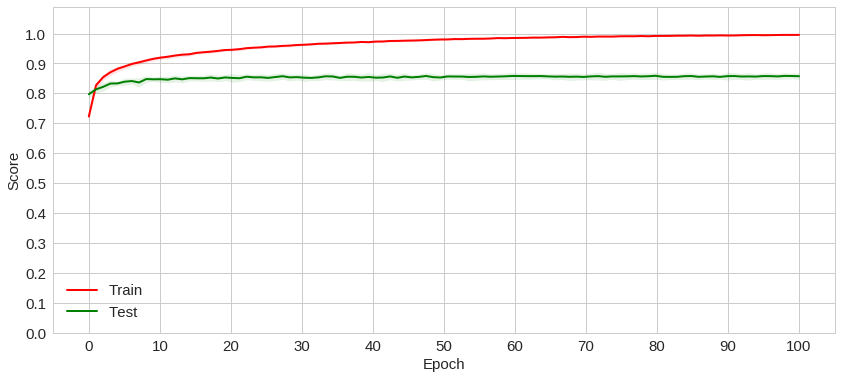

In [37]:
plot_mean_acc(tophistory)

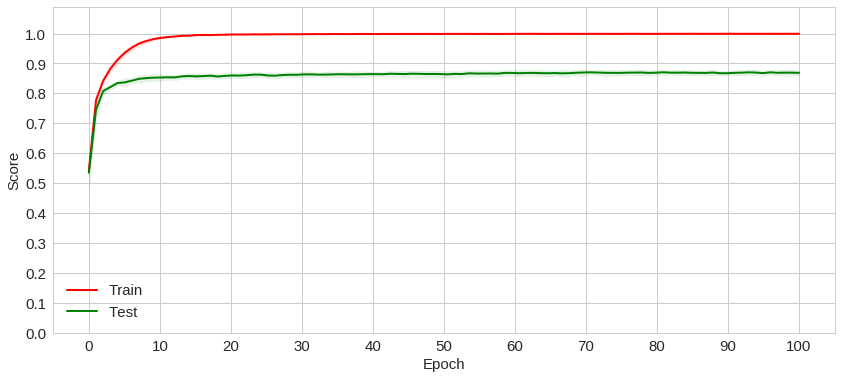

In [38]:
plot_mean_acc(history)

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

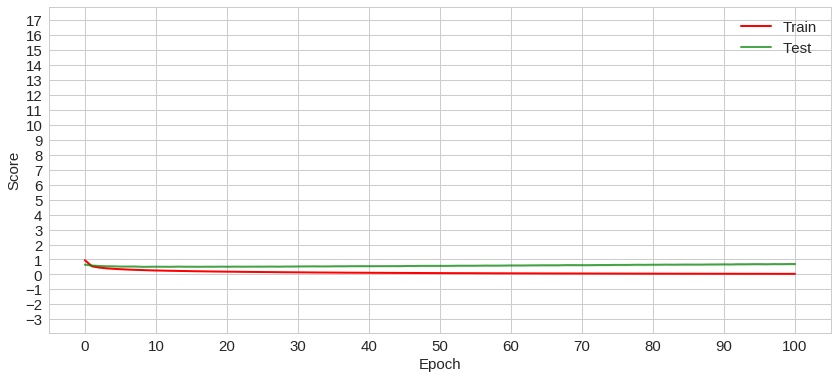

In [40]:
plot_mean_loss(tophistory)

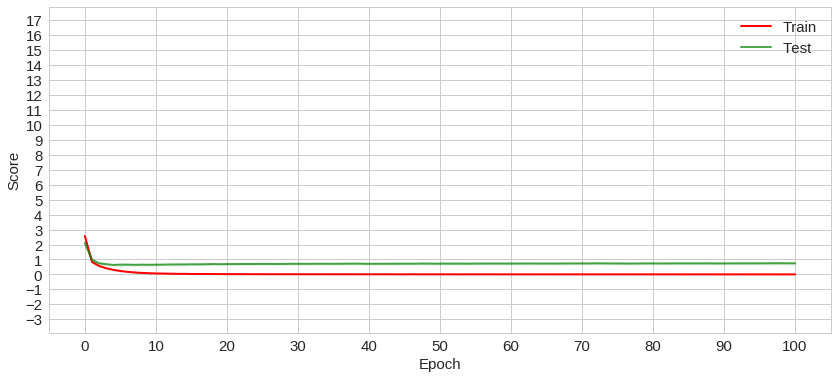

In [41]:
plot_mean_loss(history)